# Training an Agent to play PONG with REINFORCE algorithm
This notebook implements and trains REINFORCE algorithm to play ATARI-PON .using only the pixels as input. 

It is taken the **PongDeterministic-v4 OpenAI environment**. It does not contain random frameskip, so it is faster to train than the vanilla Pong-v4 environment.

REINFOCE algorithm is herein implemented with Noice Reduction (multiple trayectories) Rewards Normalization and Credit Assigment.

Convolutional neural nets, multiprocessing, and pytorch is employed to implement and train the policy.

(I strongly recommend you to try this notebook on the Udacity workspace first before running it locally on your desktop/laptop, as performance might suffer in different environments)

### Preliminary Actions

In [1]:
# Import required libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import gym
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from parallelEnv import parallelEnv

# install package for displaying animation
!pip install JSAnimation

import pong_utils # custom utilies for displaying animation, collecting rollouts and more

# widget bar to display progress
!pip install progressbar
import progressbar as pb

%matplotlib inline

  Running setup.py bdist_wheel for JSAnimation ... done
  Stored in directory: /root/.cache/pip/wheels/3c/c2/b2/b444dffc3eed9c78139288d301c4009a42c0dd061d3b62cead
Successfully built JSAnimation
  Running setup.py bdist_wheel for progressbar ... done
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built progressbar


In [2]:
# Device in used checking. 
# I recommend disabling GPU until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

using device:  cpu


In [3]:
# Explore environment
env = gym.make('PongDeterministic-v4')         # Initialize environment

print('Observation space:', env.observation_space)
print('Action space:', env.action_space)
print("List of available actions: ", env.unwrapped.get_action_meanings())

Observation space: Box(210, 160, 3)
Action space: Discrete(6)
List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


Note that we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5. The 'FIRE' part ensures that the game starts again after losing a life. The actions are hard-coded in pong_utils.py

### Preprocessing observation environment
To speed up training from pixels, we can simplify the input by downsampling and cropping the images to get a 80x80 black and white image.

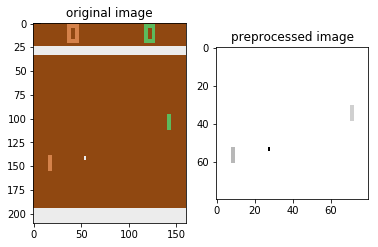

In [4]:
# Show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)

# Get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()

### Definition of the Architecture of the neural network representing the Agent policy
 
Here, we define the arquitecture of the Agent policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving right. Note that $P_{\rm left}= 1-P_{\rm right}$

In [5]:
# CNN neural network + feedforward layers
# Architecture inspired by that used in the DQN paper,
# though with lower output dimensions in the Convolutional layers

class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        
        # CNN outputsize = ((inputsize - kernel_size + 2*padding)/stride)+1 
        
        ## Definintion of CNN layers
        # convolutional layer: input 80x80x2; output 20x20x8
        self.conv1 = nn.Conv2d(2, 8, kernel_size=8, stride=4, padding=2)
        # convolutional layer: input 20x20x8; output 9x9x16
        self.conv2 = nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=0)
        # convolutional layer: input 9x9x16; output 7x7x32
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)
        self.size = 7 * 7 * 32
        
        # Convolutional Batch Normalization
        self.convbn1 = nn.BatchNorm2d(8)
        self.convbn2 = nn.BatchNorm2d(16)
        self.convbn3 = nn.BatchNorm2d(32)
        
        ## Definition of the feedforward layers
        # linear layer (7x7x32 -> 1568)
        self.fc1 = nn.Linear(self.size, 256)
        # linear layer (512 -> 62)
        self.fc2 = nn.Linear(256, 32)
        # linear layer (62 -> 2)
        self.fc3 = nn.Linear(32, 1)
        
        # dropout layer
        self.dropout = nn.Dropout(0.5)
        
        # Sigmoid function
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        ## Forward behavior
        
        # Sequence of convolutional layers
        x = self.convbn1(F.relu(self.conv1(x)))
        x = self.convbn2(F.relu(self.conv2(x)))
        x = self.convbn3(F.relu(self.conv3(x)))
        
        # flatten image input
        x = x.view(-1, self.size)
        
        # 1st hidden layer, with dropout and relu activation function
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        # 2nd hidden layer, with dropout and relu activation function
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        # 3rd (and output) hidden layer with dropout and sigmoid function
        x = self.dropout(x)
        x = self.sig(self.fc3(x))
        
        return x

In [6]:
# Initialize policy model
policy = Policy().to(device)
#policy=pong_utils.Policy().to(device) # Example policy in pong_utils file

# Set-up optimizer and definition of step size (learning rate)
optimizer = optim.Adam(policy.parameters(), lr=1e-4)      # ADAM used; SGD another option

In [7]:
# Printing model architecture
policy

Policy(
  (conv1): Conv2d(2, 8, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
  (conv2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (convbn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convbn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convbn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1568, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.5)
  (sig): Sigmoid()
)

### Visualizing an untrained agent (random play)
pong_utils file contains a play function given the environment and a policy.


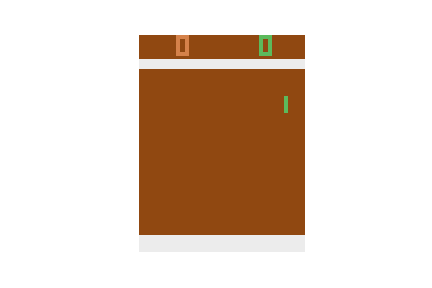
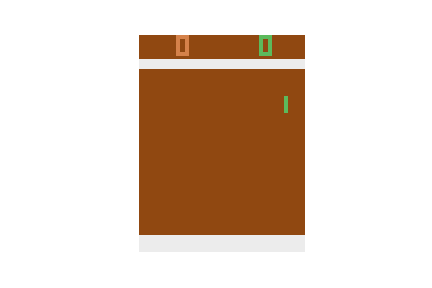
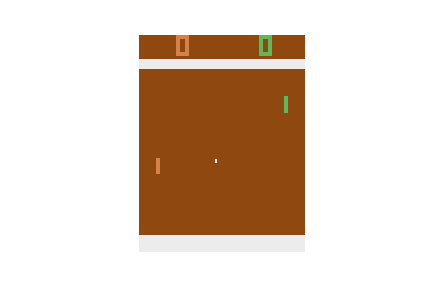
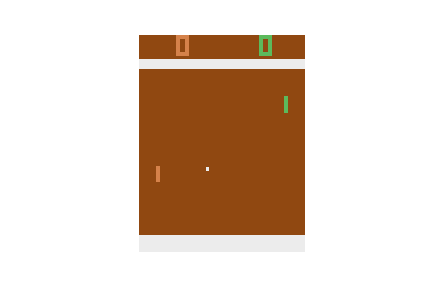
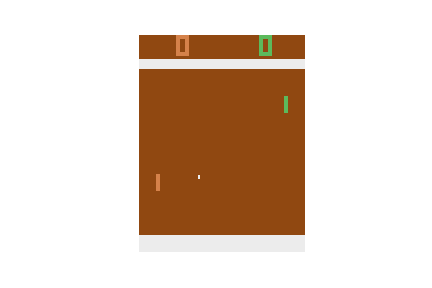
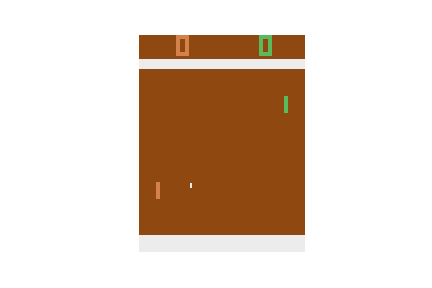
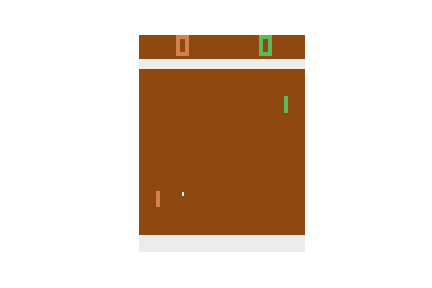
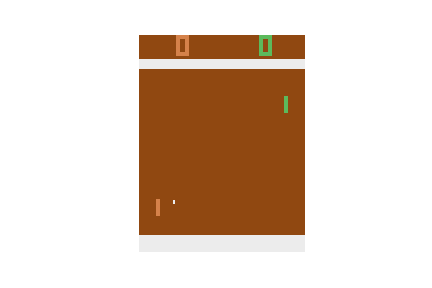
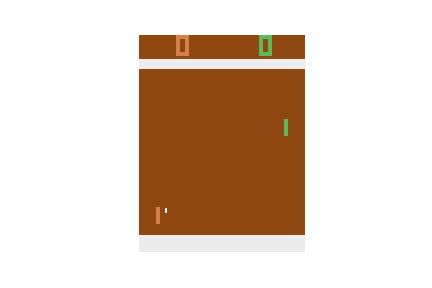
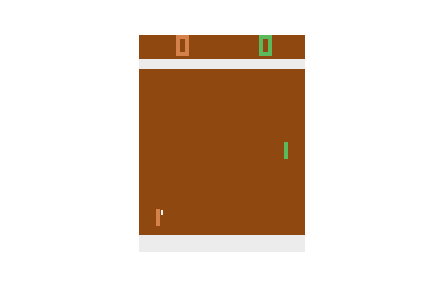
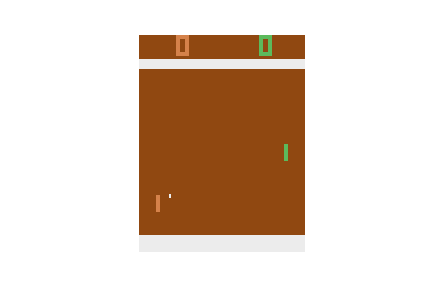
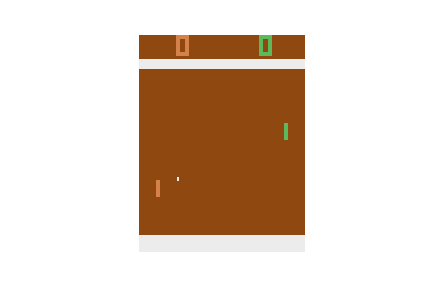
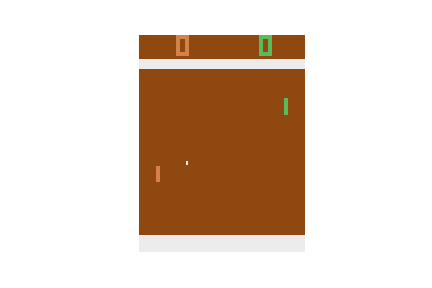
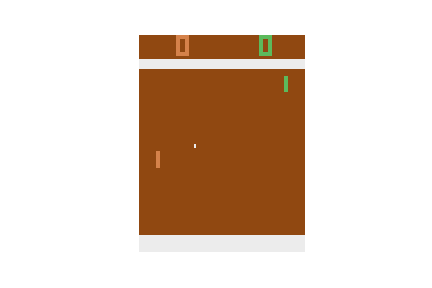
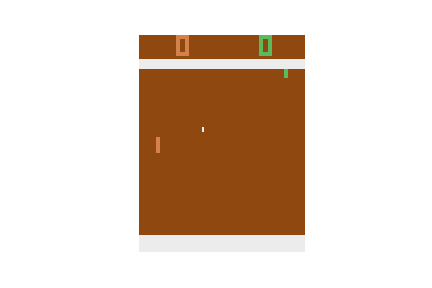
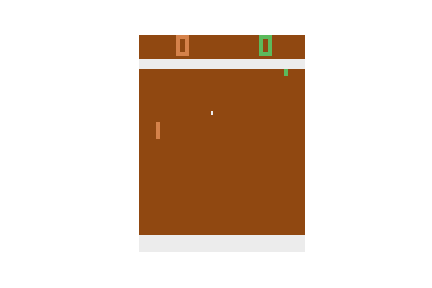
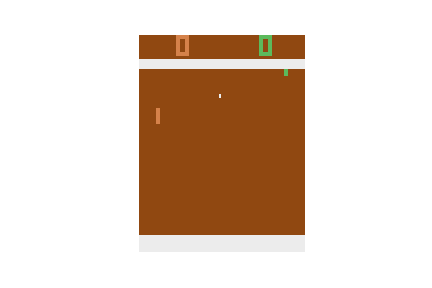
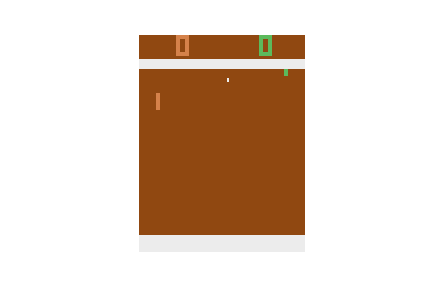
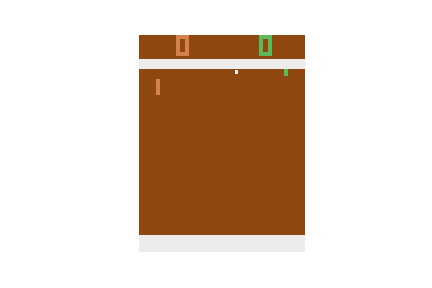
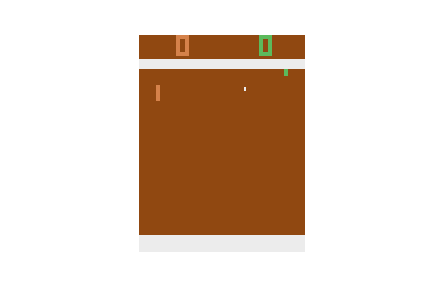
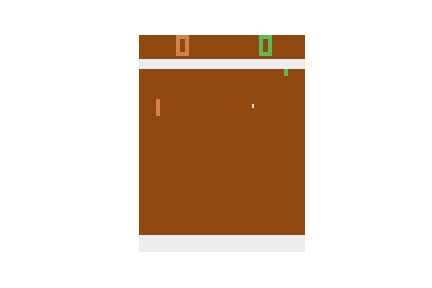
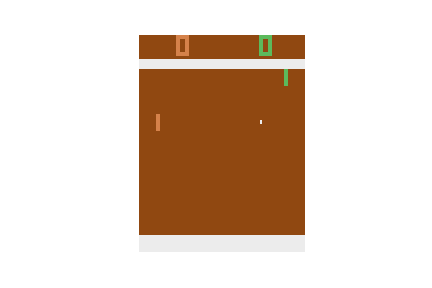
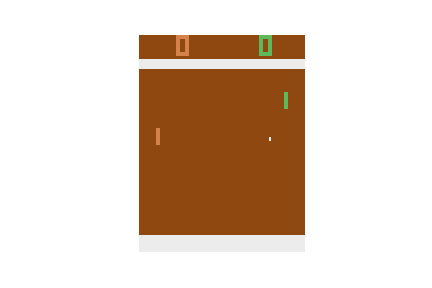
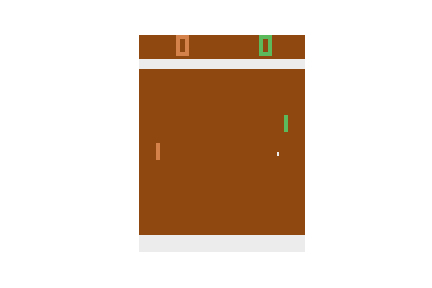
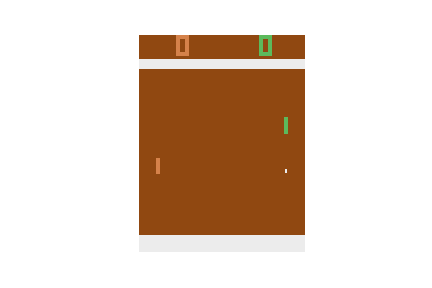
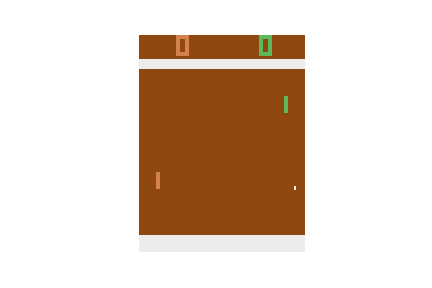
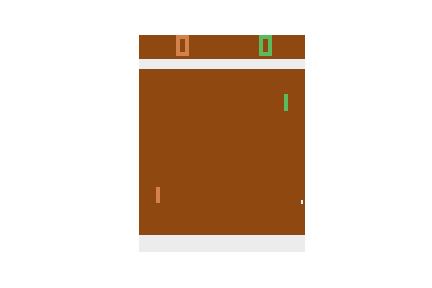
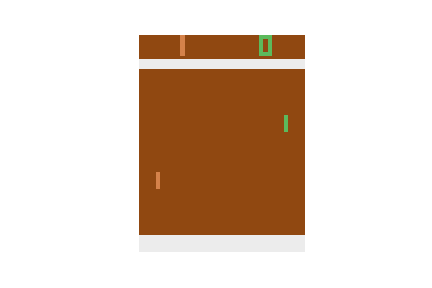
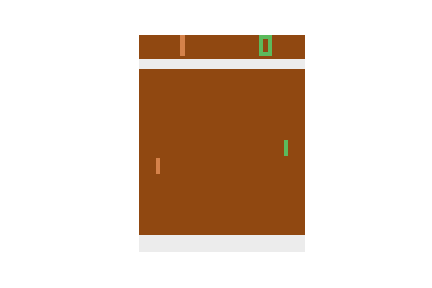
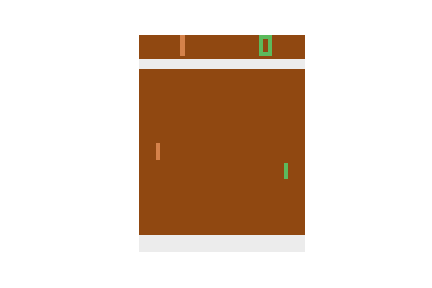
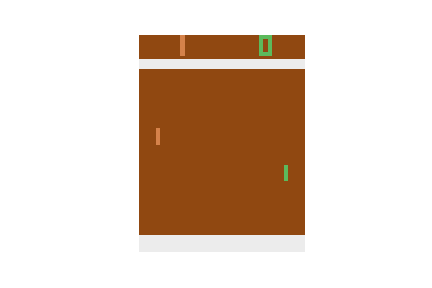
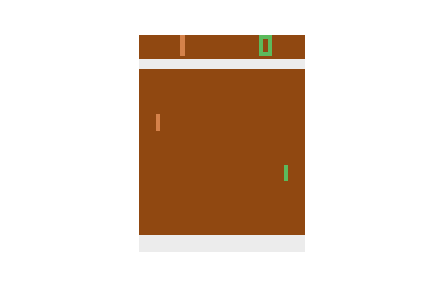
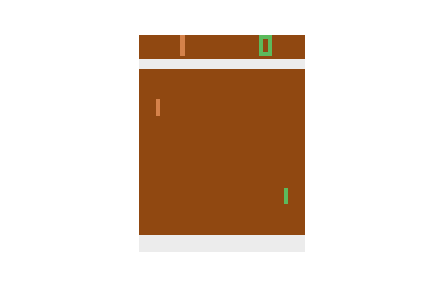
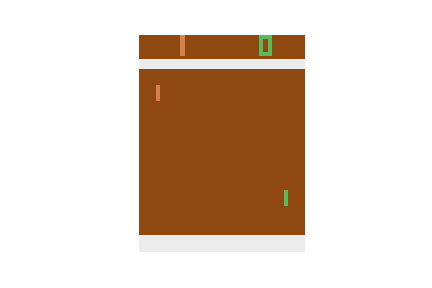
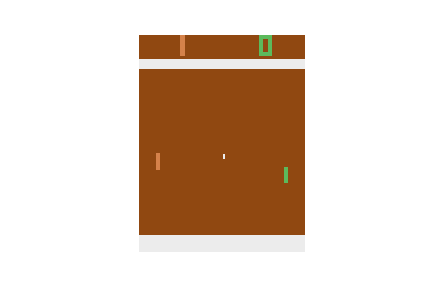
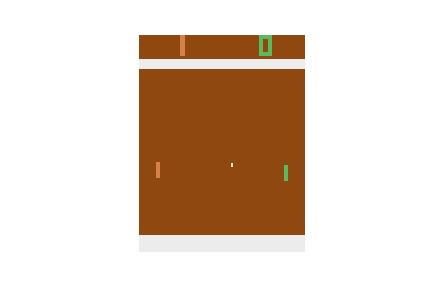
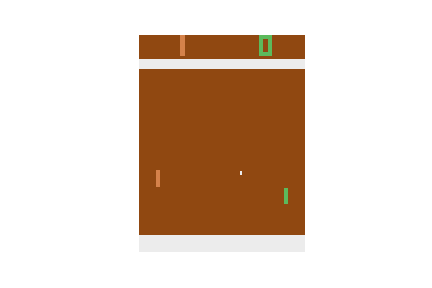
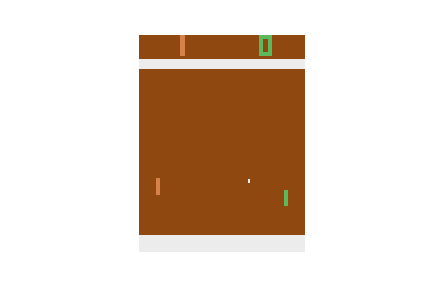
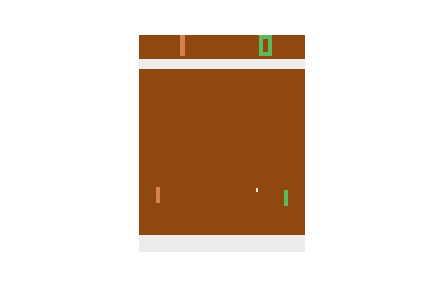
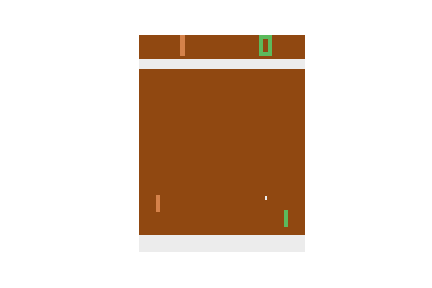
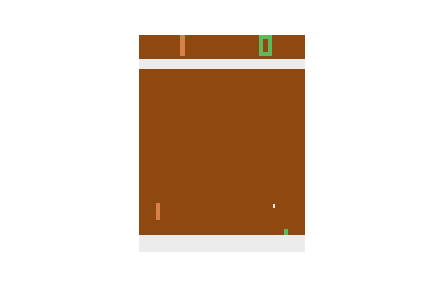
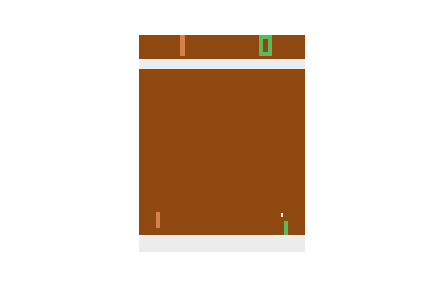
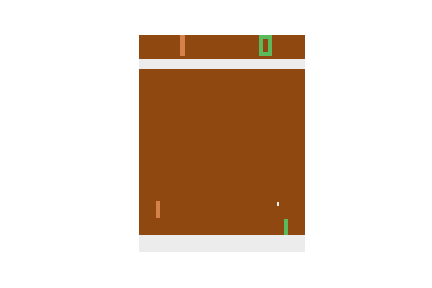
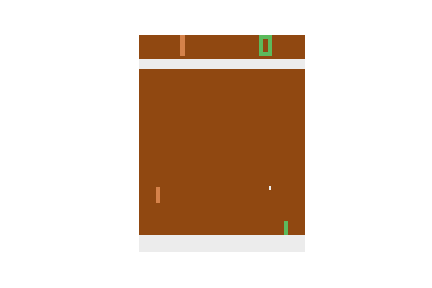
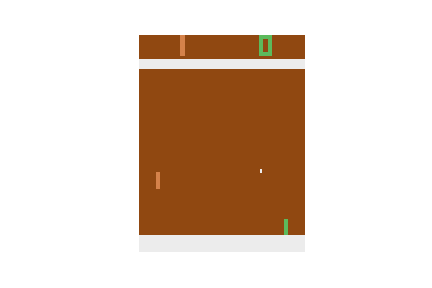
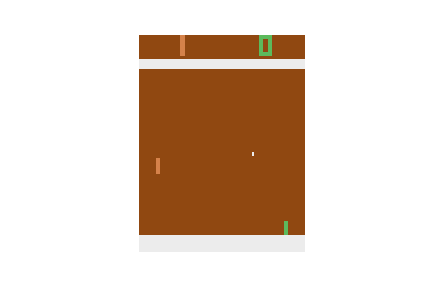
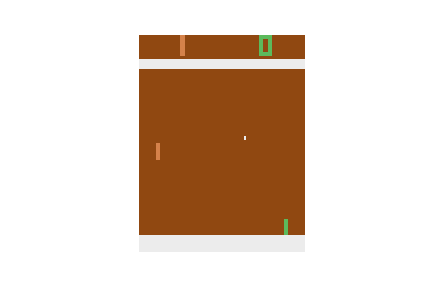
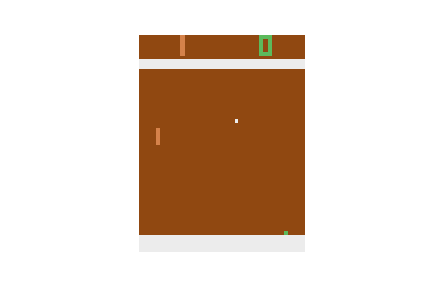
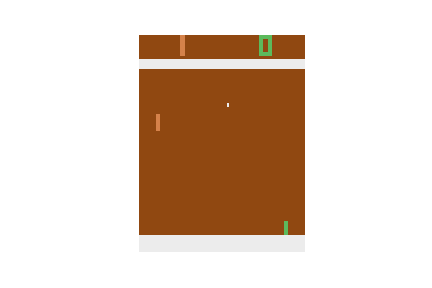
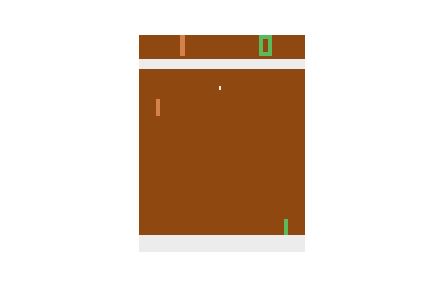
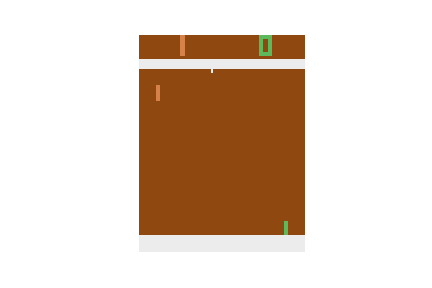
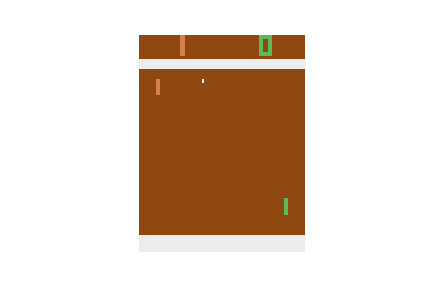
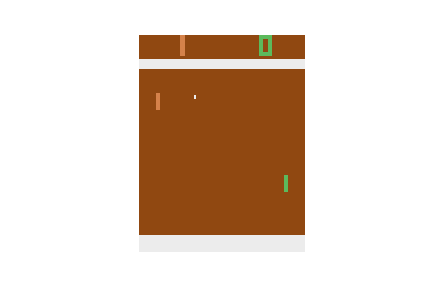
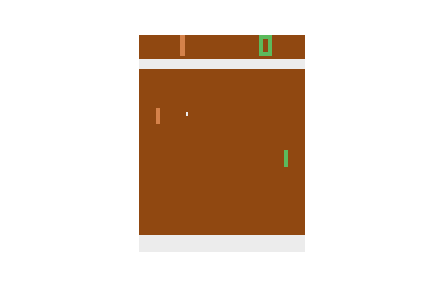
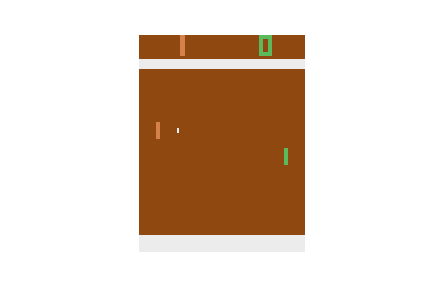
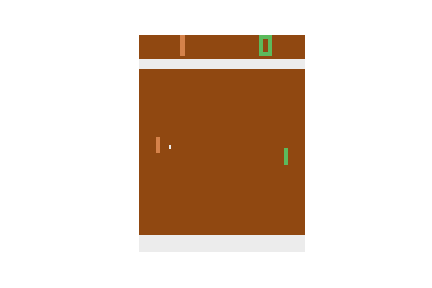
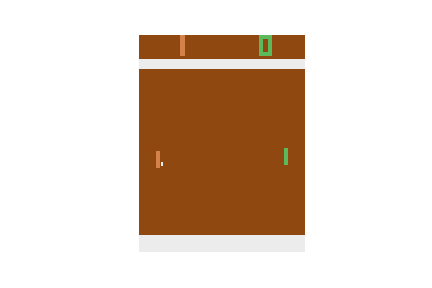
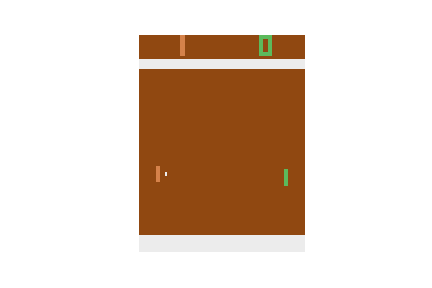
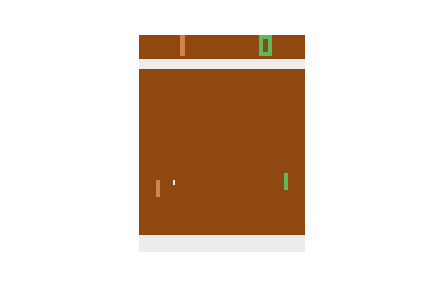
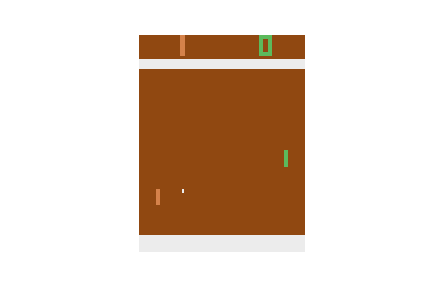
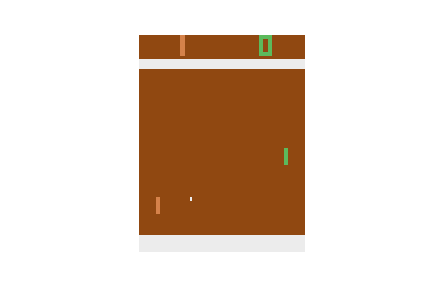
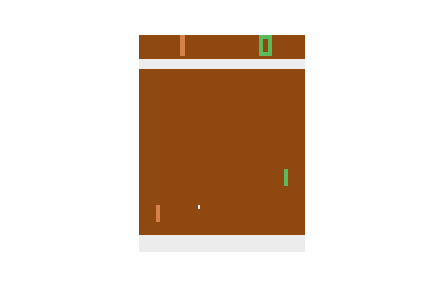
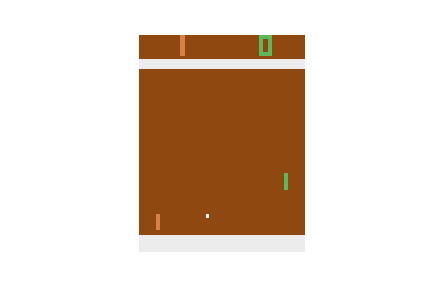
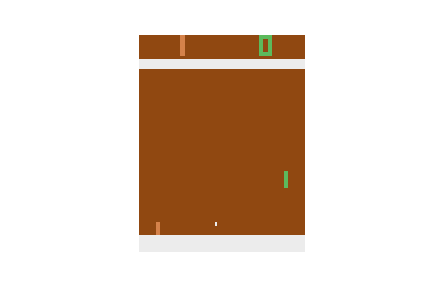
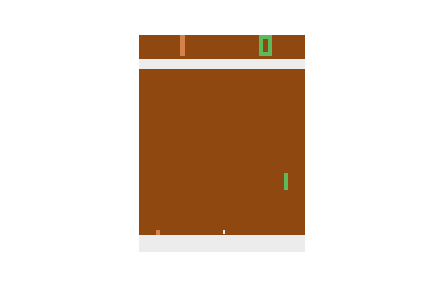
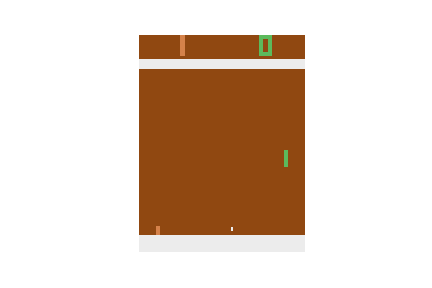
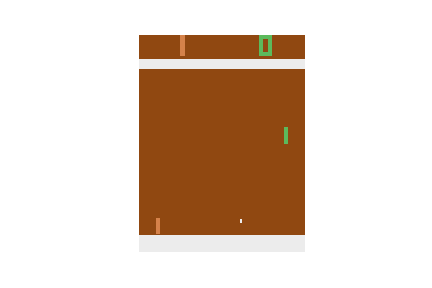
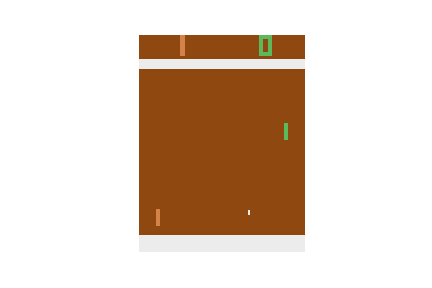
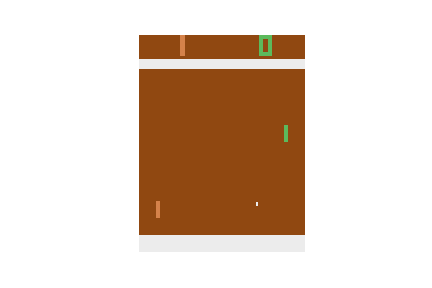
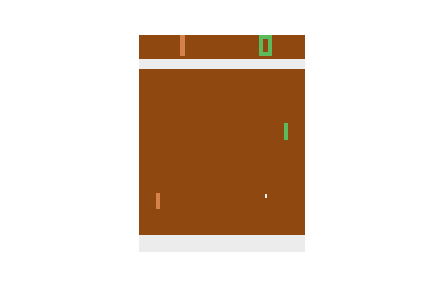
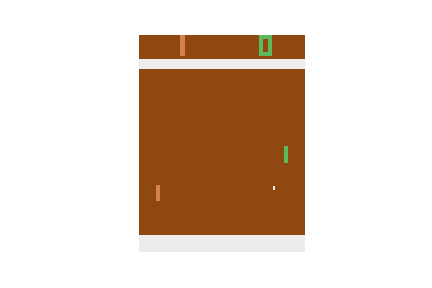
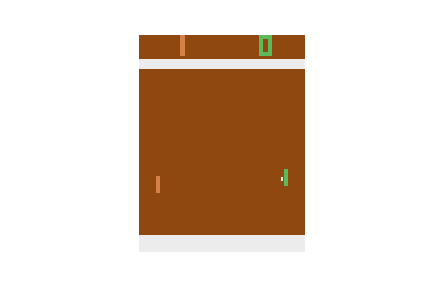
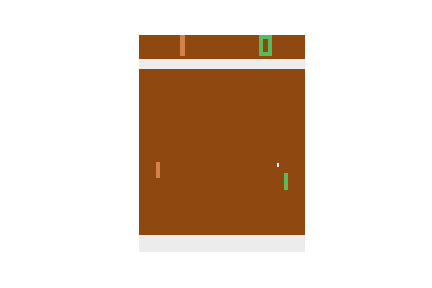
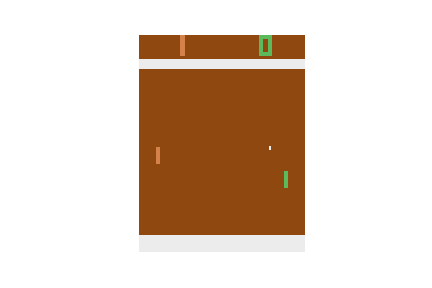
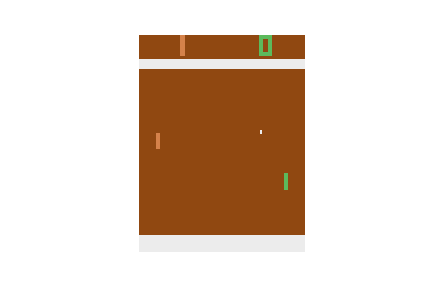
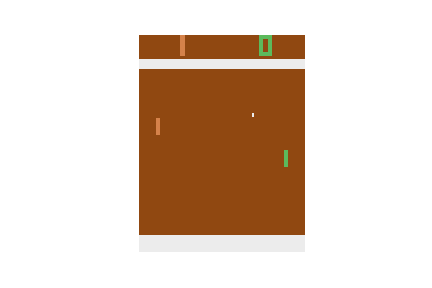
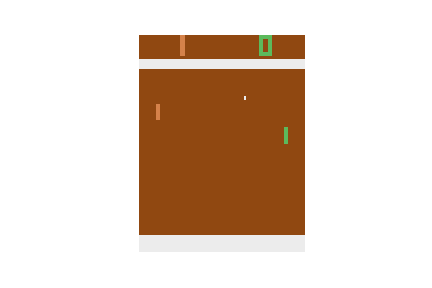
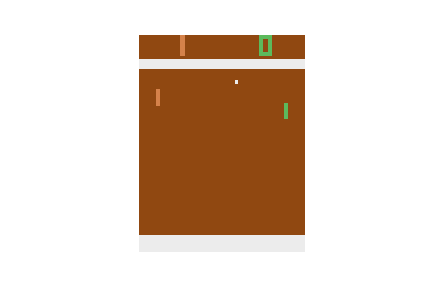
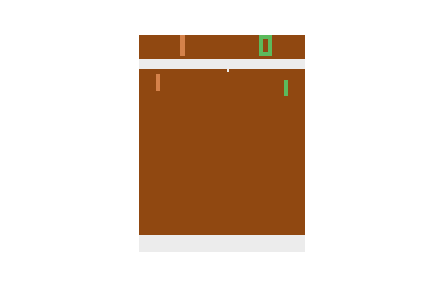
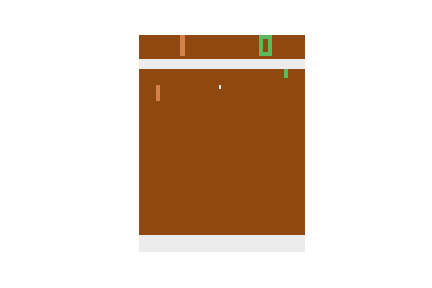
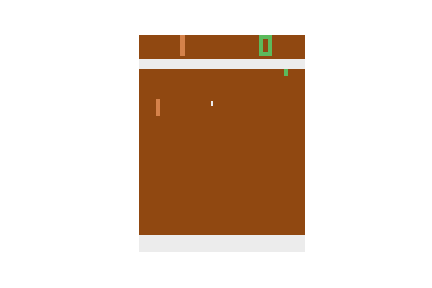
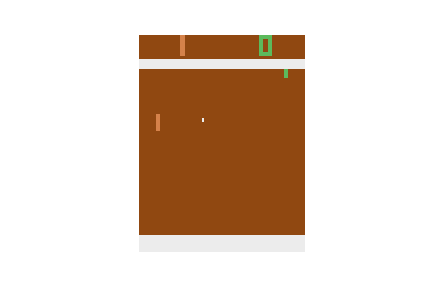
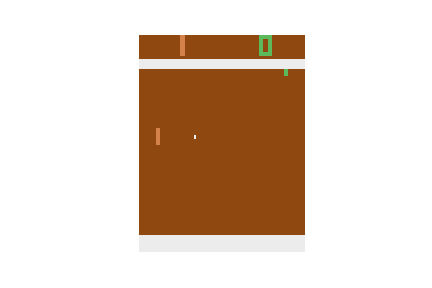
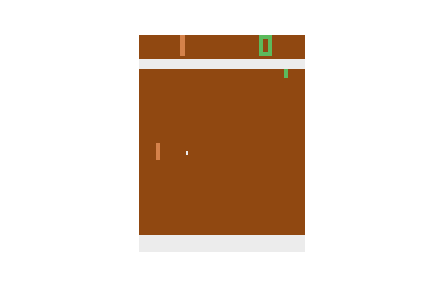
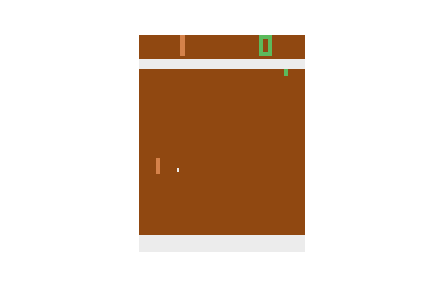
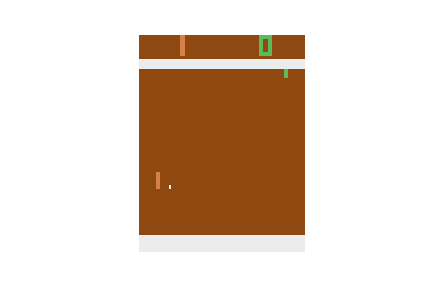
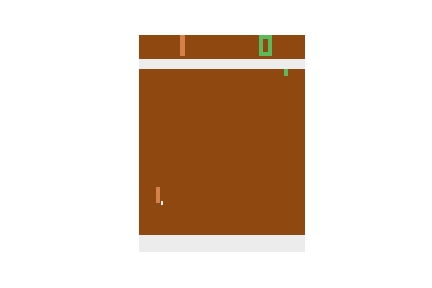
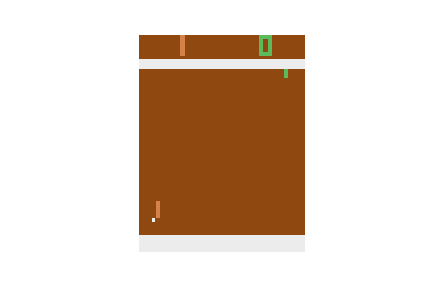
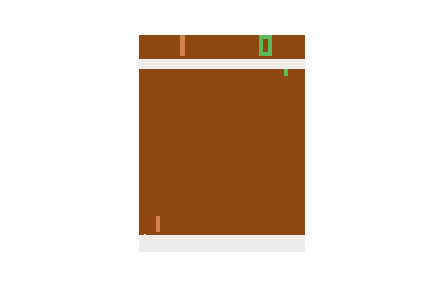
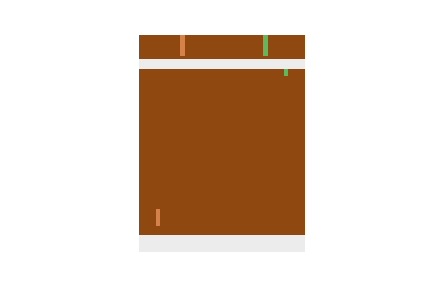
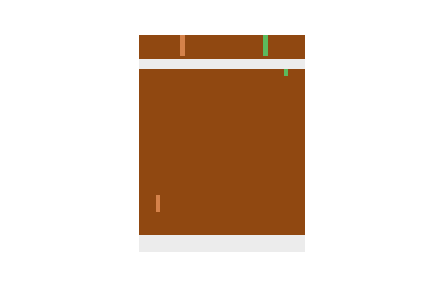
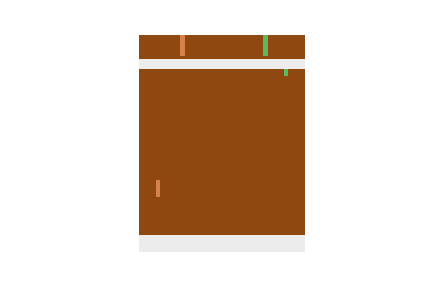
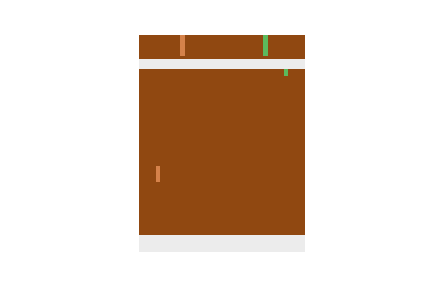
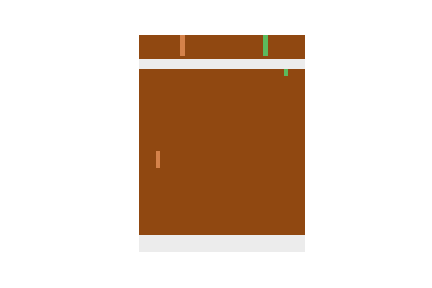
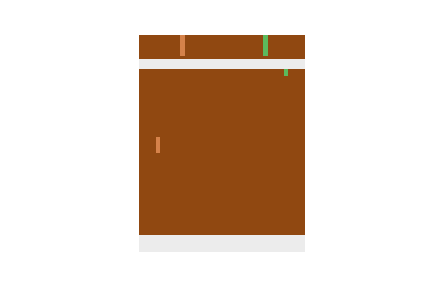
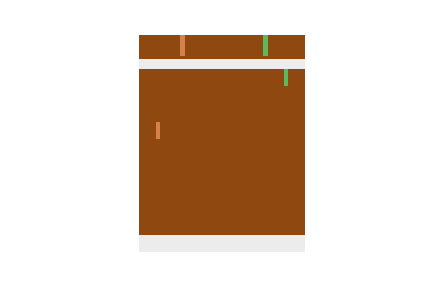
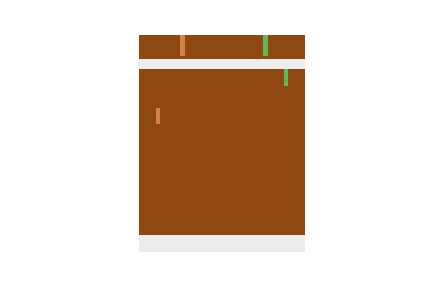
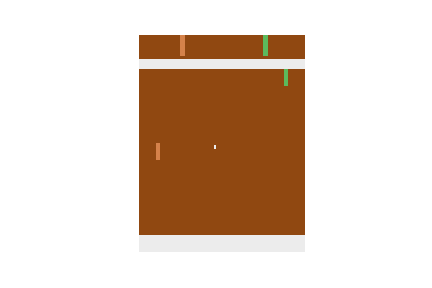
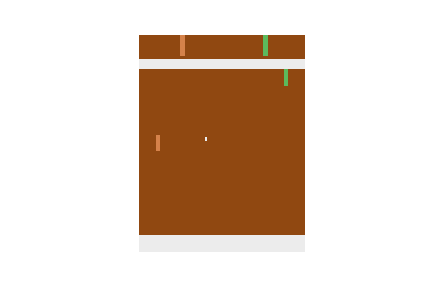
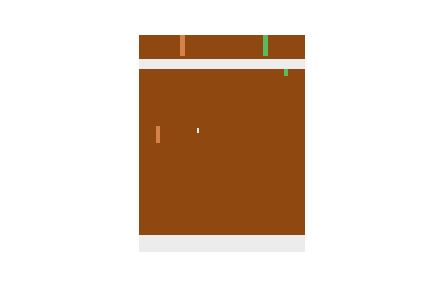

In [8]:
# Before preprocessing the environment
pong_utils.play(env, policy, time=100) # before preprocessing

# After preprocessing
# pong_utils.play(env, policy, time=100, preprocess=pong_utils.preprocess_single) after preprocessing

### Samples collection by means of parallelized environments
Before we start the training, we need to collect samples. To make things efficient we use parallelized environments to collect multiple examples at once

In [9]:
# Iniziale parallel environemnts
envs = pong_utils.parallelEnv('PongDeterministic-v4', n=4, seed=12345)

# Collecting a trayectory
prob, state, action, reward = pong_utils.collect_trajectories(envs, policy, tmax=100)

# Printing collected probabilities.
# Note that for every time step, four numbers are given: one for each parallelized environment
print(prob)

[array([ 0.5202626 ,  0.50710583,  0.47820288,  0.51303005], dtype=float32), array([ 0.4881863 ,  0.48337308,  0.48696336,  0.45787236], dtype=float32), array([ 0.51403856,  0.53709793,  0.4181546 ,  0.4479658 ], dtype=float32), array([ 0.51050818,  0.5213151 ,  0.51703519,  0.49002326], dtype=float32), array([ 0.49586356,  0.36693746,  0.54494107,  0.49038017], dtype=float32), array([ 0.50077373,  0.53646123,  0.45852339,  0.49087983], dtype=float32), array([ 0.4714458 ,  0.49580231,  0.50438631,  0.53754961], dtype=float32), array([ 0.5392828 ,  0.50532883,  0.50565135,  0.51784444], dtype=float32), array([ 0.51038599,  0.47639668,  0.50928551,  0.51263106], dtype=float32), array([ 0.57104552,  0.51953667,  0.50250542,  0.50692976], dtype=float32), array([ 0.54465836,  0.49387971,  0.46717888,  0.52728552], dtype=float32), array([ 0.50202775,  0.49499425,  0.53981173,  0.51657164], dtype=float32), array([ 0.50011319,  0.49332443,  0.50106907,  0.54784328], dtype=float32), array([ 0.5

### Implementation of the REINFORCE algorithm
We have two choices (usually it's useful to divide by the time since we've normalized our rewards and the time of each trajectory is fixed)

1. $\frac{1}{T}\sum^T_t R_{t}^{\rm future}\log(\pi_{\theta'}(a_t|s_t))$
2. $\frac{1}{T}\sum^T_t R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}$ where $\theta'=\theta$ and make sure that the no_grad is enabled when performing the division

Note that NOISE REDUCTION (collection of multiple trajectories in parallel), REWARD NORMALIZATION and CREDIT ASSIGNMENT is implemented.

<img src='./aux_items/REINFORCE_pseudocode.png' width='800' />

In [10]:
def policy_loss(policy, old_probs, states, actions, rewards,
              gamma = 0.995):

    # Calculate discounted return for each time step
    discount = gamma**np.arange(len(rewards))           
    rewards = np.asarray(rewards)*discount[:,np.newaxis]
    
    # Evaluate future rewards at each time step --> for CREDIT ASIGNMENT application
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    
    # Future Reward normalization
    # Regularization steers new_policy towards 0.5, which prevents policy to become exactly 0 or 1
    # It helps with exploration
    mean = np.mean(rewards_future, axis=1)
    std = np.std(rewards_future, axis=1) + 1.0e-10  # constant added to avoid singularity (zero division)
    rewards_normalized = (rewards_future - mean[:,np.newaxis])/std[:,np.newaxis]
    
    # Convert to PyTorch tensors and move to device
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    rewards = torch.tensor(rewards_normalized, dtype=torch.float, device=device)
 
    # Convert states to policy (or probability)
    new_probs = pong_utils.states_to_prob(policy, states)
    new_probs = torch.where(actions == pong_utils.RIGHT, new_probs, 1.0-new_probs)

    # Evalutaion of Loos function for REINFORCE algorithn with CREDIT ASIGNMENT and NOISE REDUCTION
    loss = torch.mean(rewards*torch.log(new_probs))

    return loss

In [11]:
loss = policy_loss(policy, prob, state, action, reward)
print(loss)

tensor(1.00000e-03 *
       4.6133, device='cuda:0')


### Training step.
Turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [12]:
# training loop max iterations
episode = 500
# episode = 800

# widget bar to display progress
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()

# initialize environment
envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

# Hyperparameters definition
gamma = 0.99    # discount factor
tmax = 320      # maximum time steps per trajectory

# Initizlize list for keeping track of mean rewards progress
mean_rewards = []

# Training loop
for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards = pong_utils.collect_trajectories(envs, policy, tmax=tmax)
        
    total_rewards = np.sum(rewards, axis=0)

    # Evaluation of policyy Loss (negative for applying gradient ASCENT)
    loss = - policy_loss(policy, old_probs, states, actions, rewards, gamma=gamma)

    # Gradient ASCENT application
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    del loss
    
    # Average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # Display progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()

# Save the policy of the trained agent
torch.save(policy, 'REINFORCE.policy')

Episode: 20, score: -13.000000
[-15. -12. -15. -17. -12.  -8. -14. -11.]


Episode: 40, score: -14.875000
[-15. -15. -15. -16. -15. -12. -14. -17.]


Episode: 60, score: -15.000000
[-16. -16. -16. -16. -15. -14. -11. -16.]


Episode: 80, score: -13.125000
[-15.  -8. -12. -15. -13. -15. -15. -12.]


Episode: 100, score: -12.125000
[-16. -12. -15. -11. -12. -14.  -1. -16.]


Episode: 120, score: -13.250000
[ -9. -15. -15. -11. -12. -14. -16. -14.]


Episode: 140, score: -13.375000
[-11. -14. -12. -15. -14. -13. -12. -16.]


Episode: 160, score: -14.375000
[-13. -15. -15. -14. -13. -14. -15. -16.]


Episode: 180, score: -11.000000
[ -9. -15.  -8. -14. -10. -11.  -8. -13.]


Episode: 200, score: -11.375000
[-10. -13. -14. -10. -15.  -6. -13. -10.]


Episode: 220, score: -11.375000
[-13. -11. -16. -11.  -9. -12. -11.  -8.]


Episode: 240, score: -11.875000
[-12.  -9.  -5. -12. -11. -14. -16. -16.]


Episode: 260, score: -12.375000
[-12. -15. -11. -14. -10. -16.  -9. -12.]


Episode: 280, score: -11.625000
[ -7.  -8. -15. -16. -15. -10. -11. -11.]


Episode: 300, score: -11.625000
[ -9. -11. -13. -13. -14. -12. -10. -11.]


Episode: 320, score: -11.125000
[-12. -14. -11. -15.  -9.  -5. -11. -12.]


Episode: 340, score: -11.125000
[-12.  -7. -14. -14.  -9. -10. -14.  -9.]


Episode: 360, score: -8.375000
[ -6. -11.  -6.  -9.  -8.  -6. -12.  -9.]


Episode: 380, score: -8.500000
[ -8.  -4.  -9. -10. -12.  -7. -11.  -7.]


Episode: 400, score: -7.375000
[ -8.  -5.  -9. -13.  -7.  -6.  -5.  -6.]


Episode: 420, score: -8.500000
[ -9.  -1. -12. -11.  -8.  -8.  -7. -12.]


Episode: 440, score: -5.250000
[ -7. -10.  -6.  -6.  -2.  -3.  -4.  -4.]


Episode: 460, score: -6.875000
[-11.  -7. -11.  -4.  -4.  -8.  -5.  -5.]


Episode: 480, score: -4.875000
[-2. -4. -4. -7. -9. -6.  0. -7.]


Episode: 500, score: -6.625000
[-8. -4. -7. -6. -6. -6. -9. -7.]



/opt/conda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Policy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


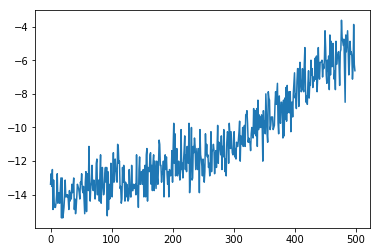

In [13]:
# Ploting the scores evolution during training.
plt.plot(mean_rewards)

In [9]:
# Load your policy (when needed)
policy = torch.load('REINFORCE.policy')

### View the trained agent in action


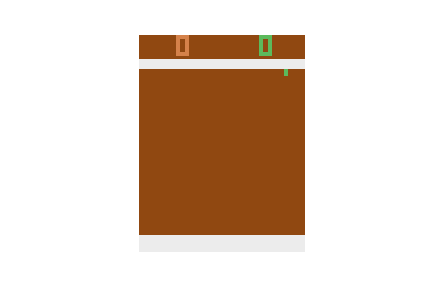
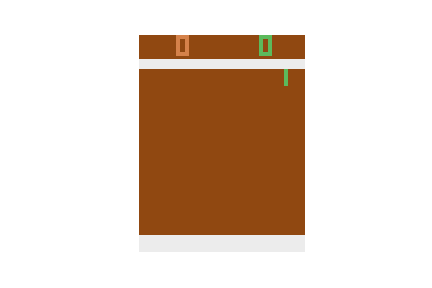
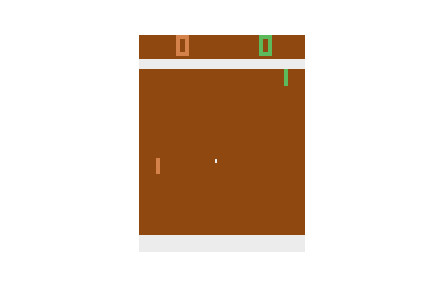
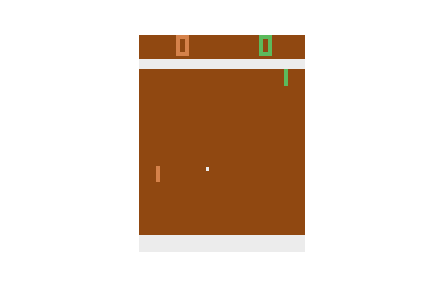
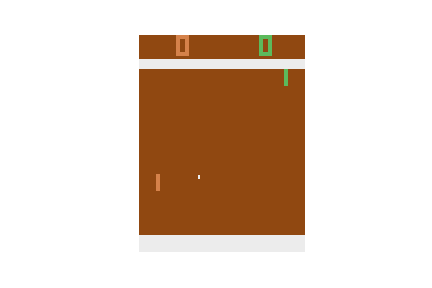
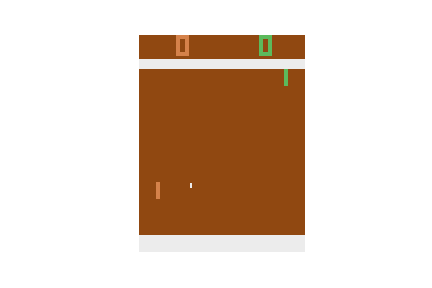
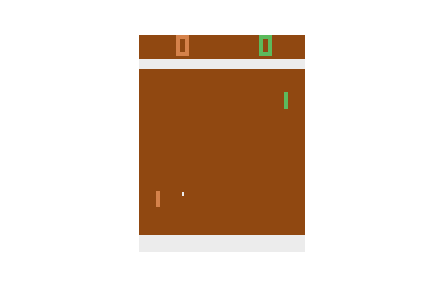
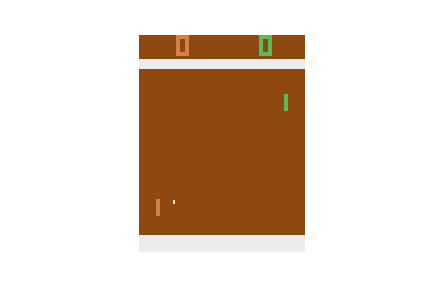
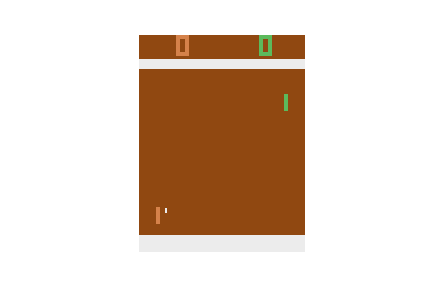
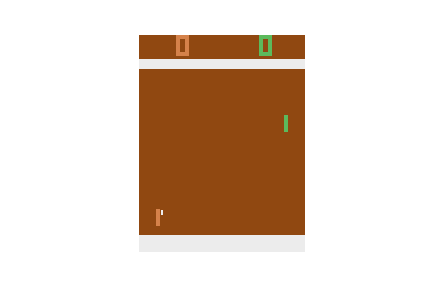
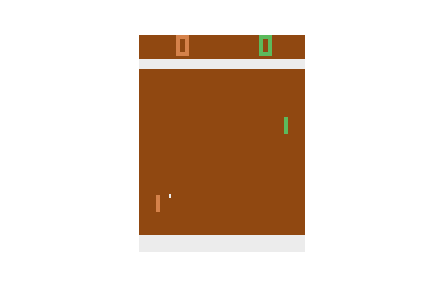
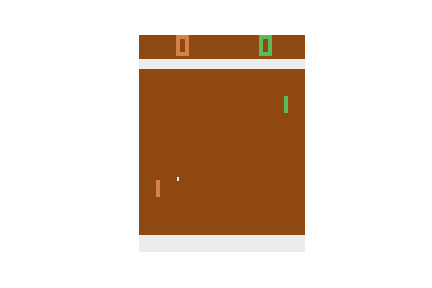
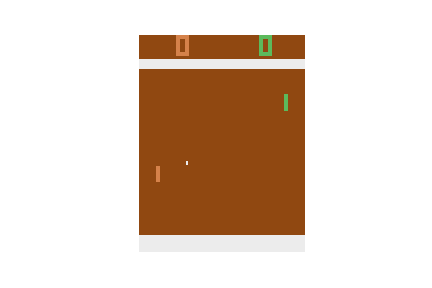
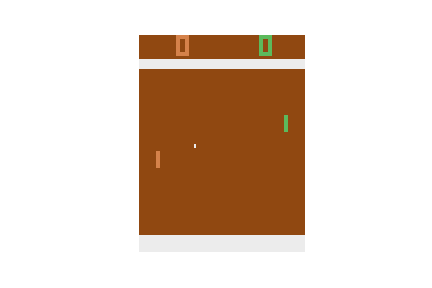
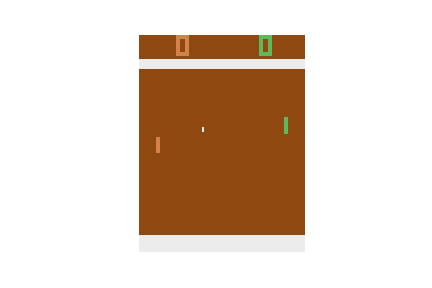
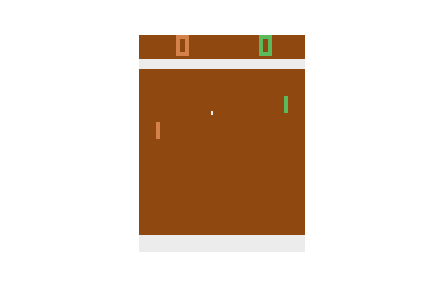
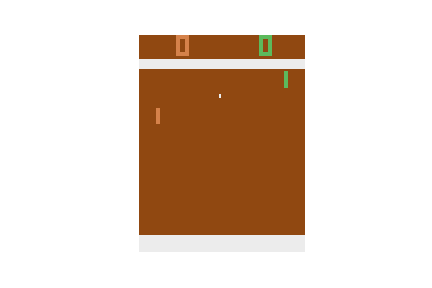
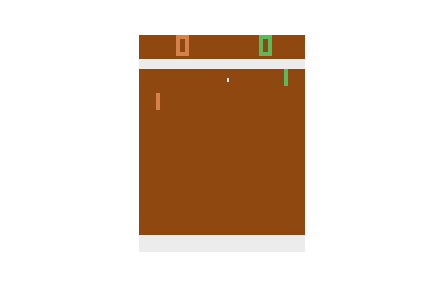
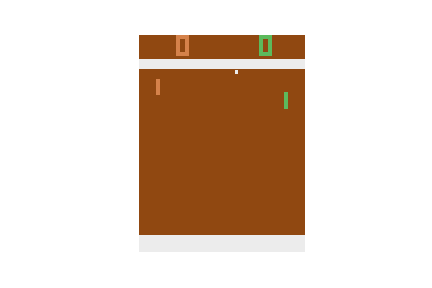
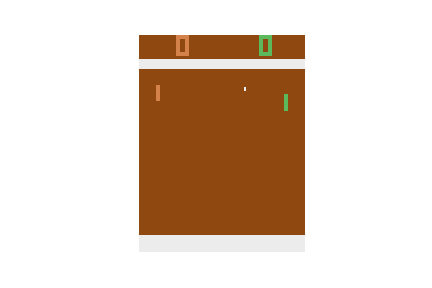
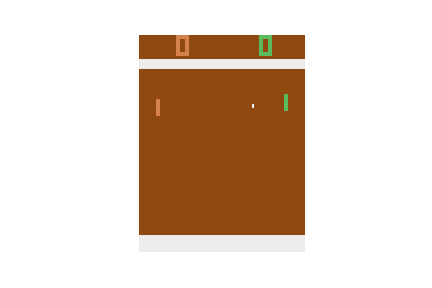
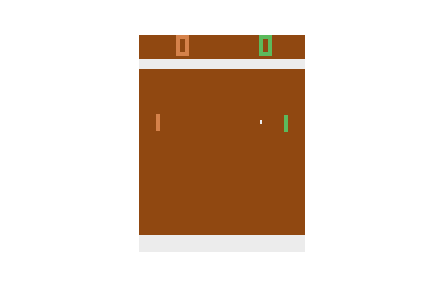
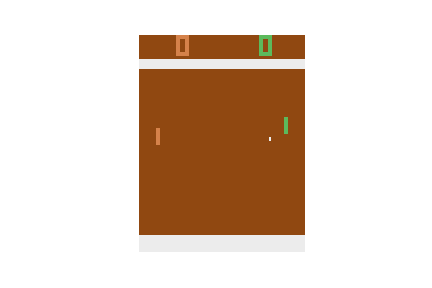
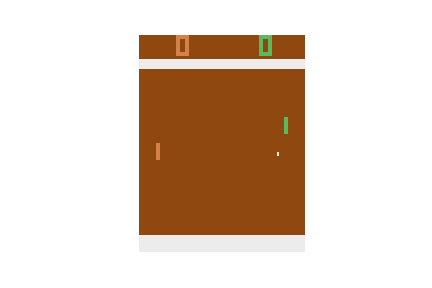
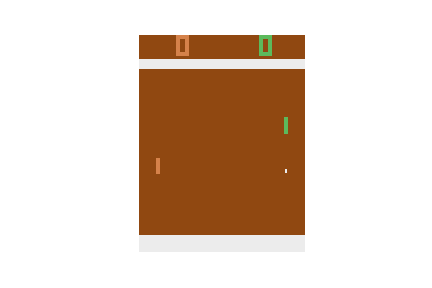
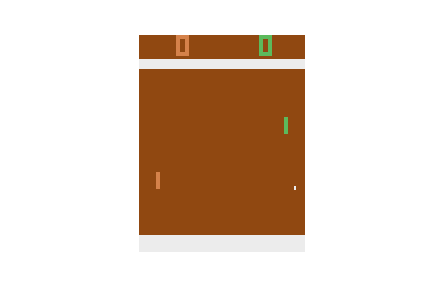
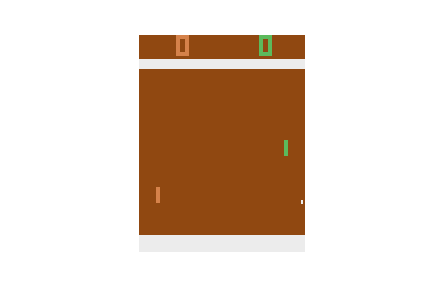
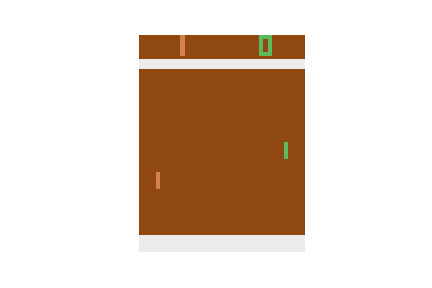
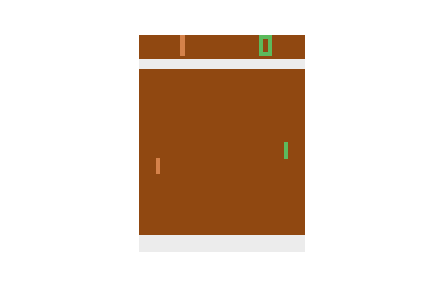
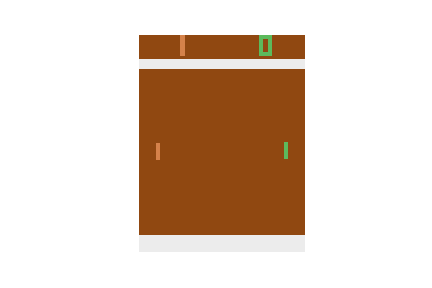
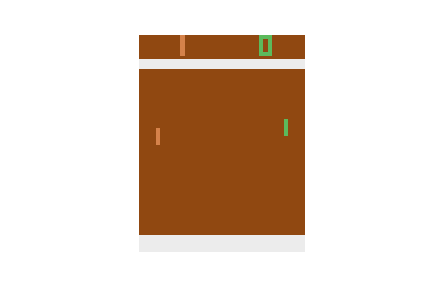
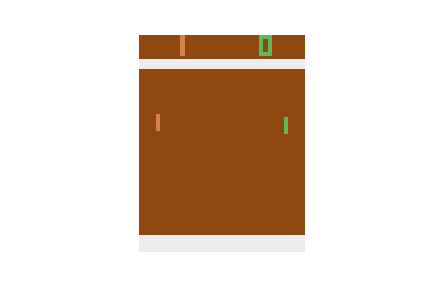
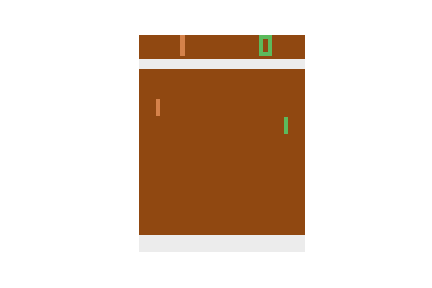
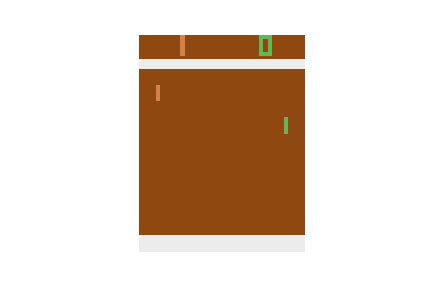
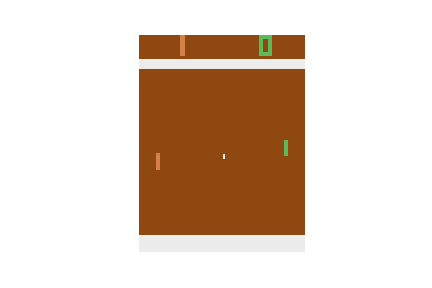
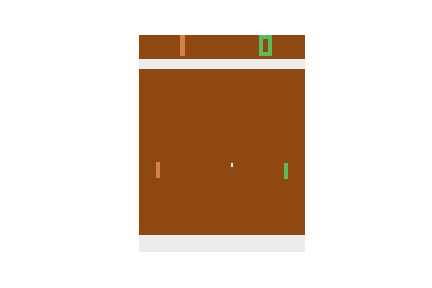
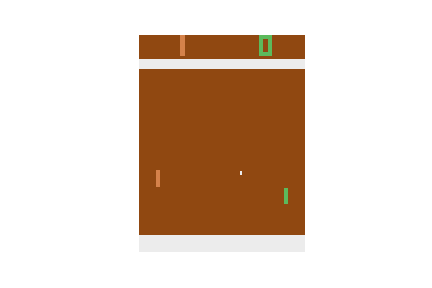
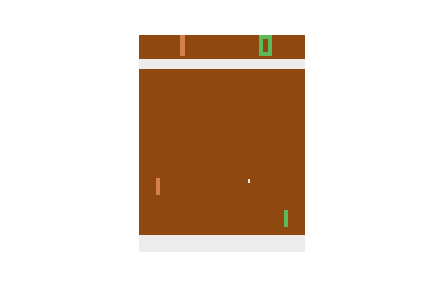
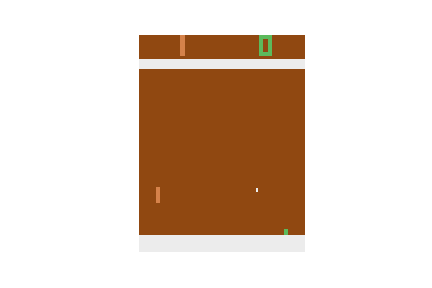
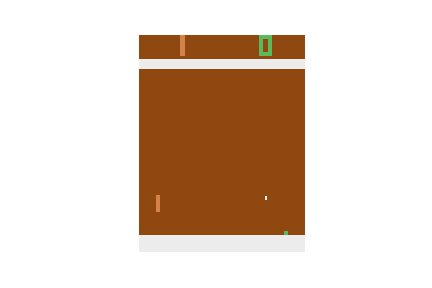
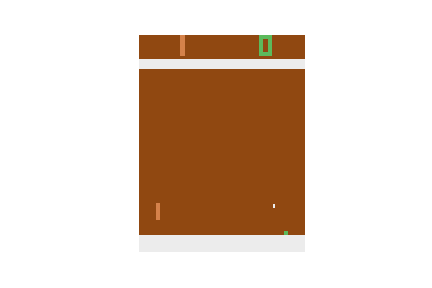
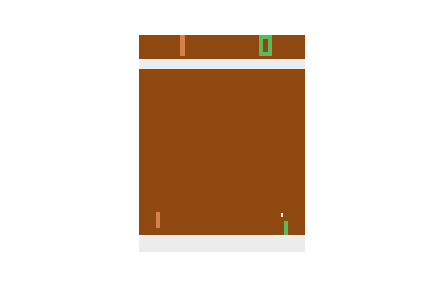
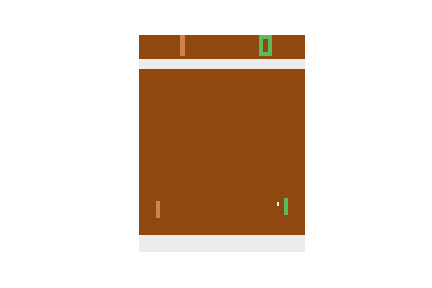
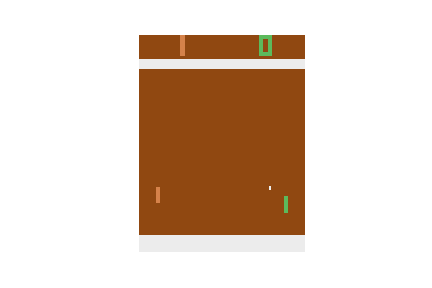
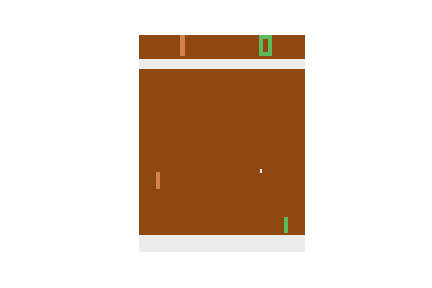
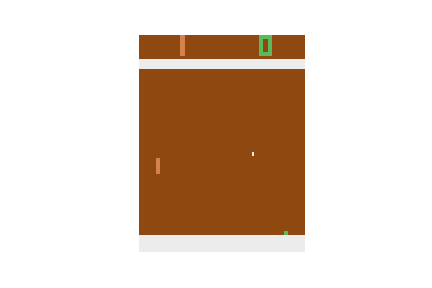
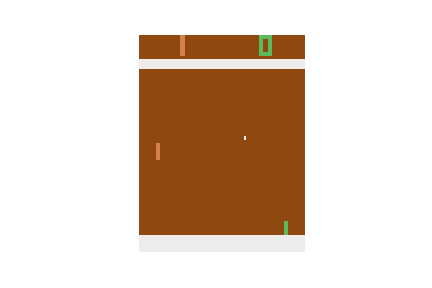
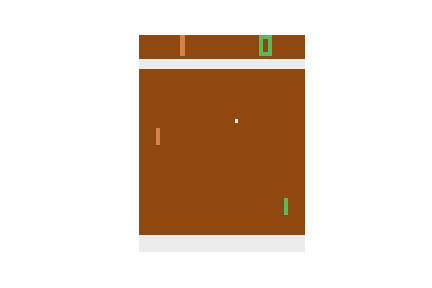
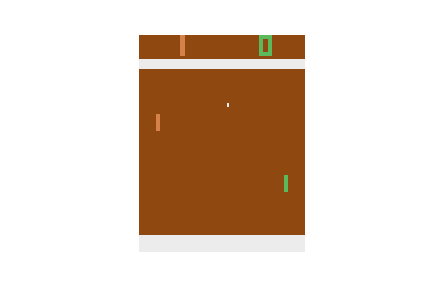
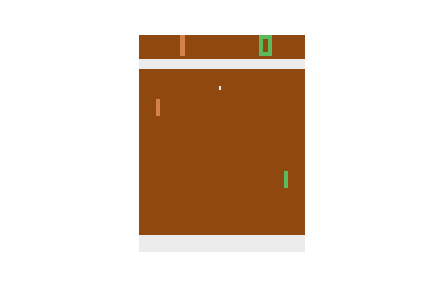
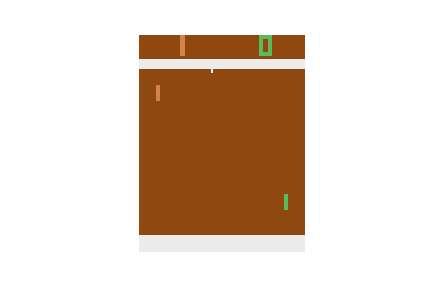
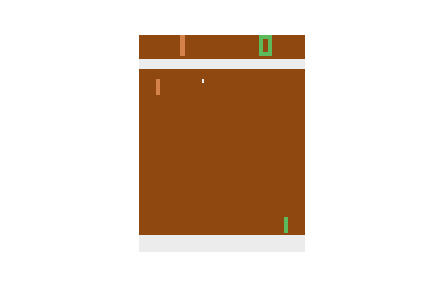
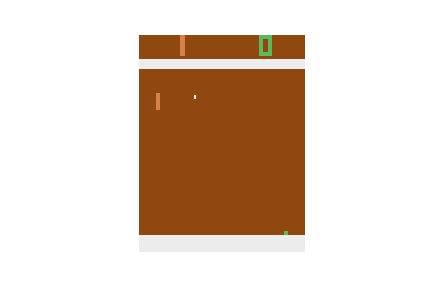
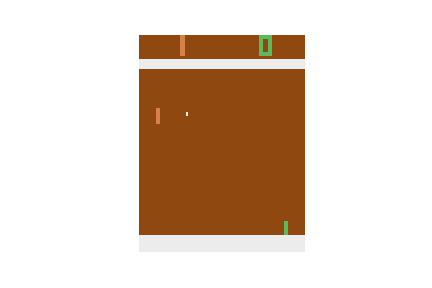
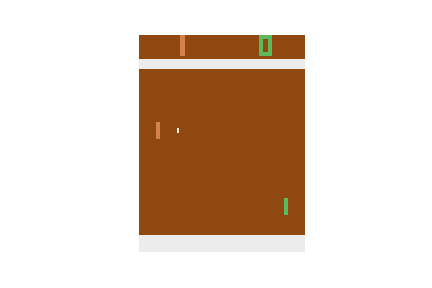
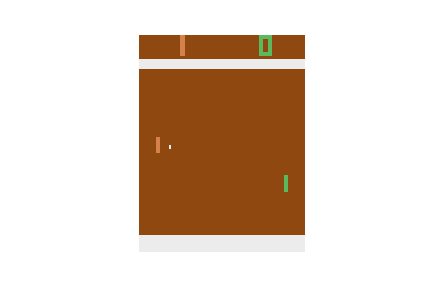
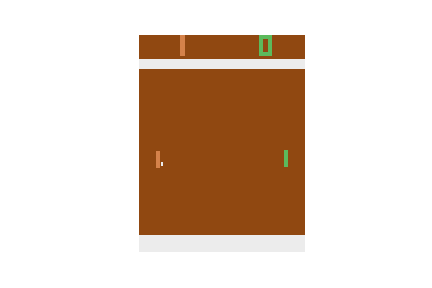
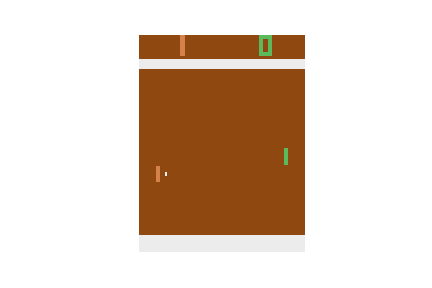
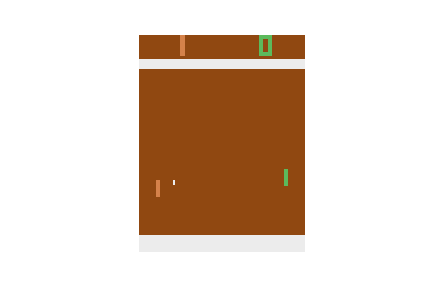
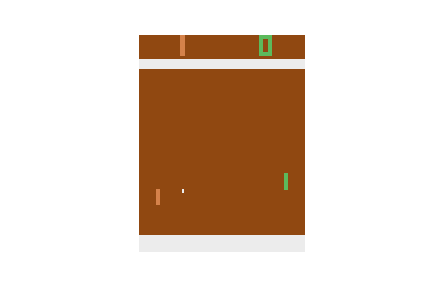
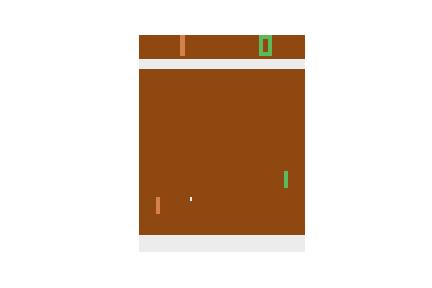
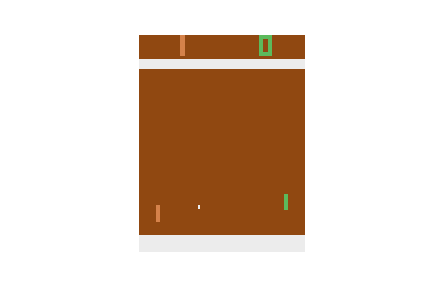
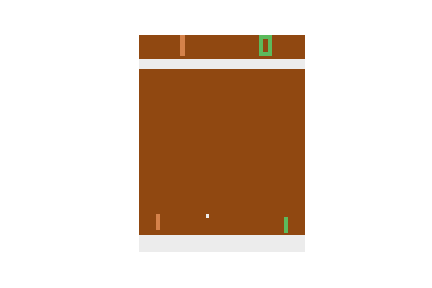
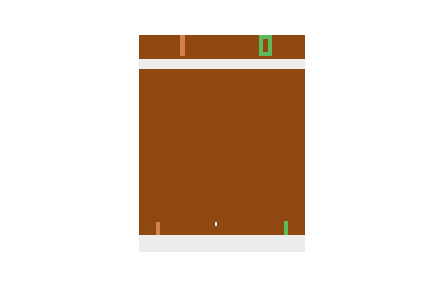
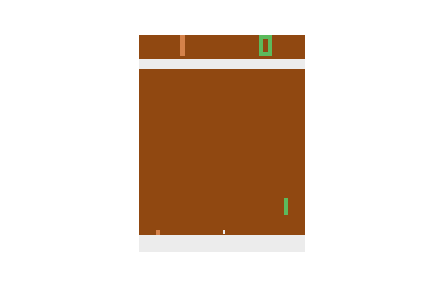
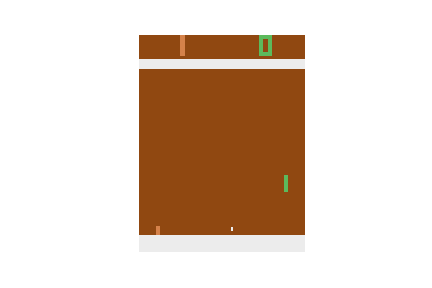
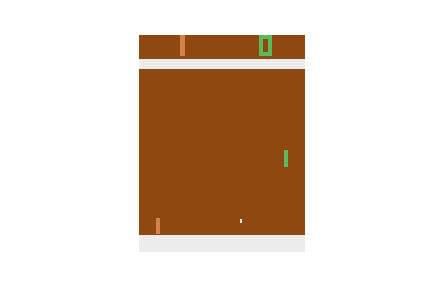
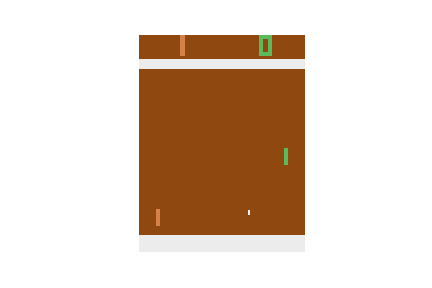
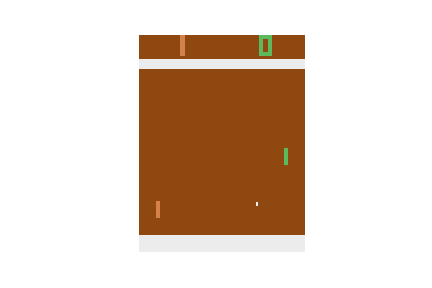
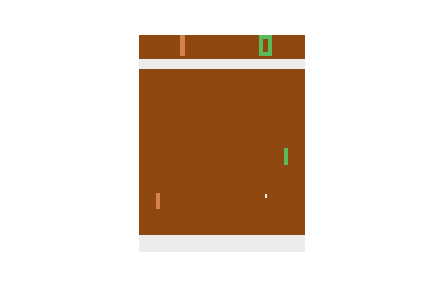
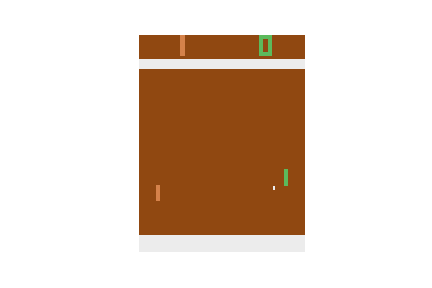
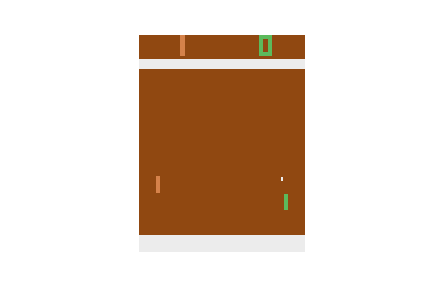
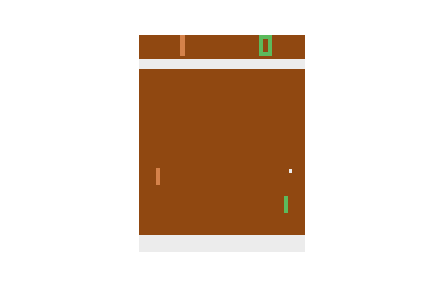
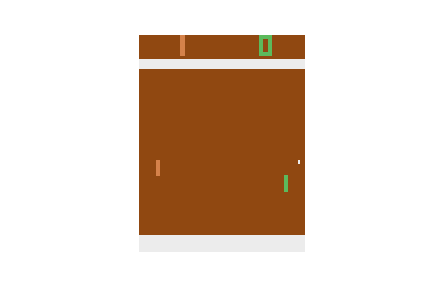
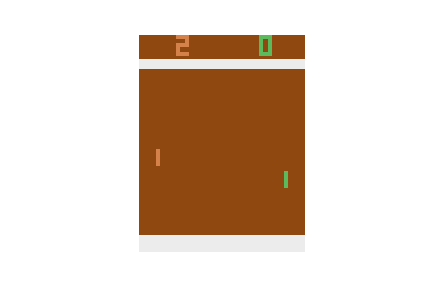
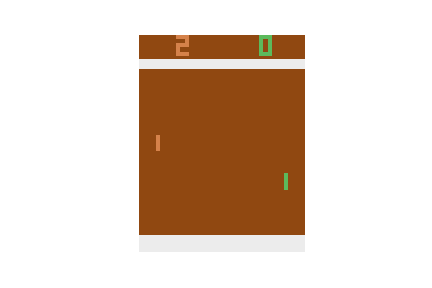
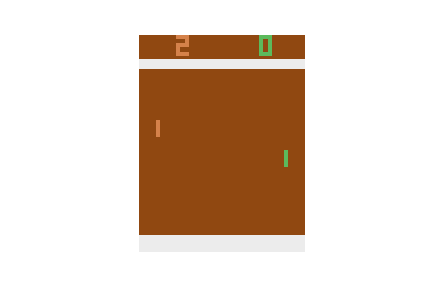
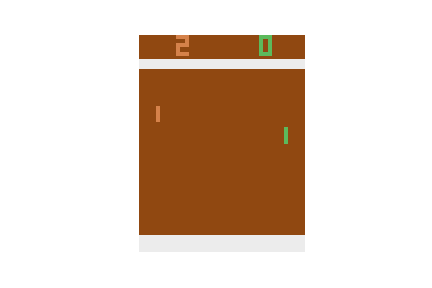
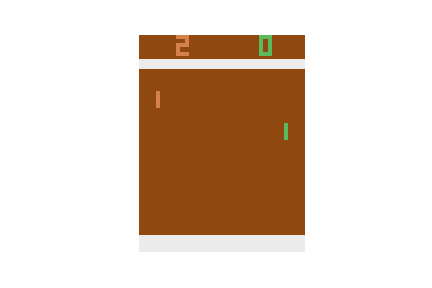
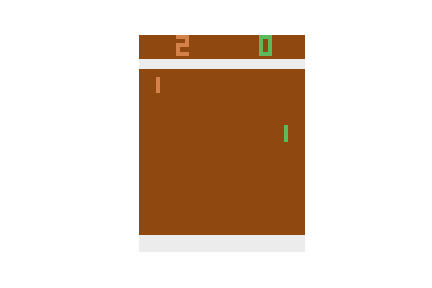
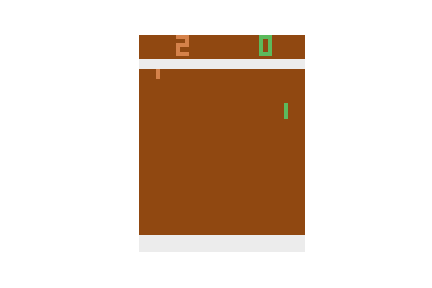
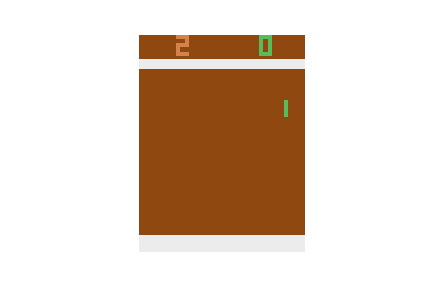
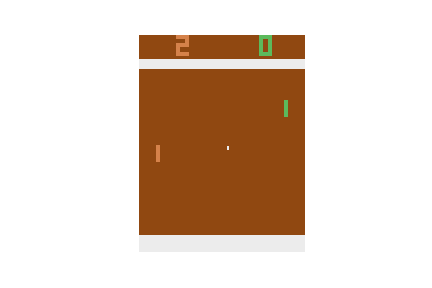
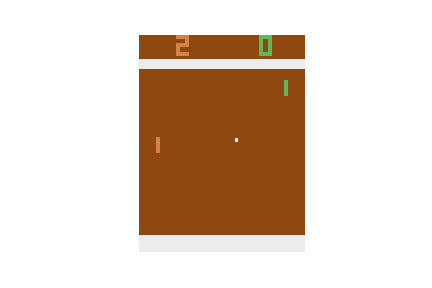
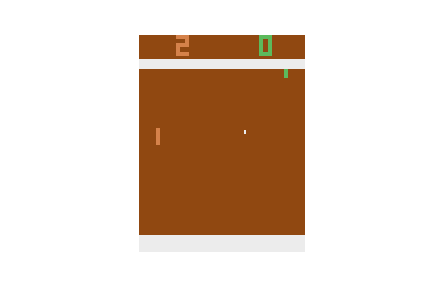
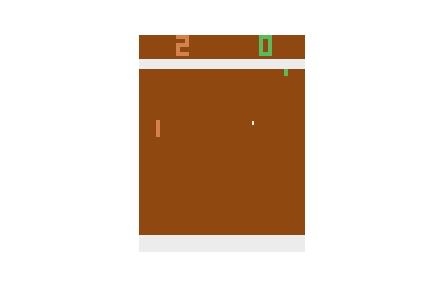
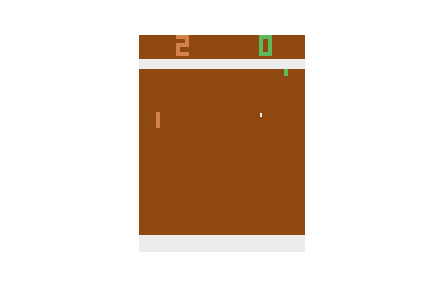
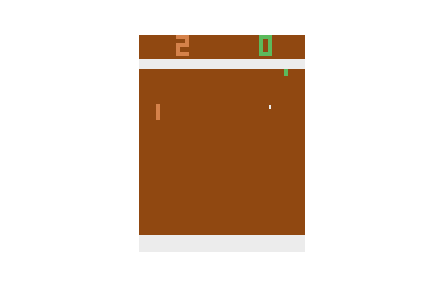
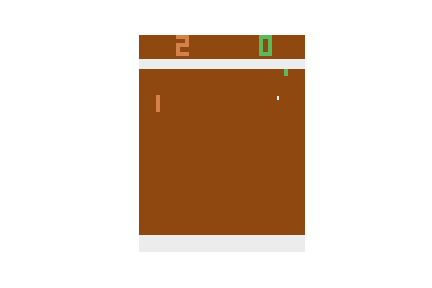
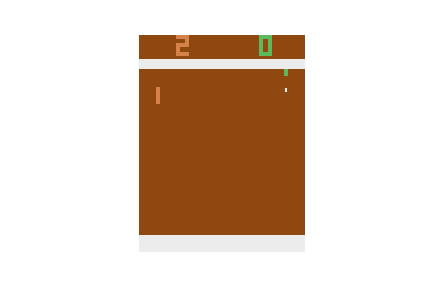
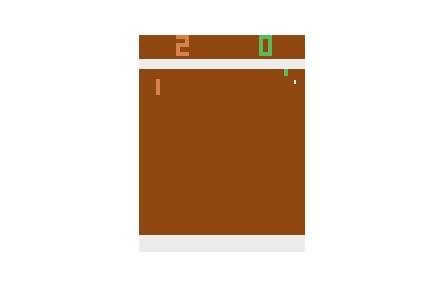
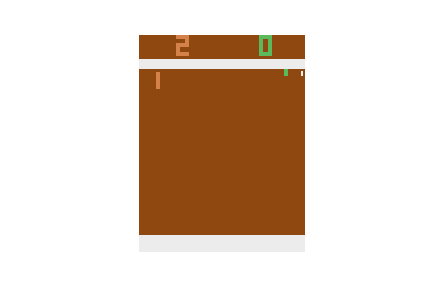
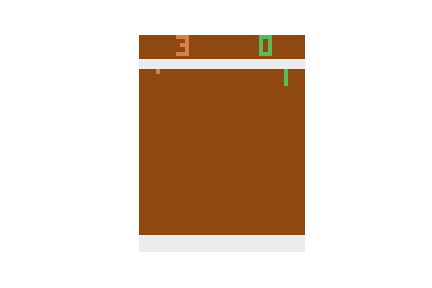
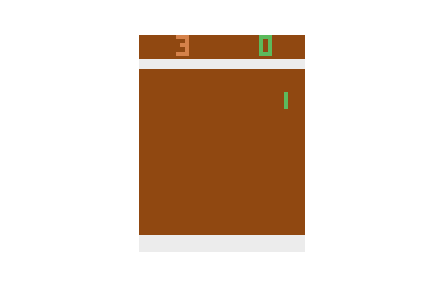
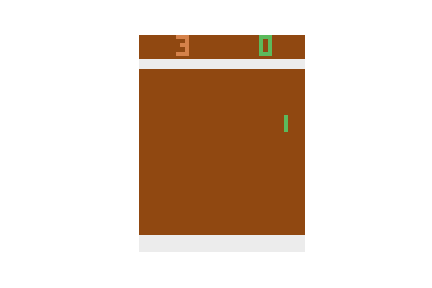
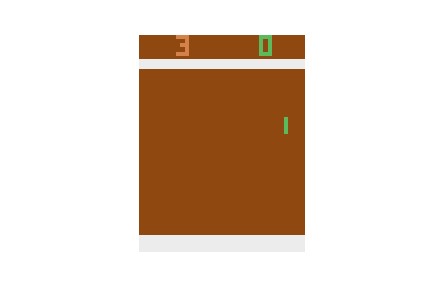
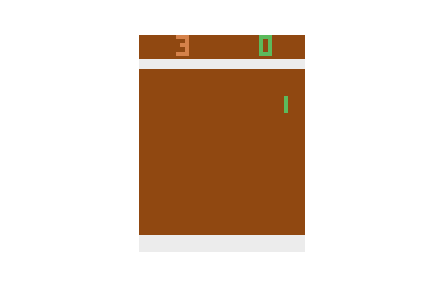
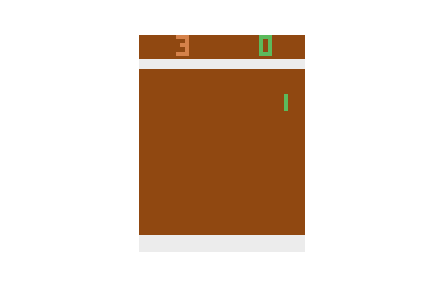
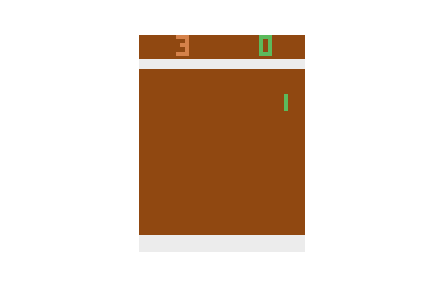
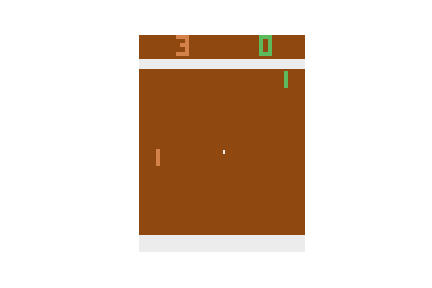
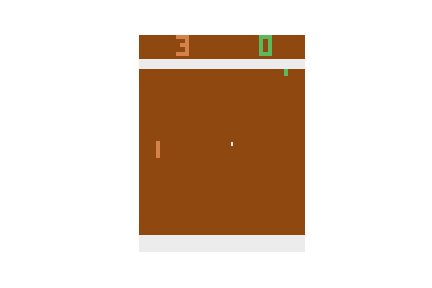
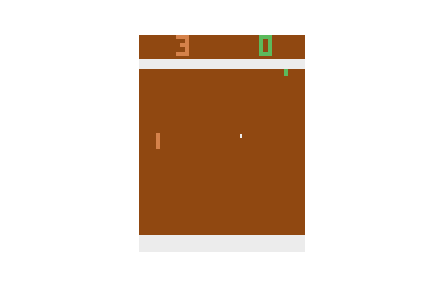
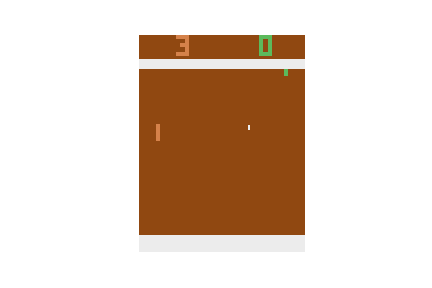
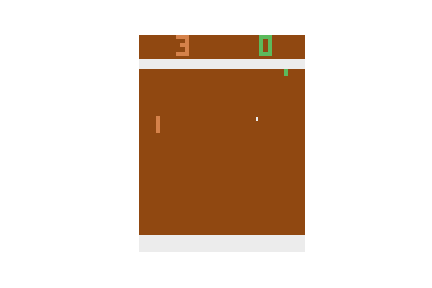
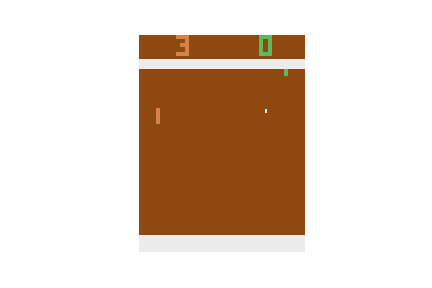
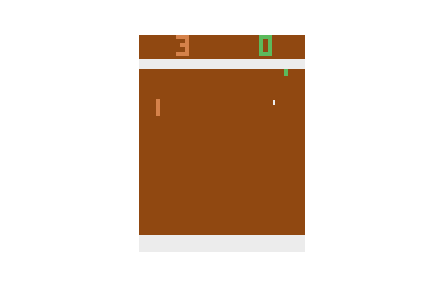
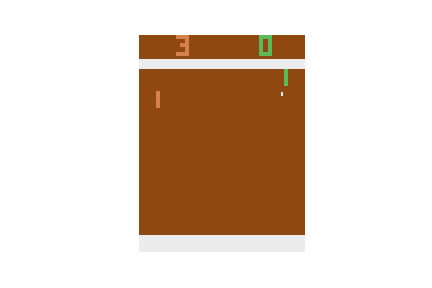
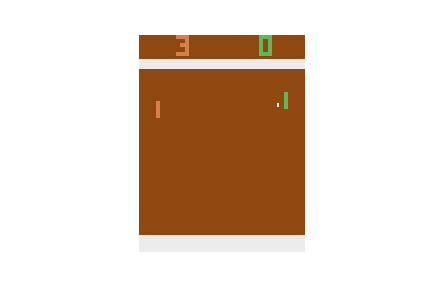
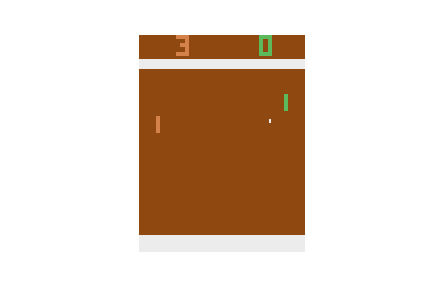
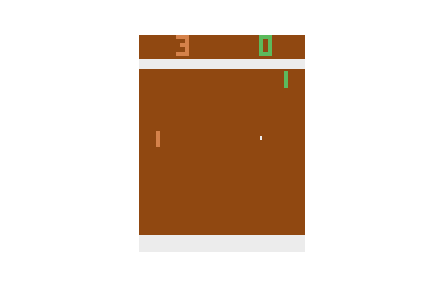
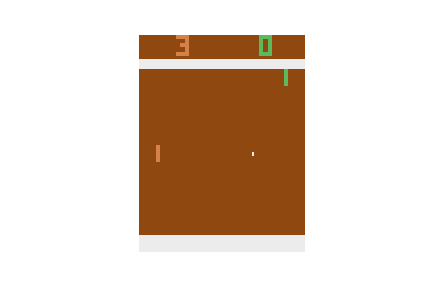
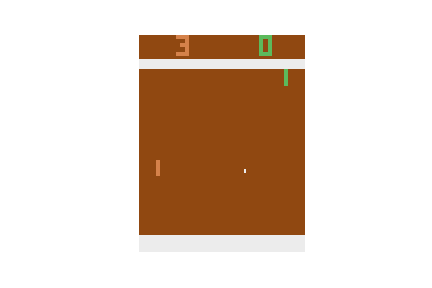
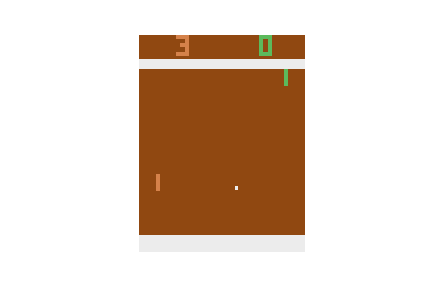
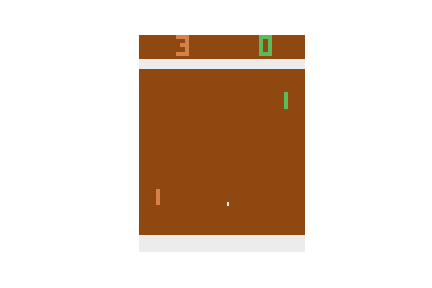
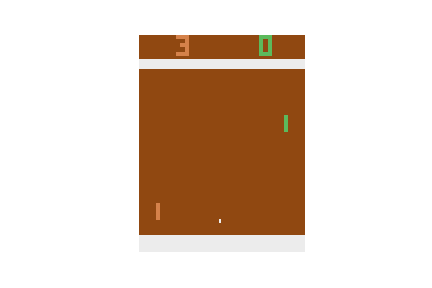
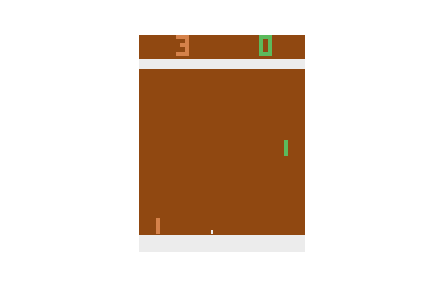
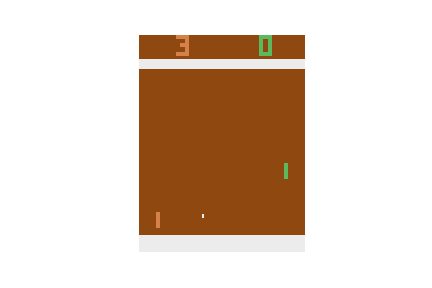
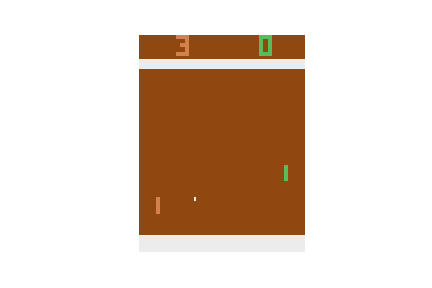
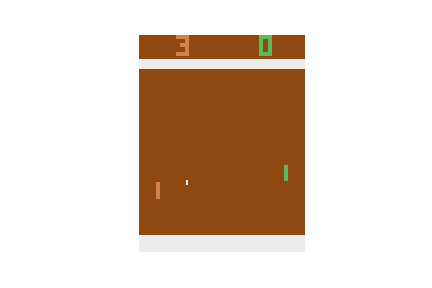
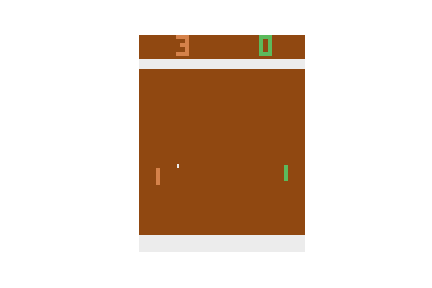
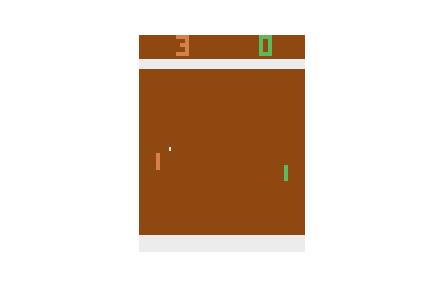
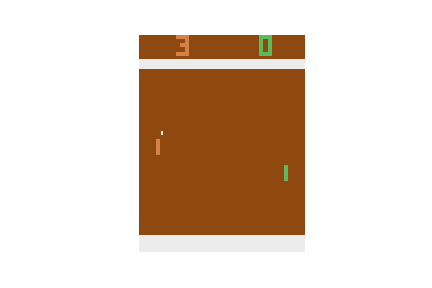
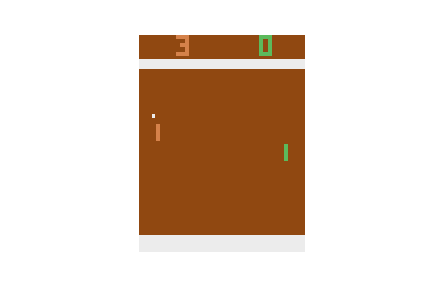
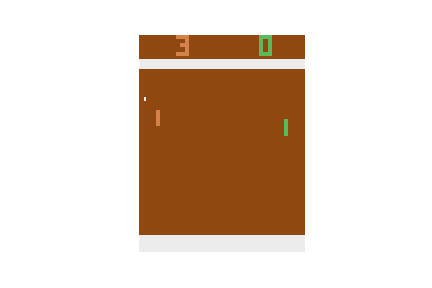
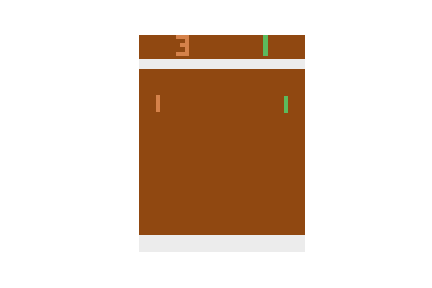
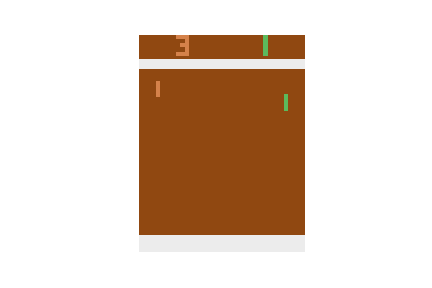
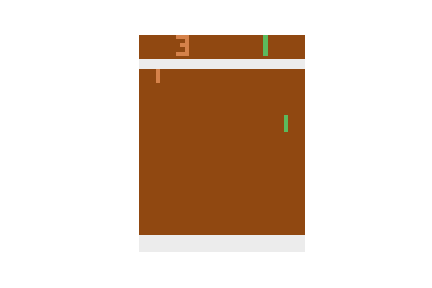
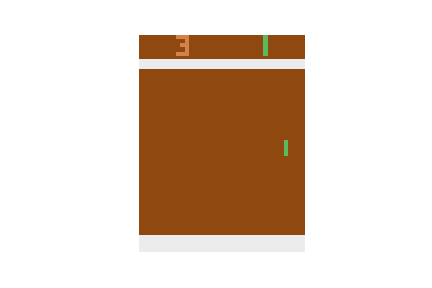
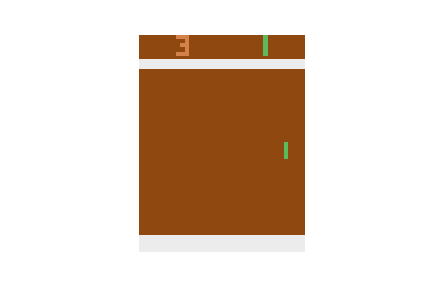
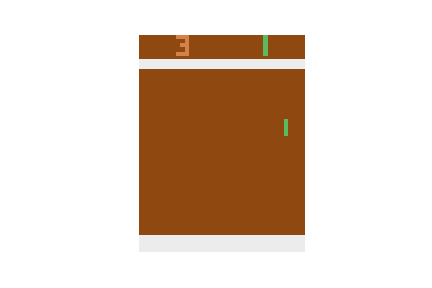
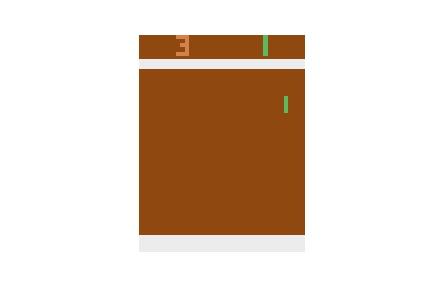
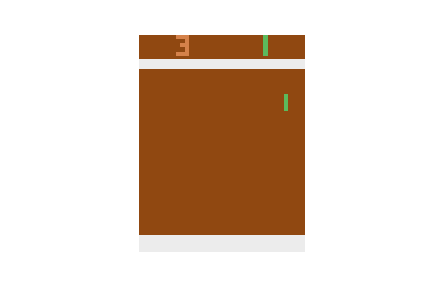
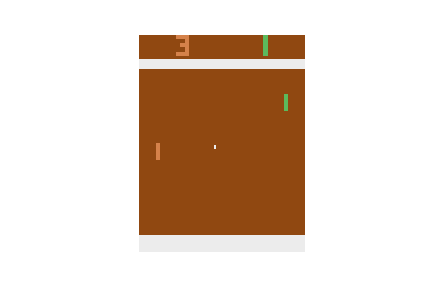
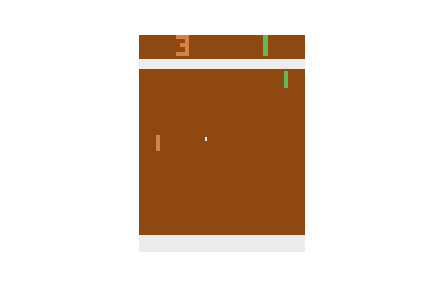
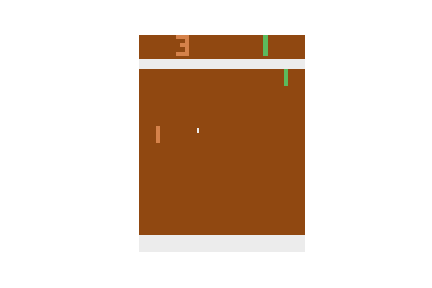
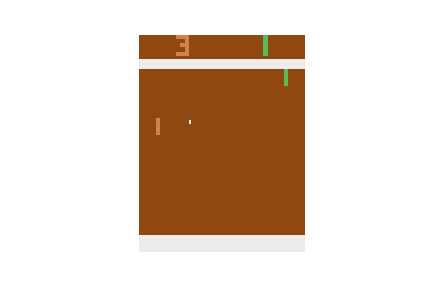
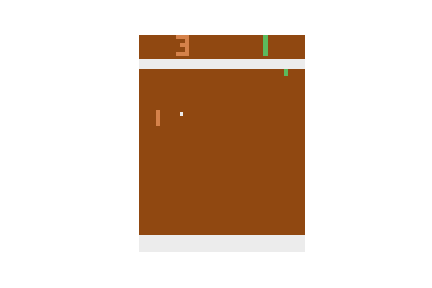
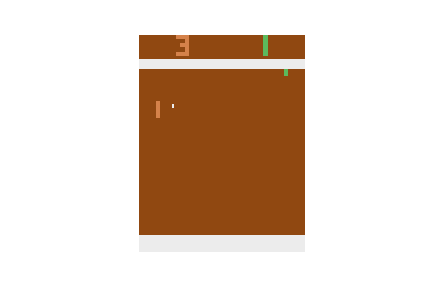
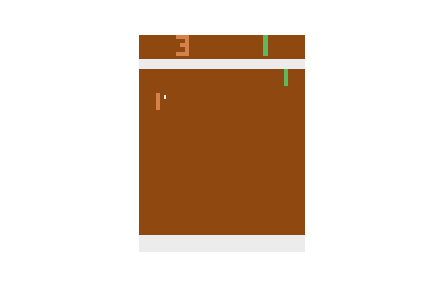
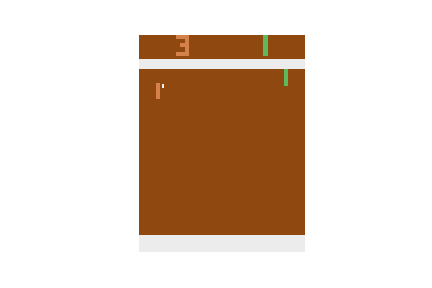
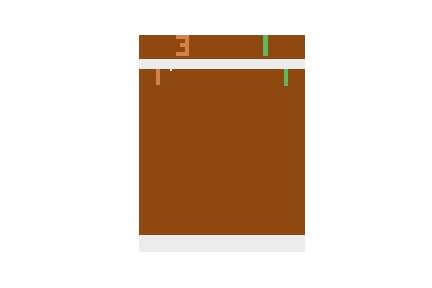
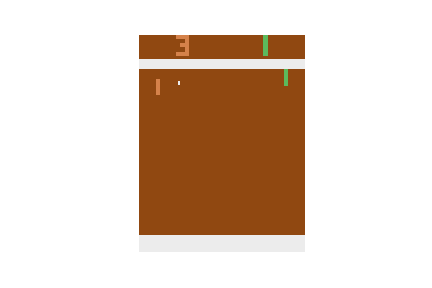
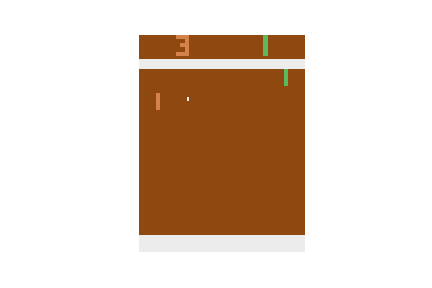
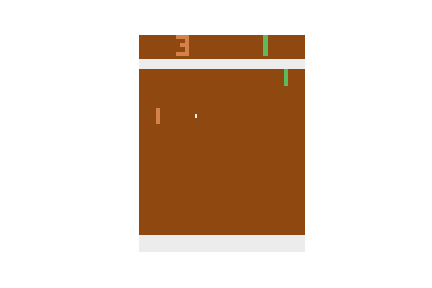
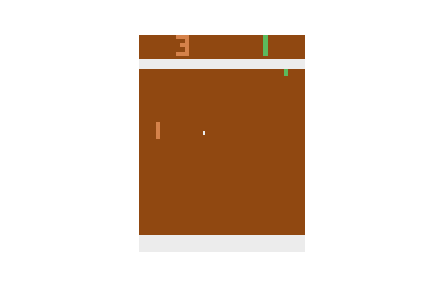
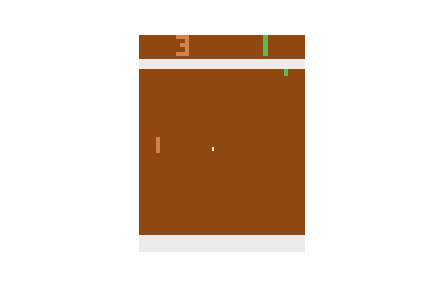
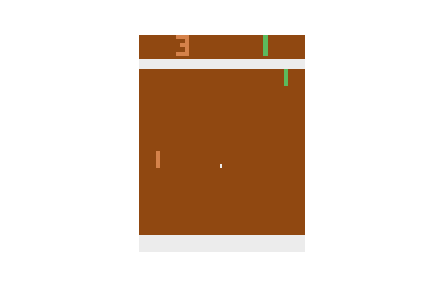
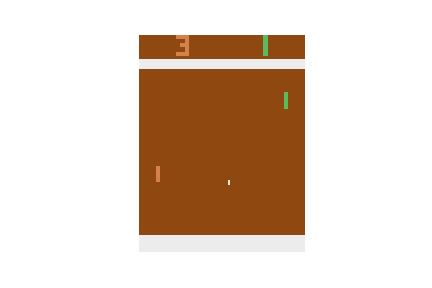
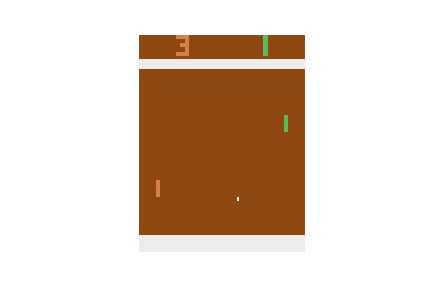
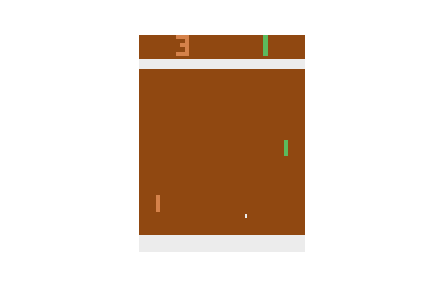
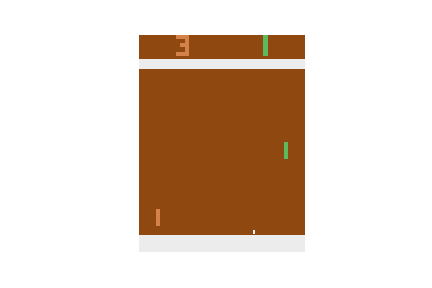
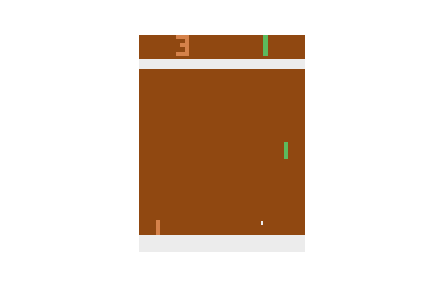
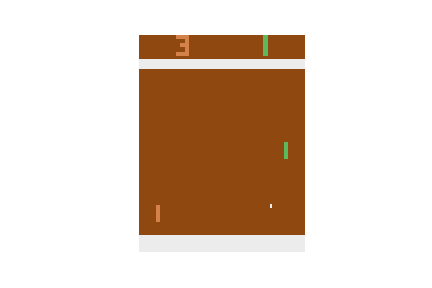
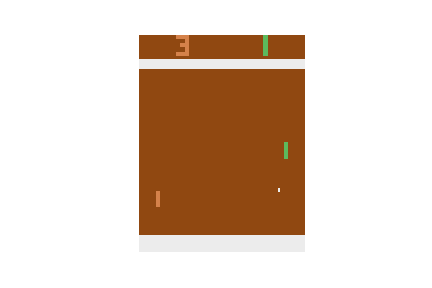
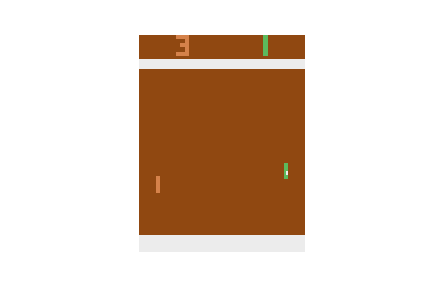
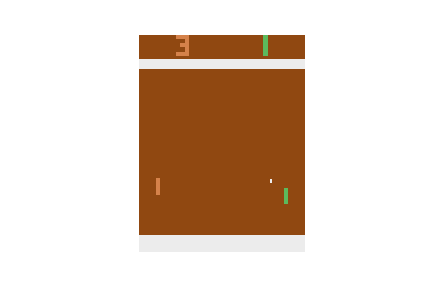
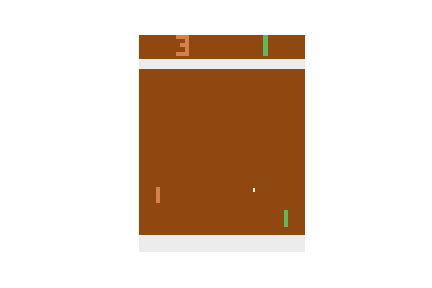
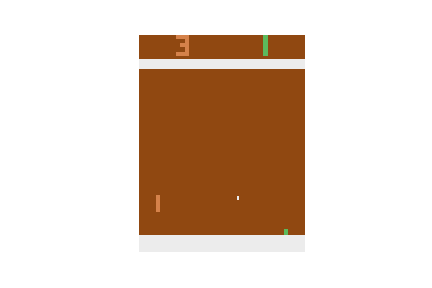
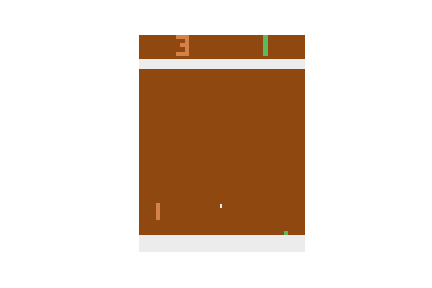
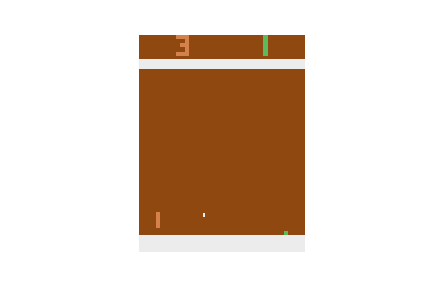
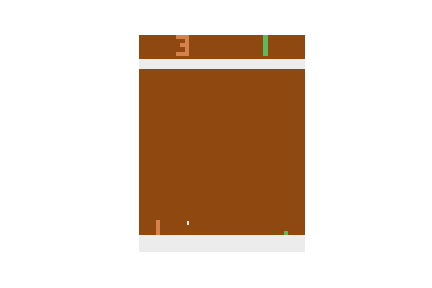
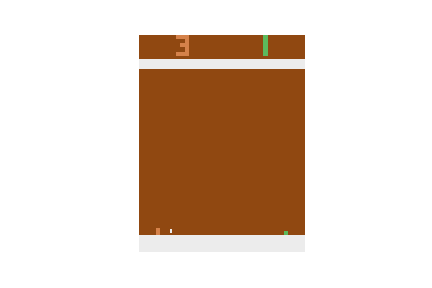
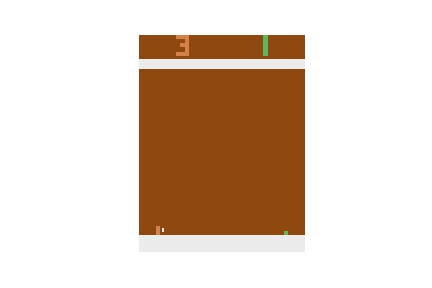
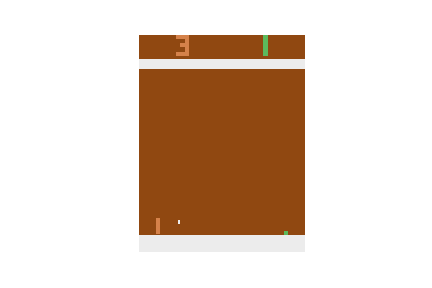
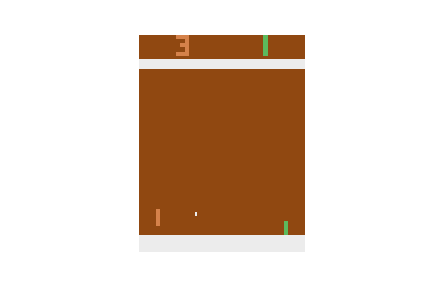
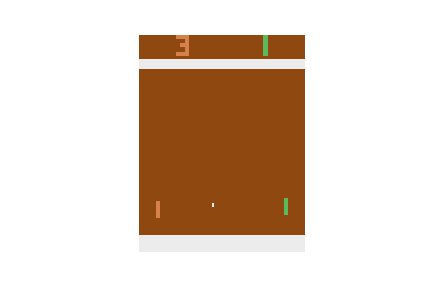
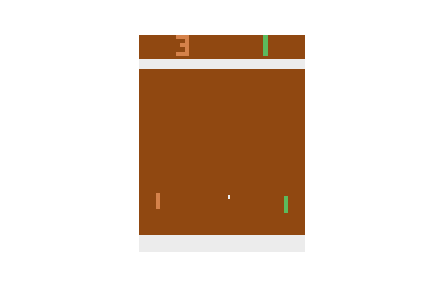
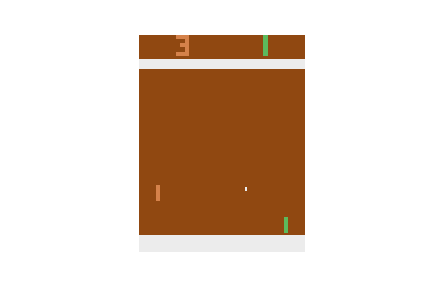
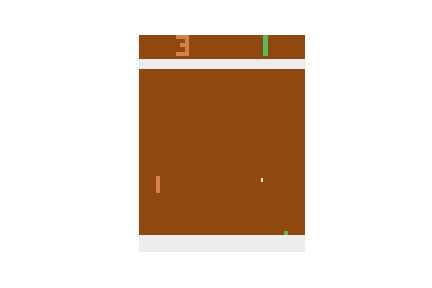
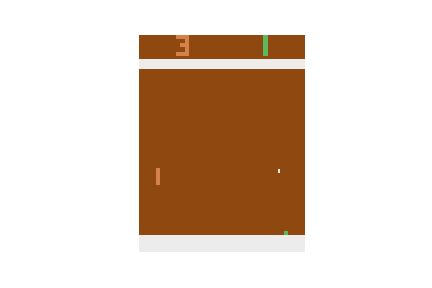
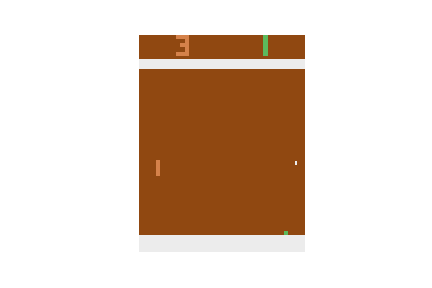
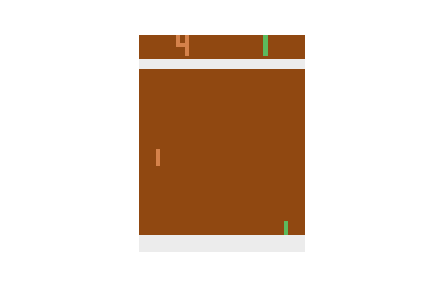
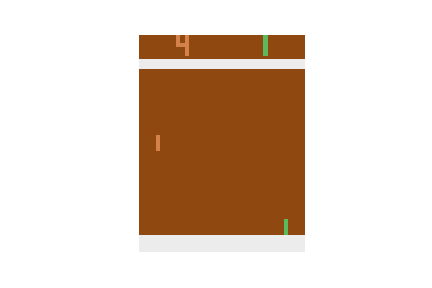
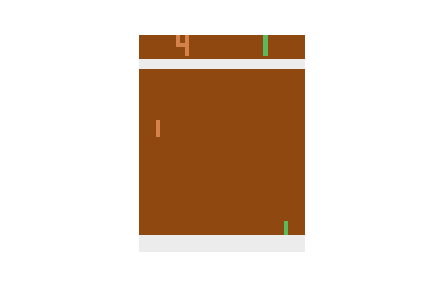
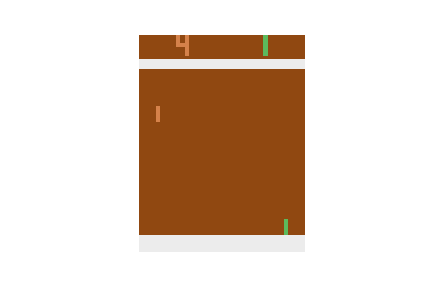
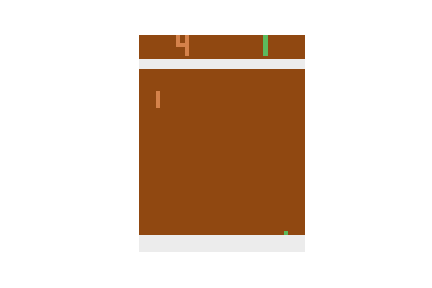
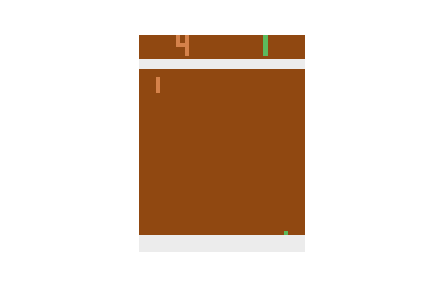
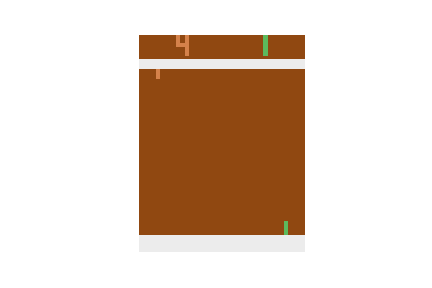
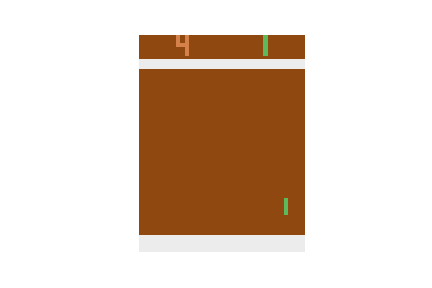
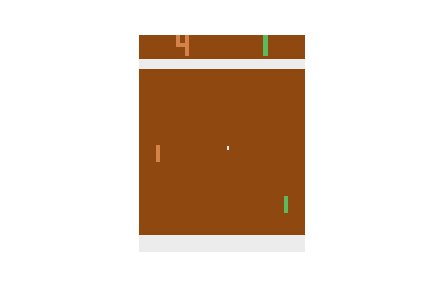
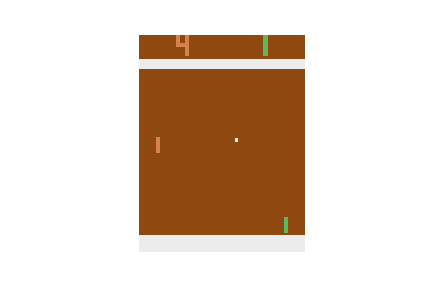
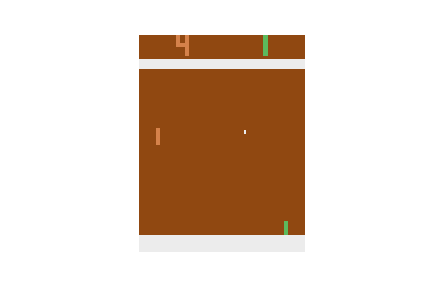
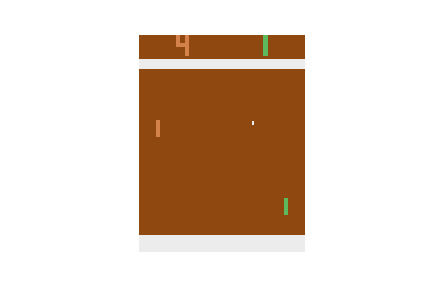
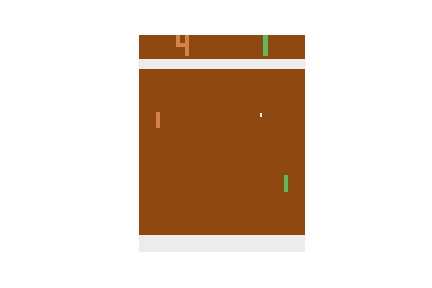
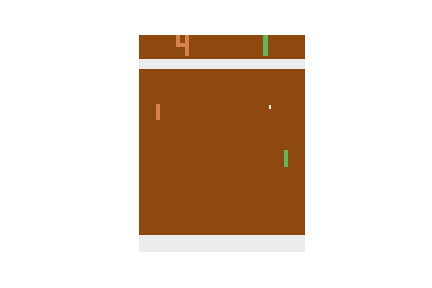
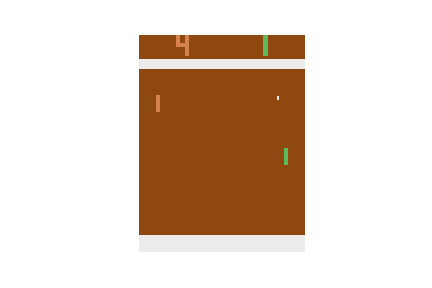
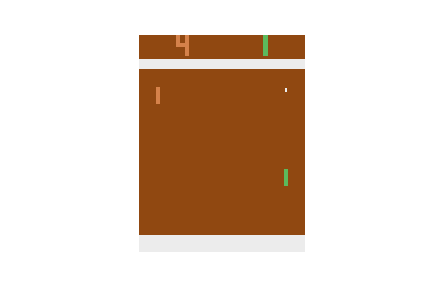
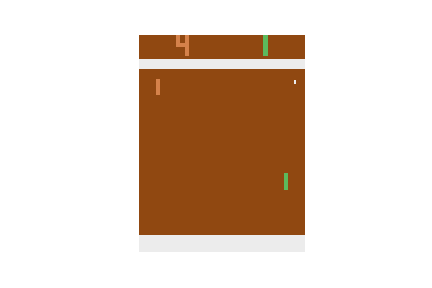
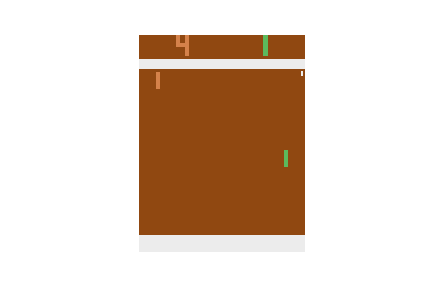
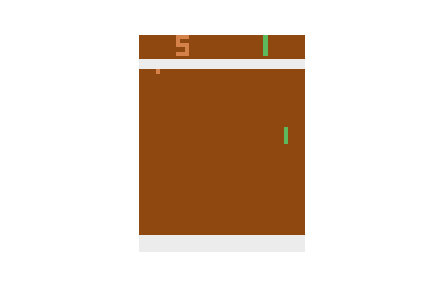
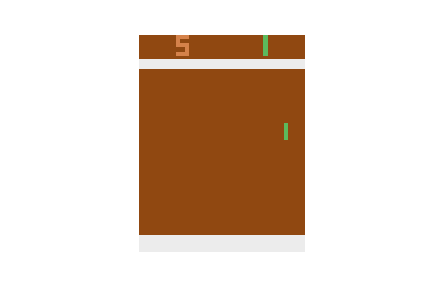
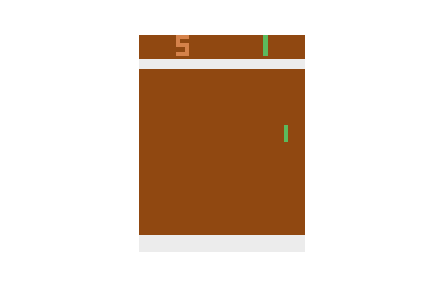
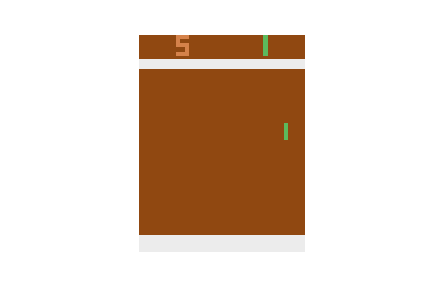
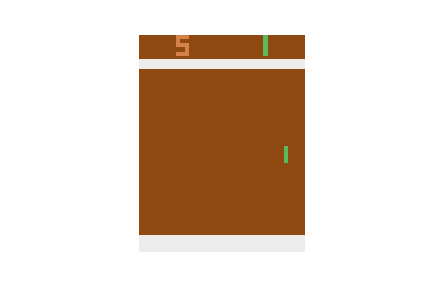
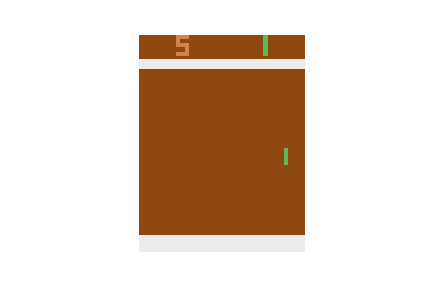
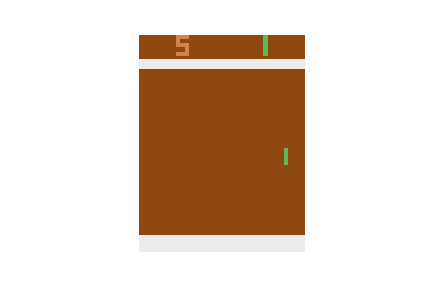
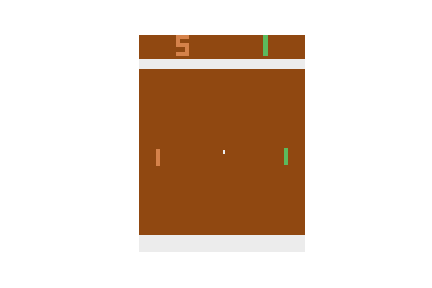
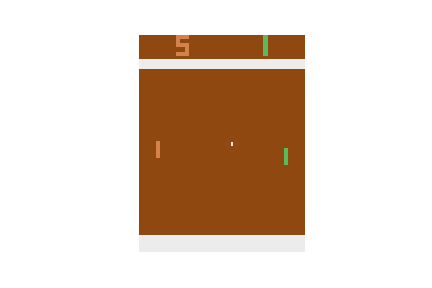
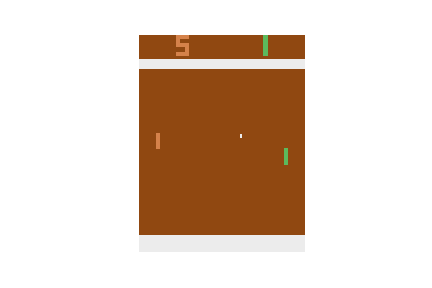
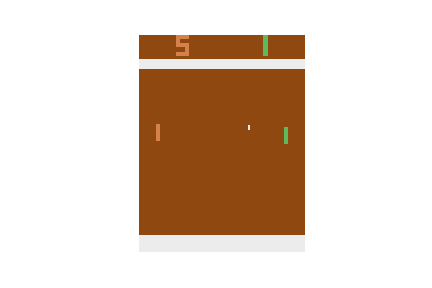
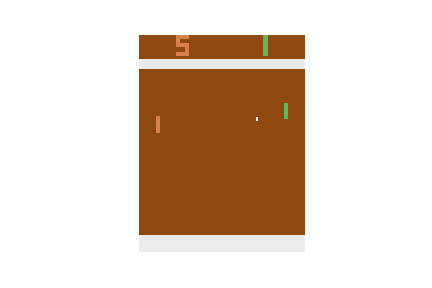
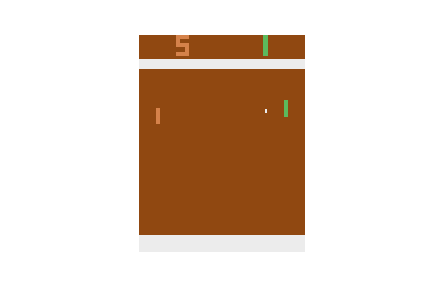
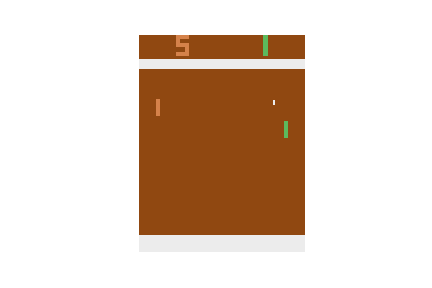
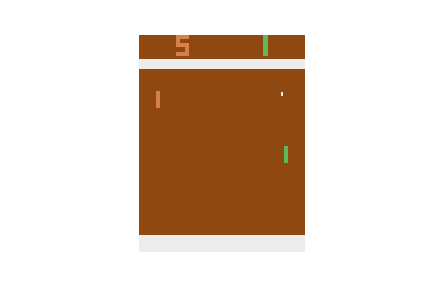
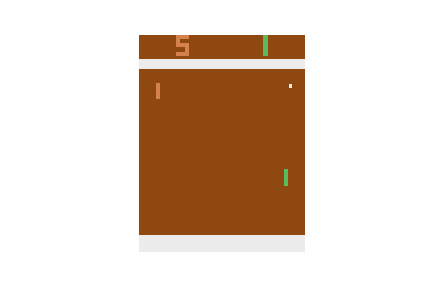
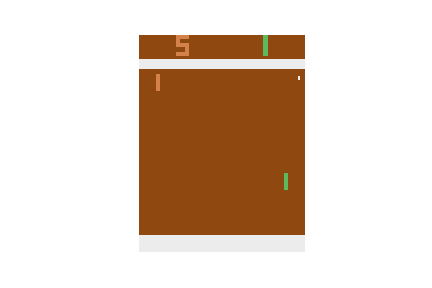
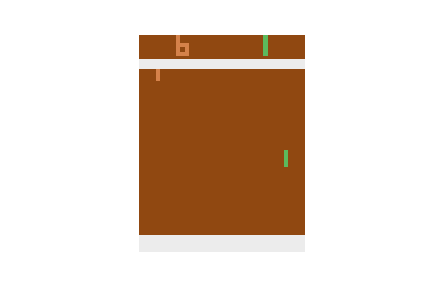
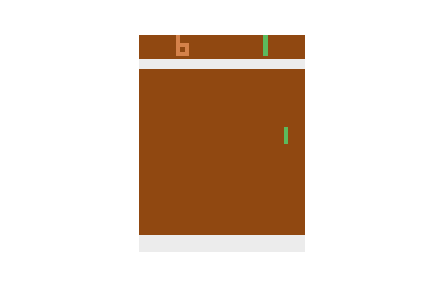
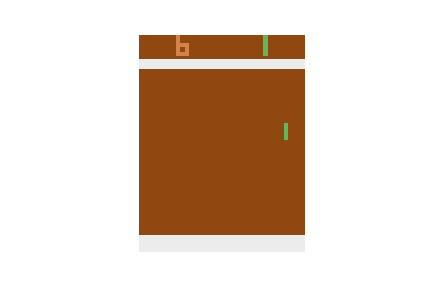
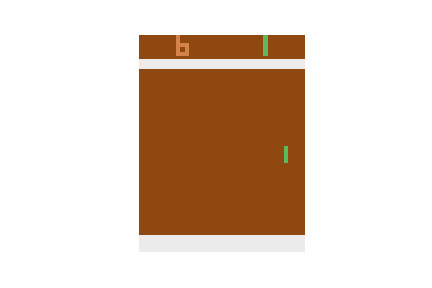
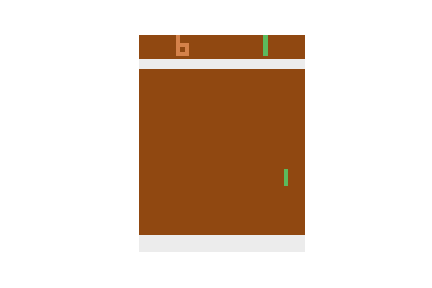
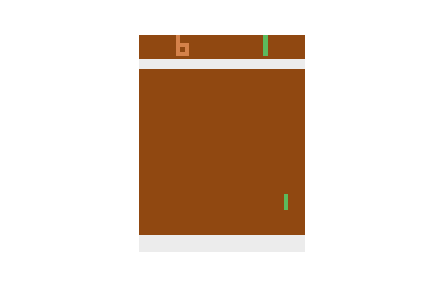
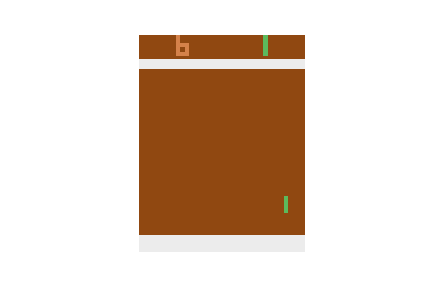
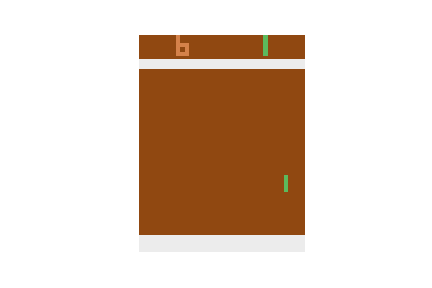
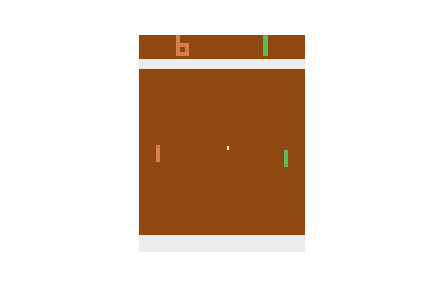
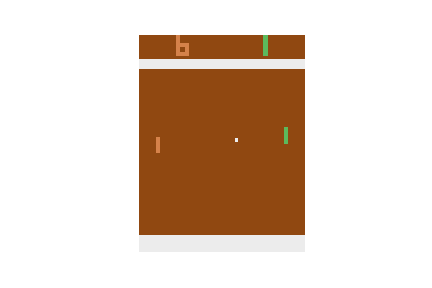
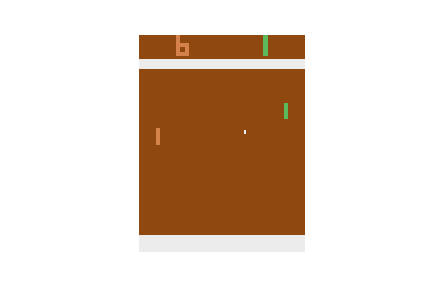
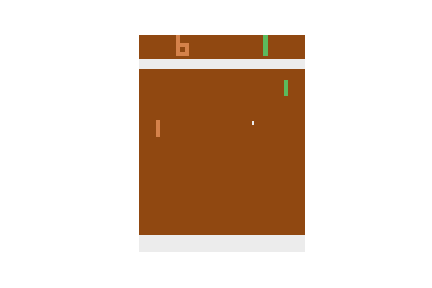
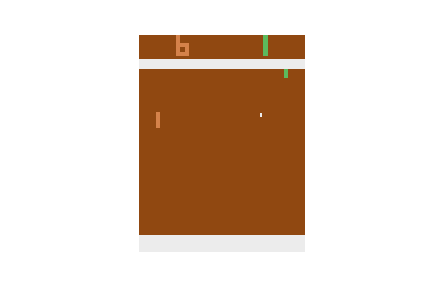
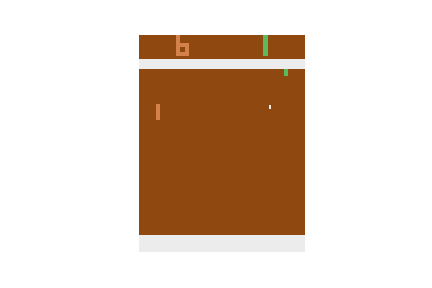
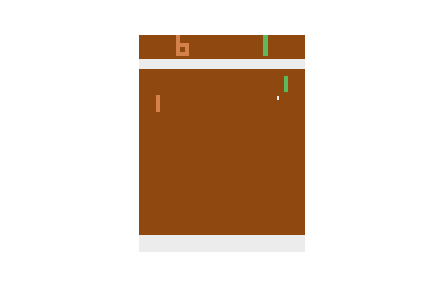
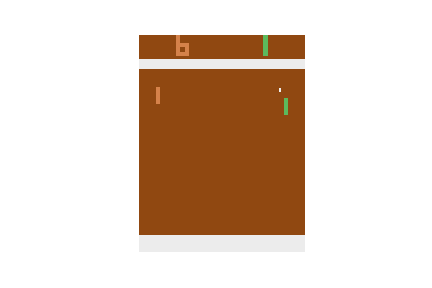
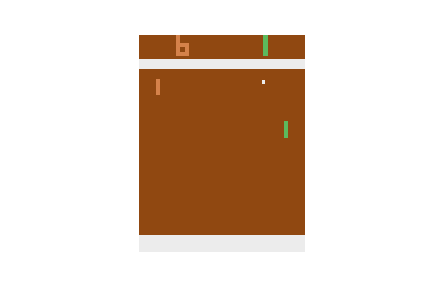
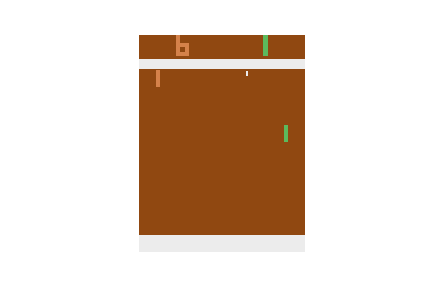
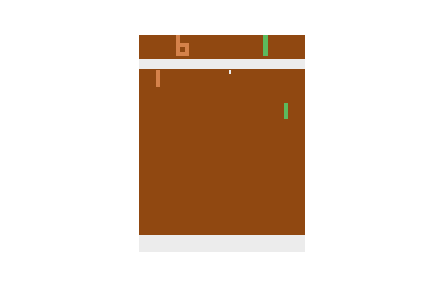
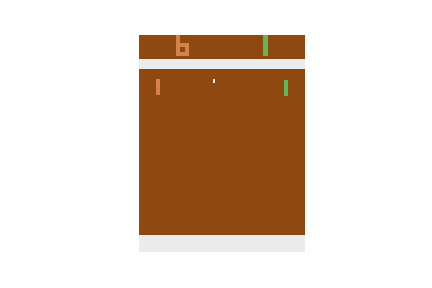
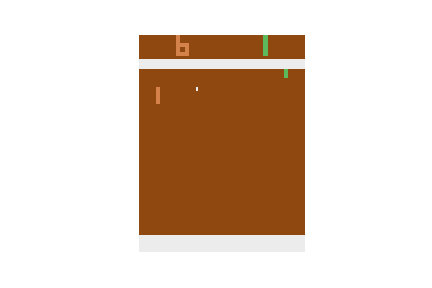
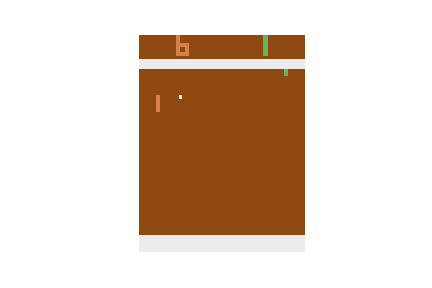
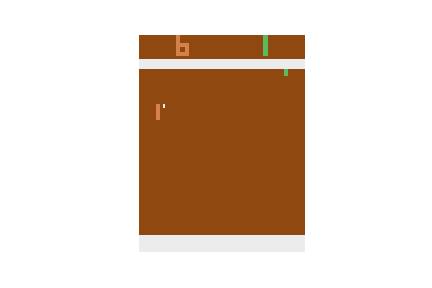
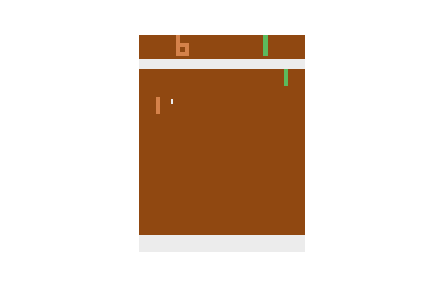
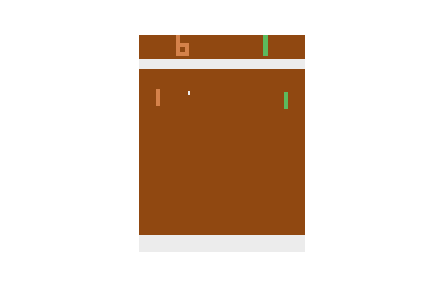
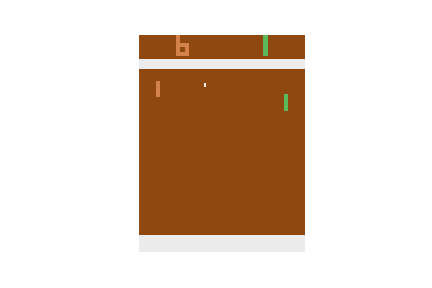
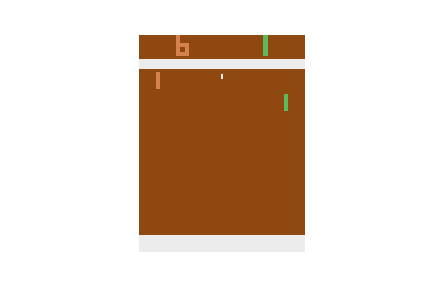
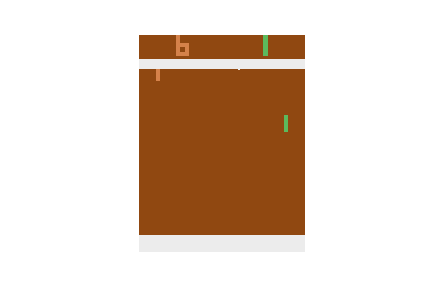
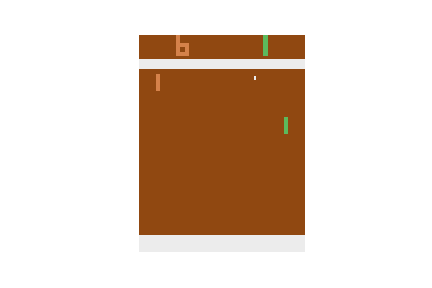
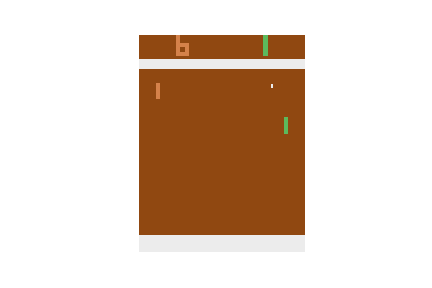
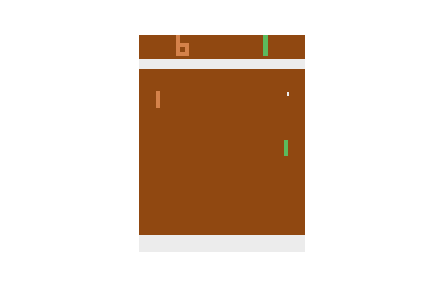
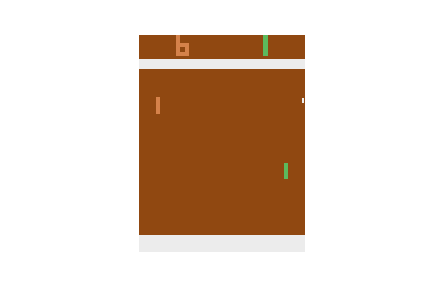
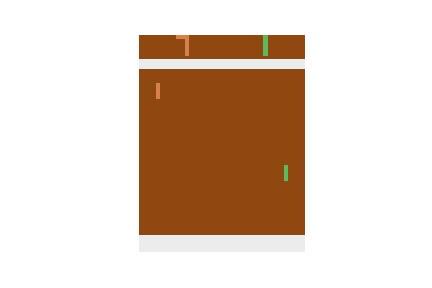
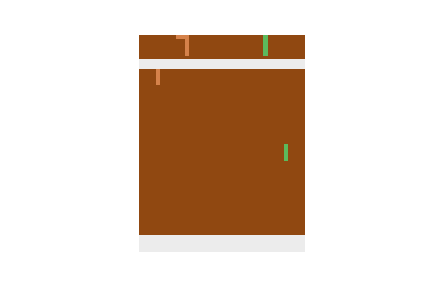
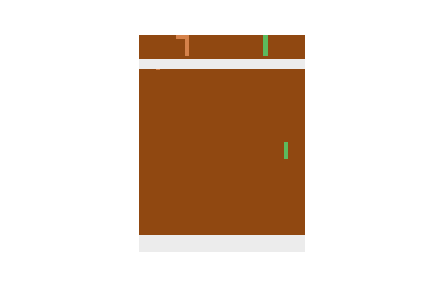
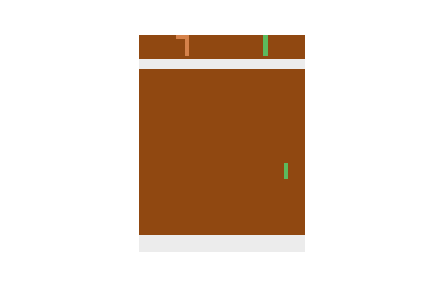
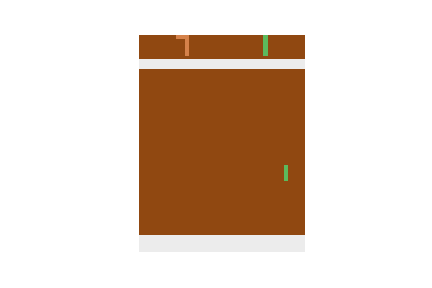
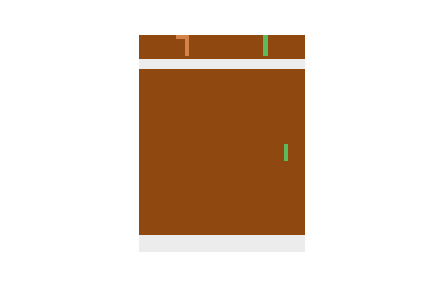
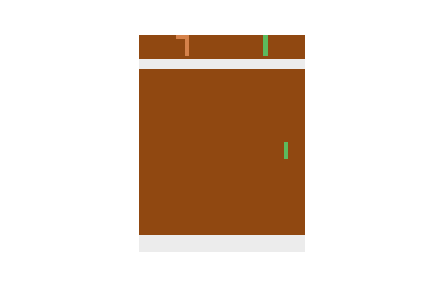
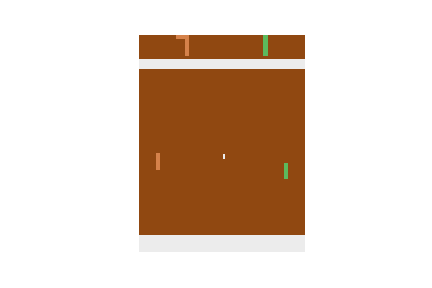
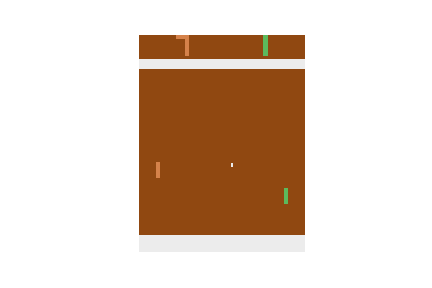
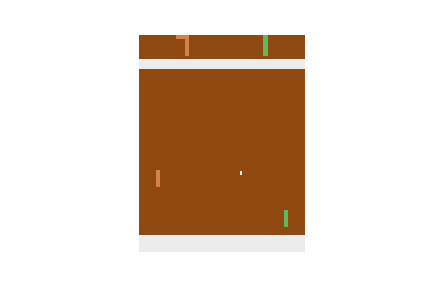
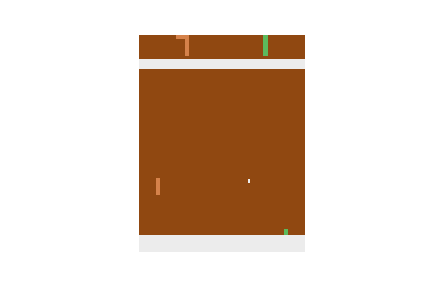
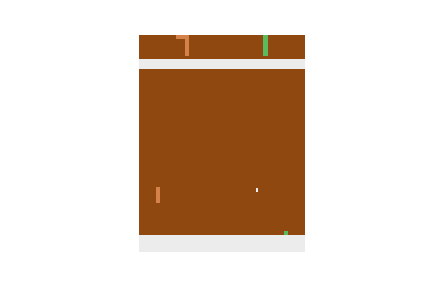
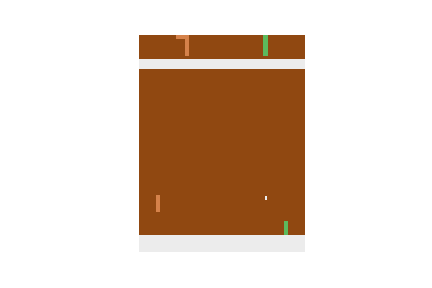
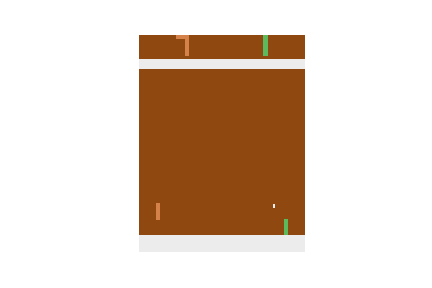
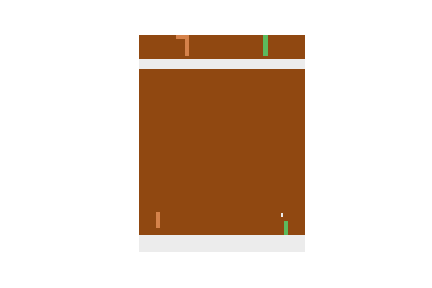
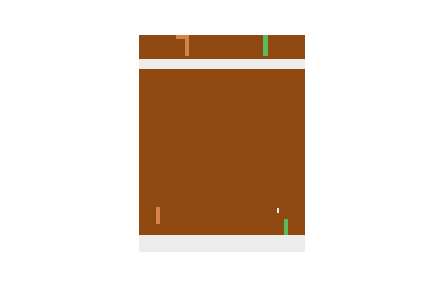
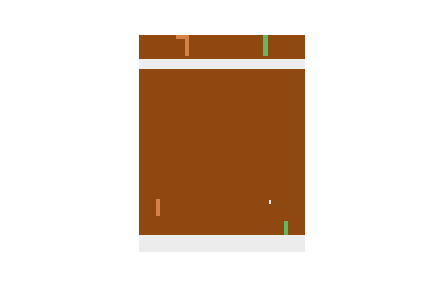
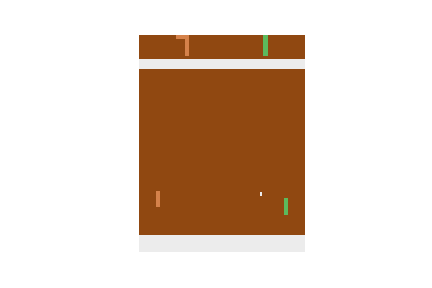
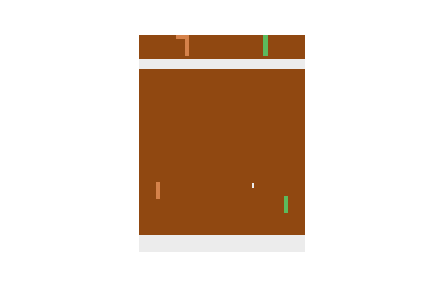
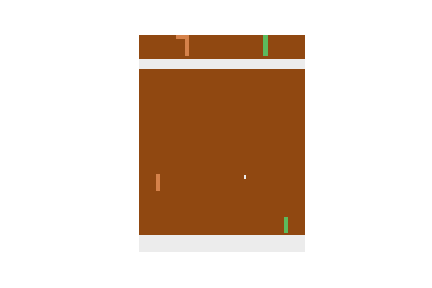
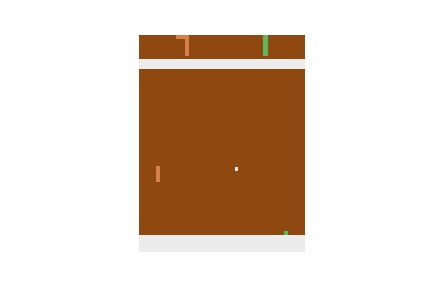
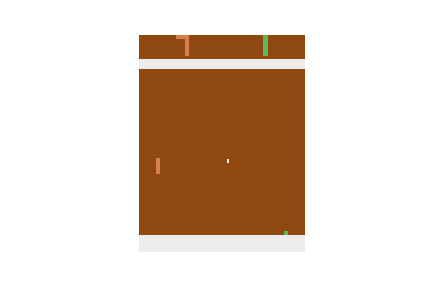
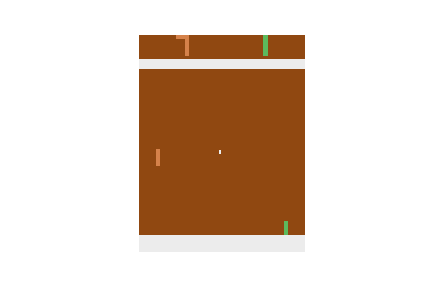
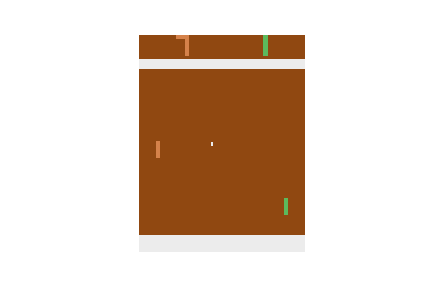
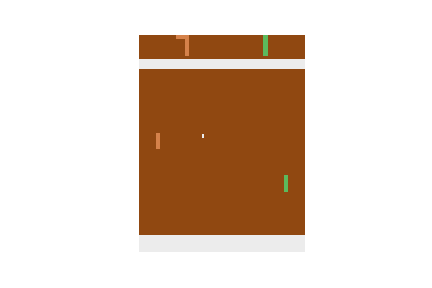
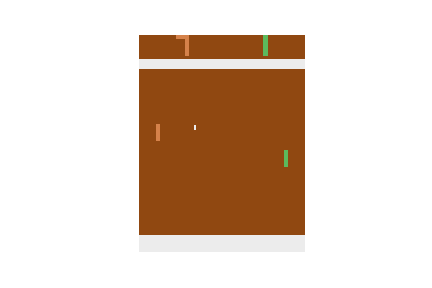
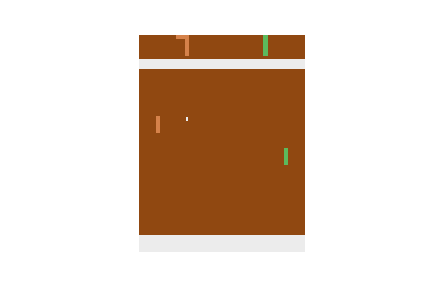
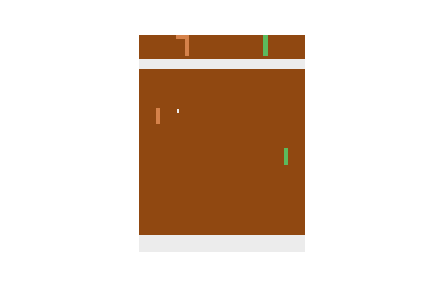
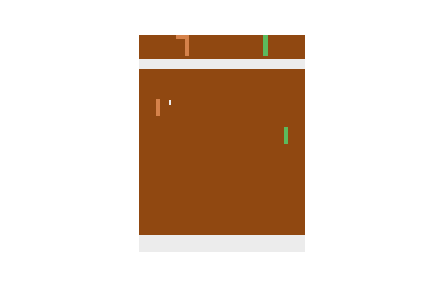
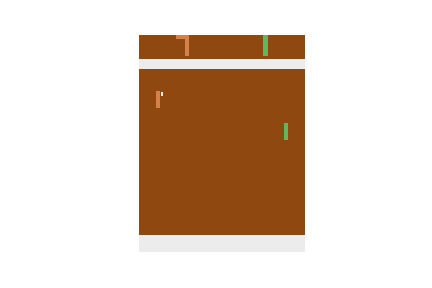
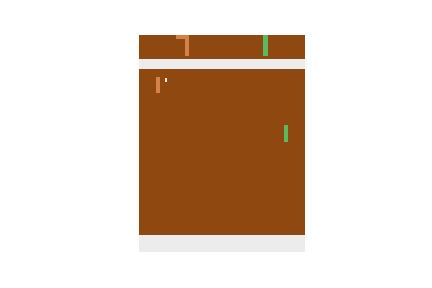
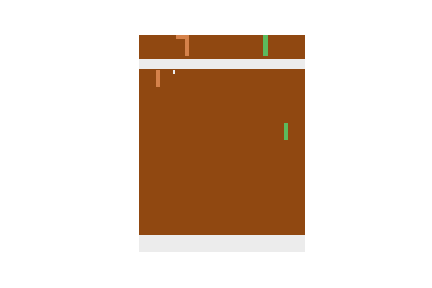
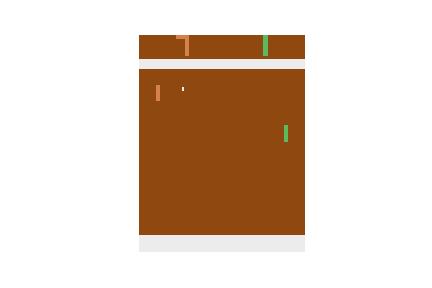
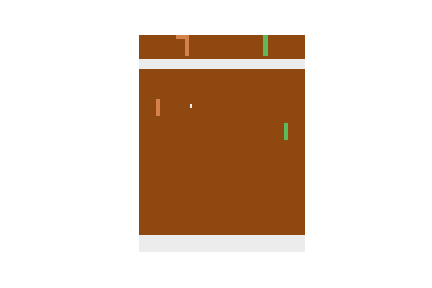
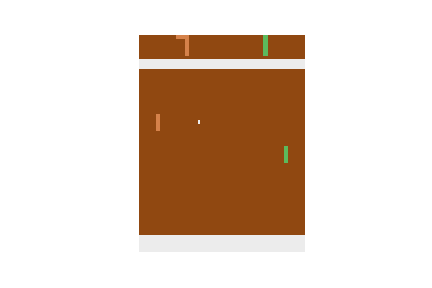
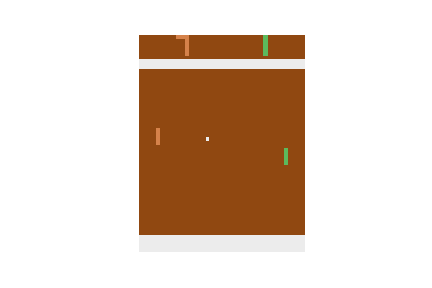
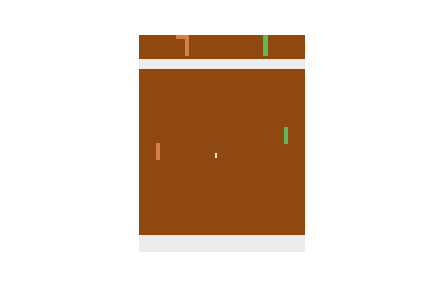
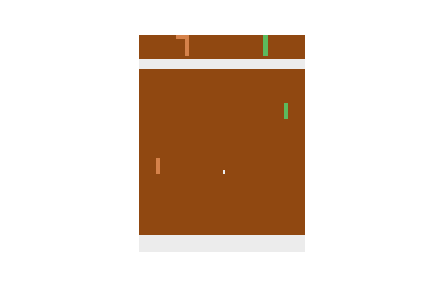
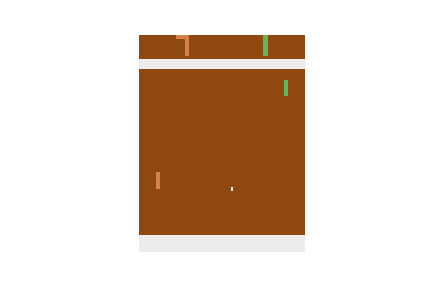
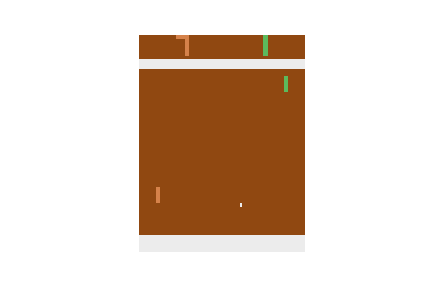
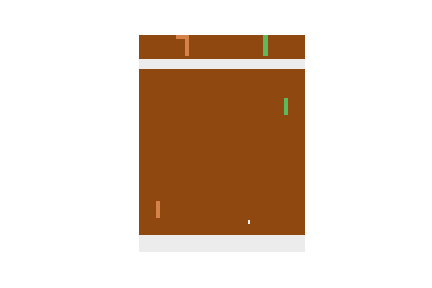
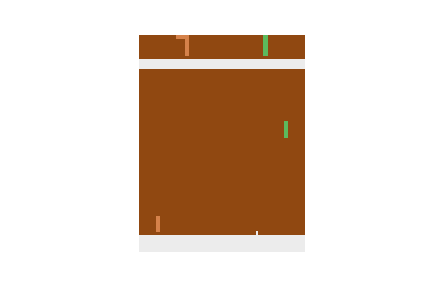
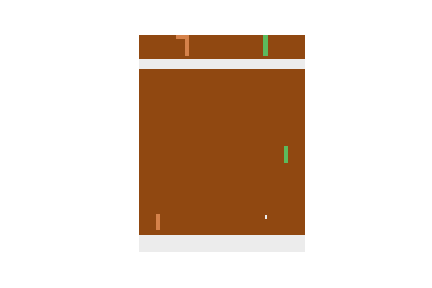
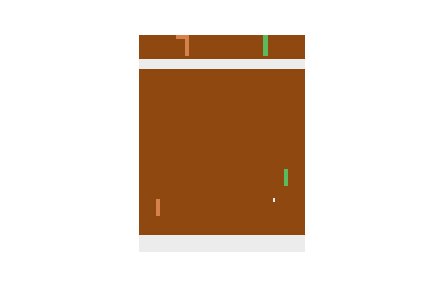
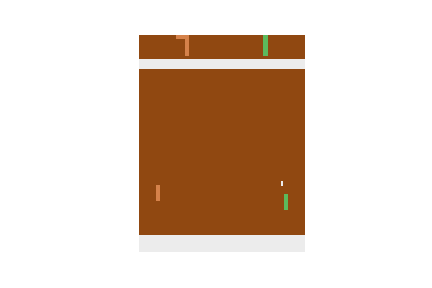
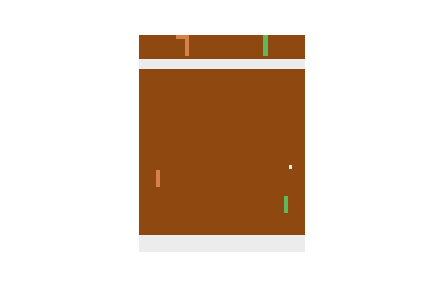
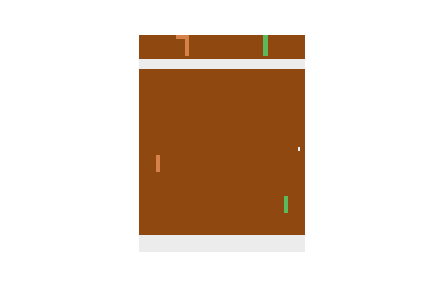
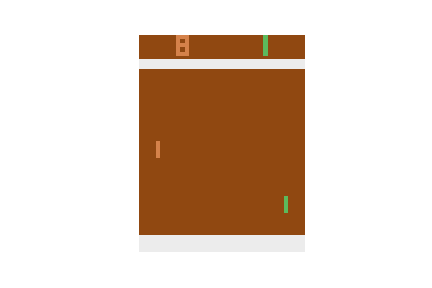
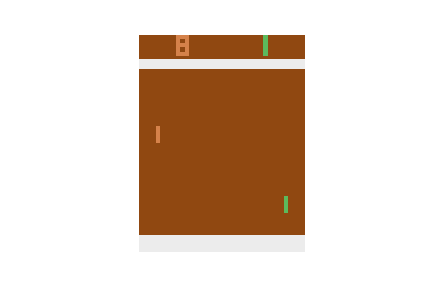
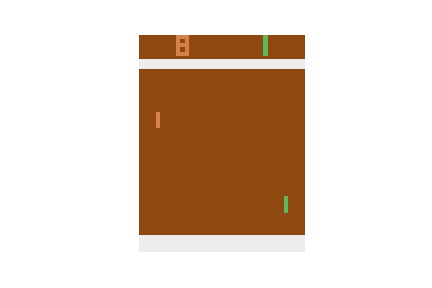
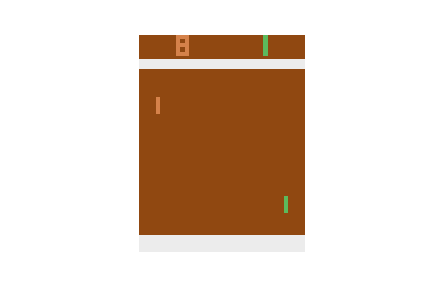
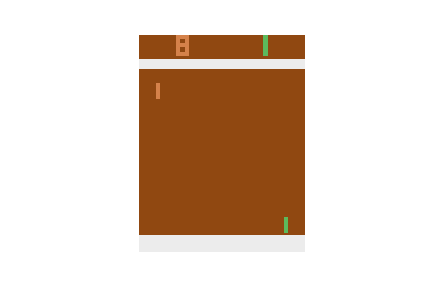
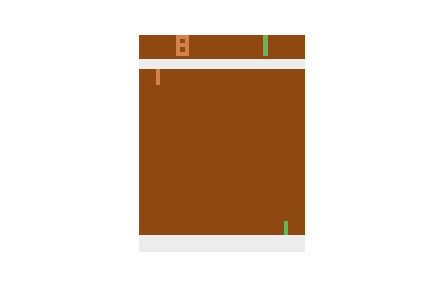
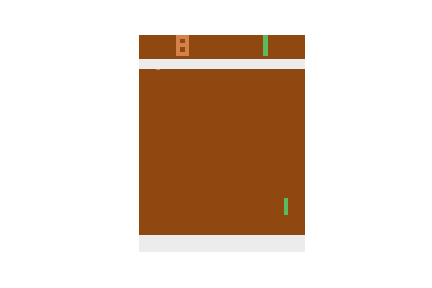
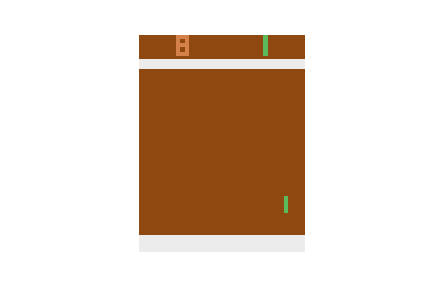
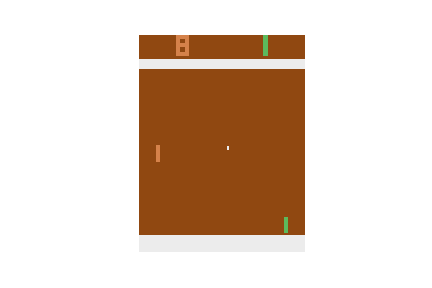
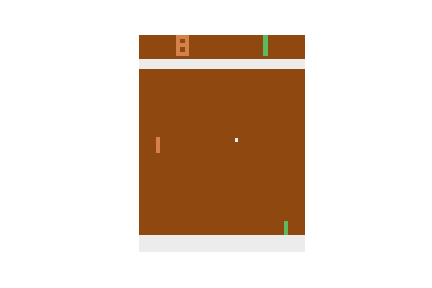
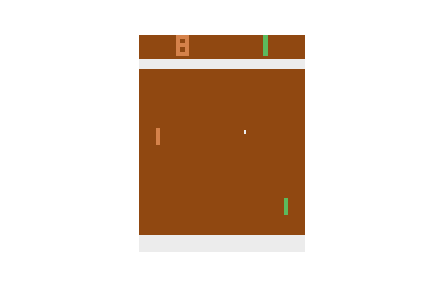
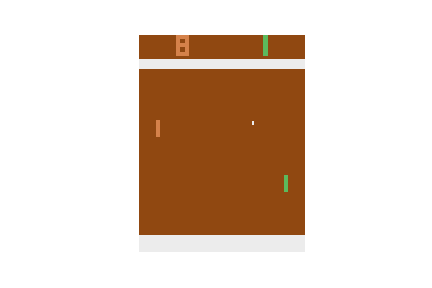
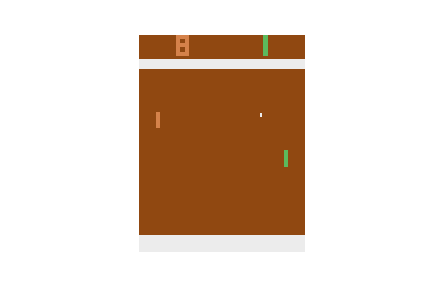
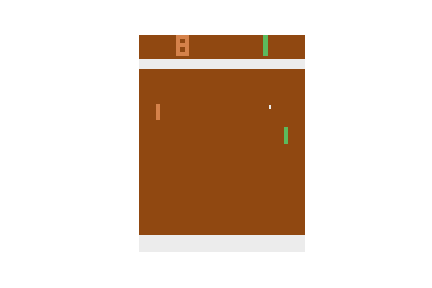
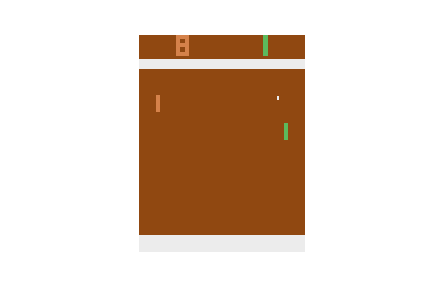
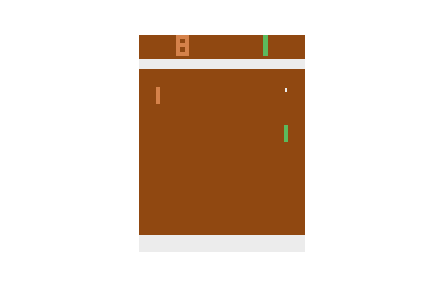
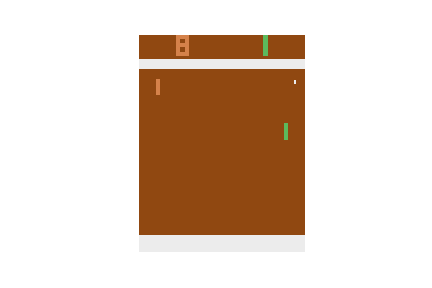
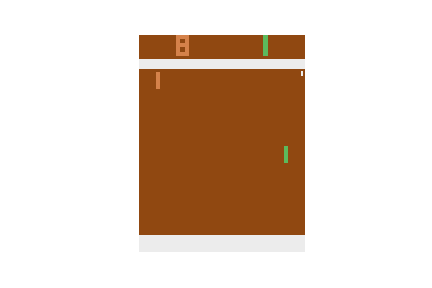
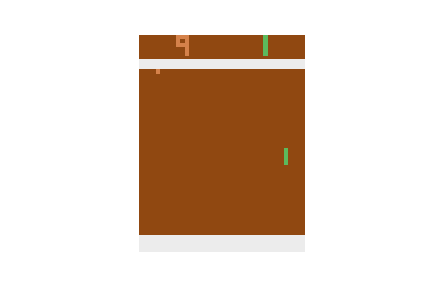
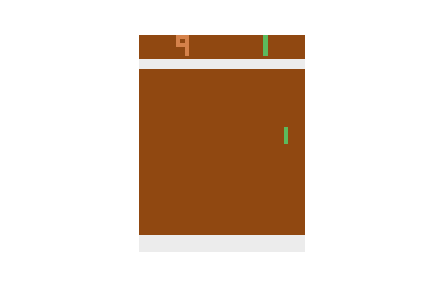
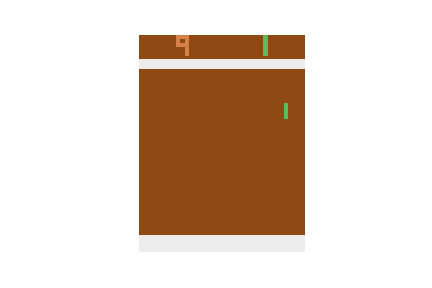
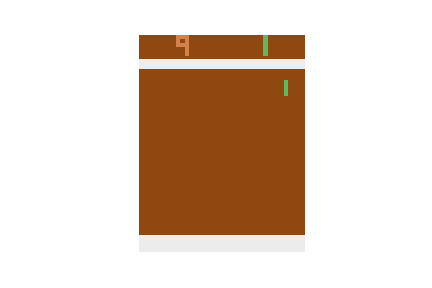
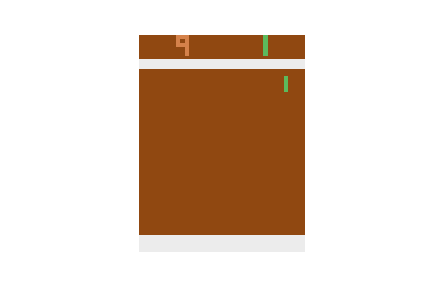
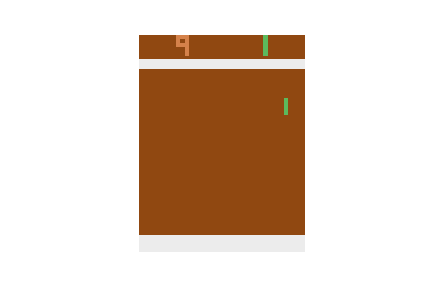
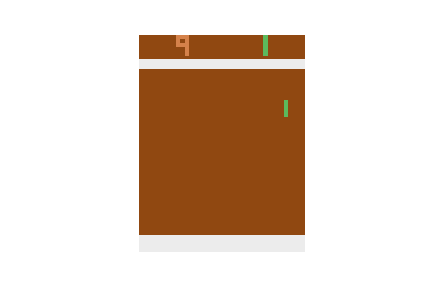
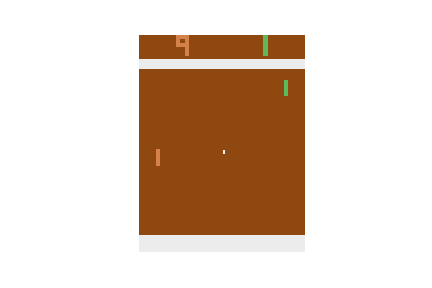
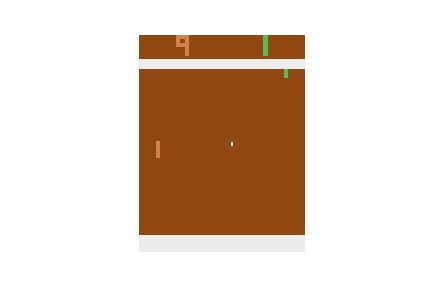
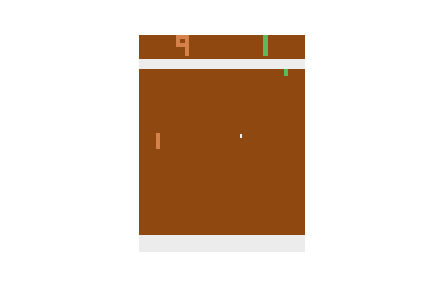
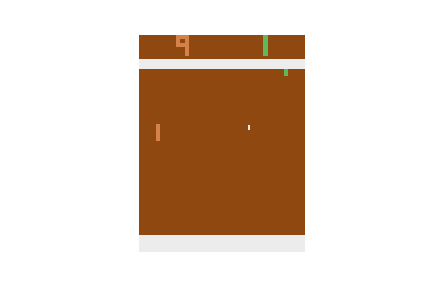
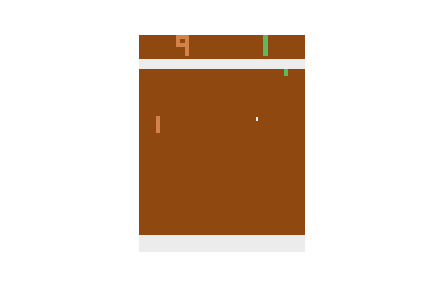
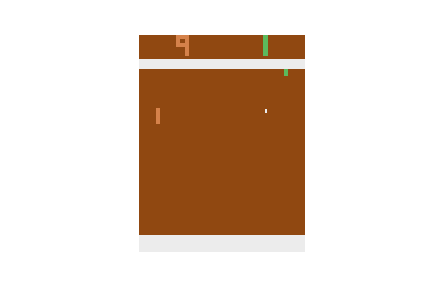
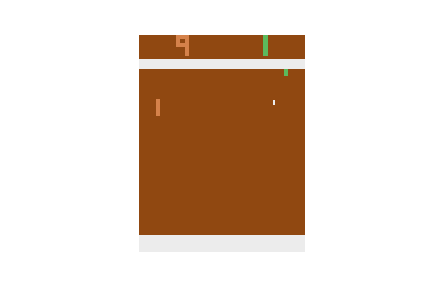
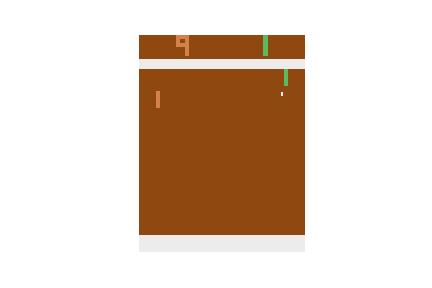
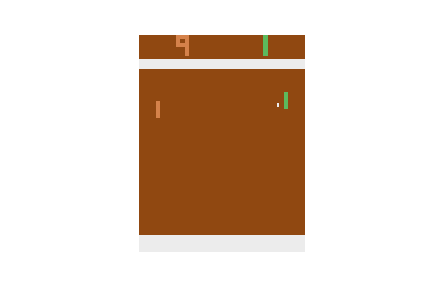
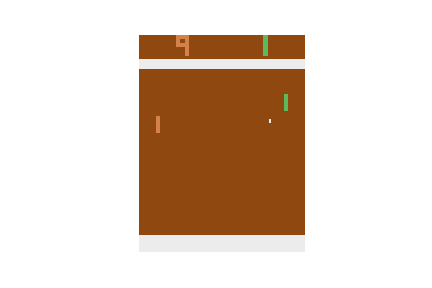
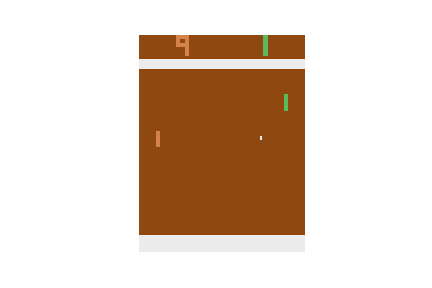
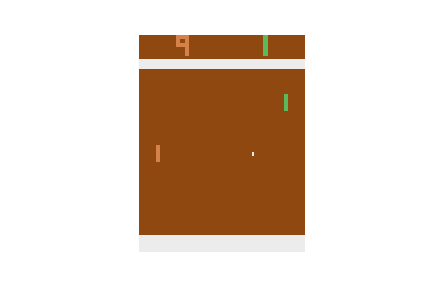
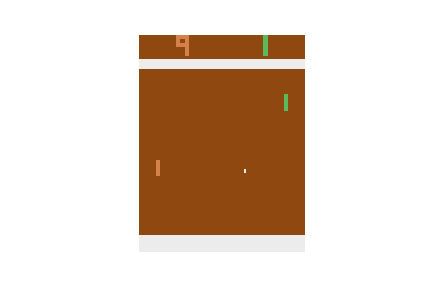
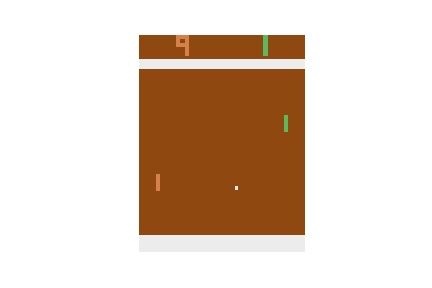
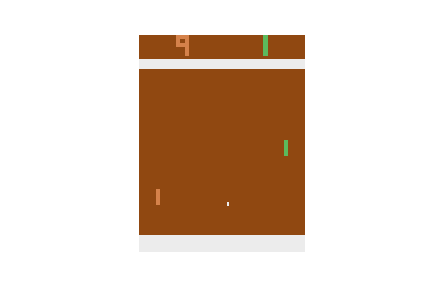
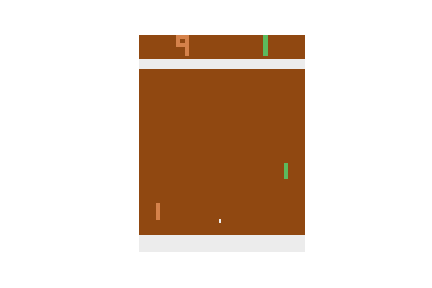
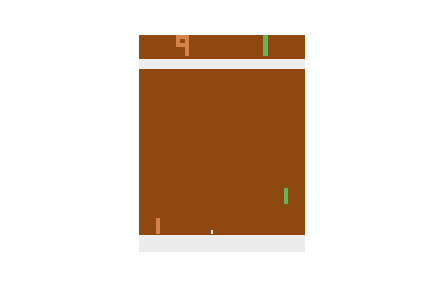
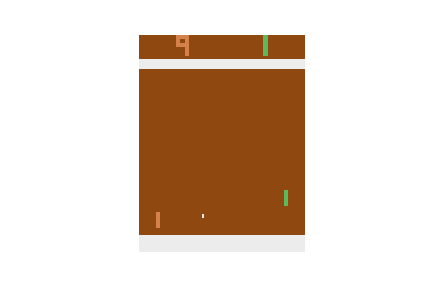
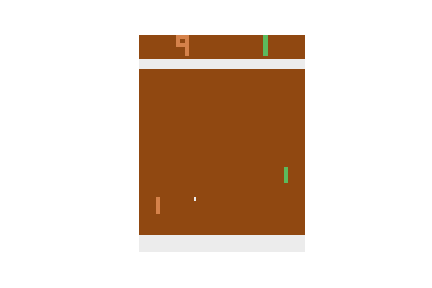
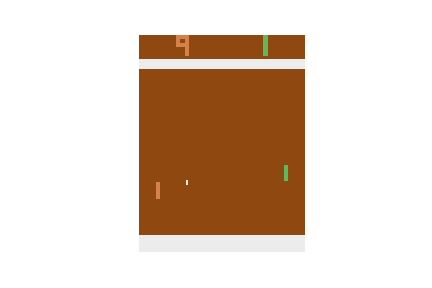
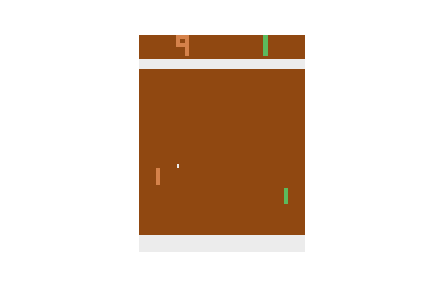
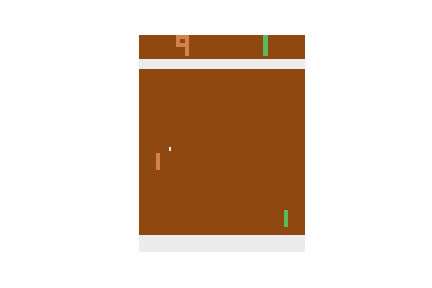
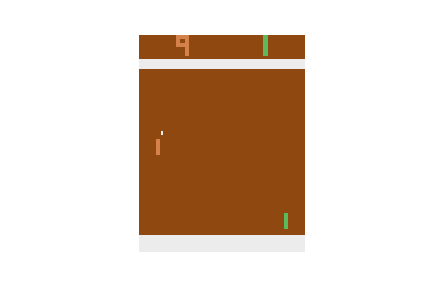
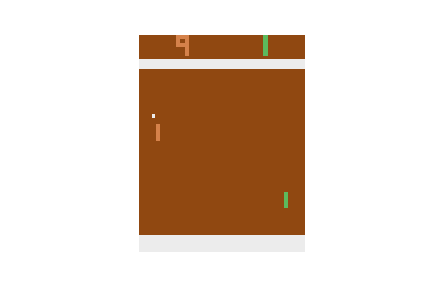
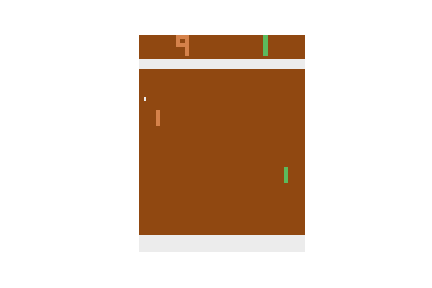
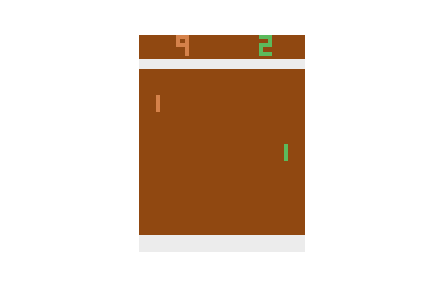
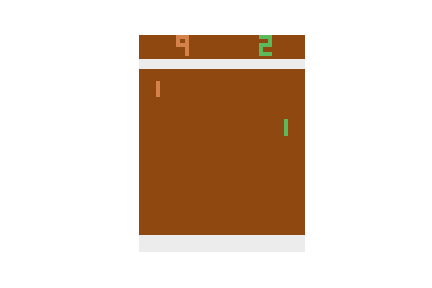
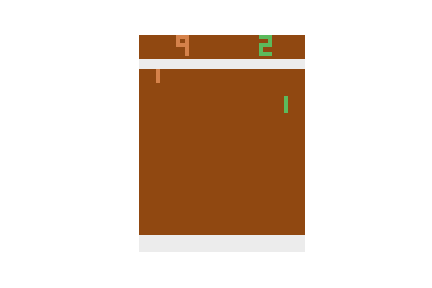
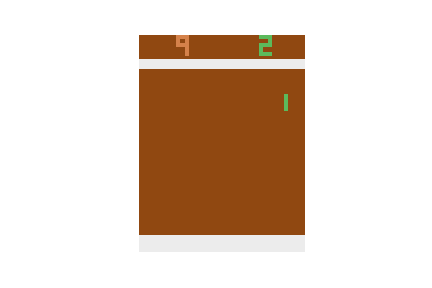
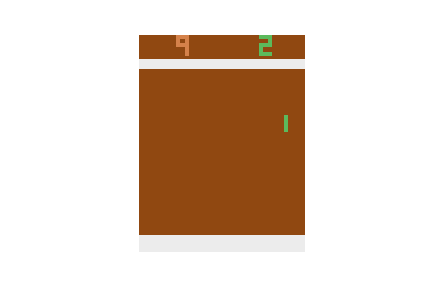
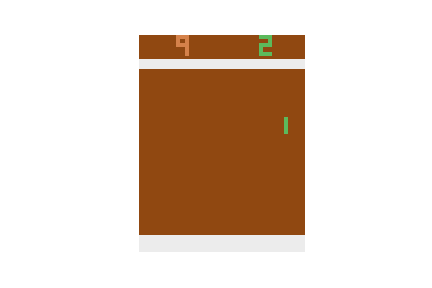
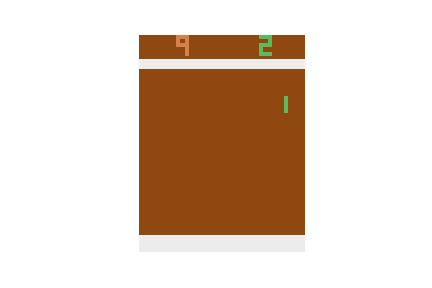
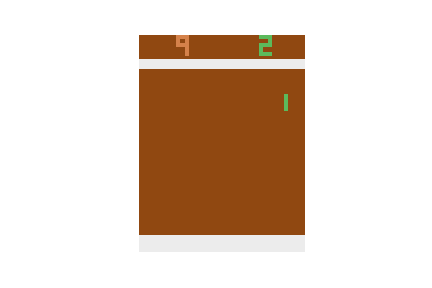
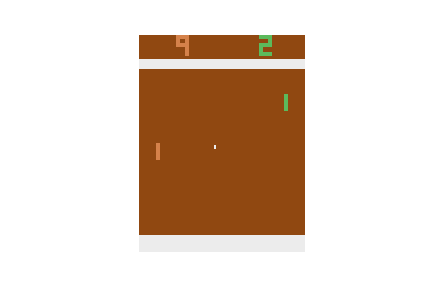
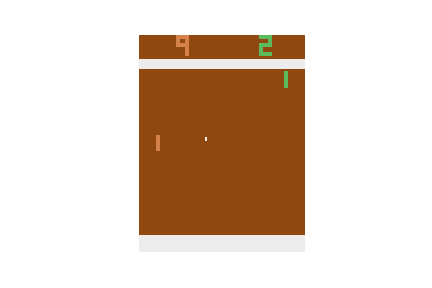
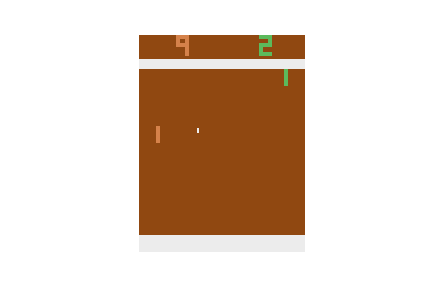
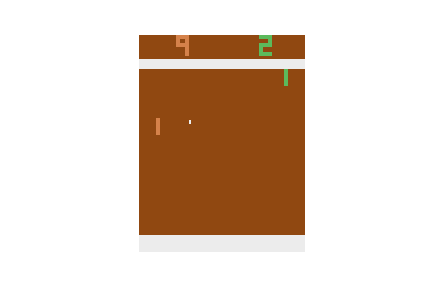
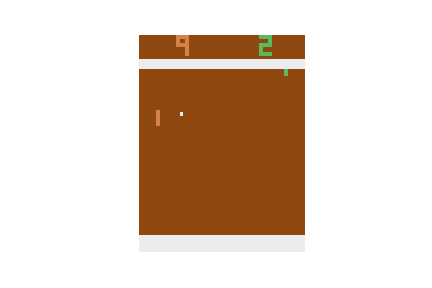
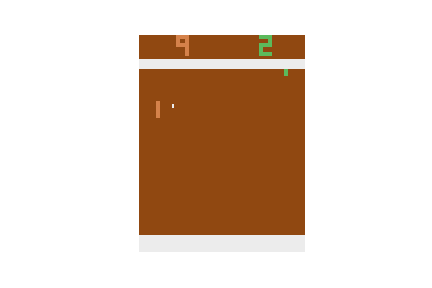
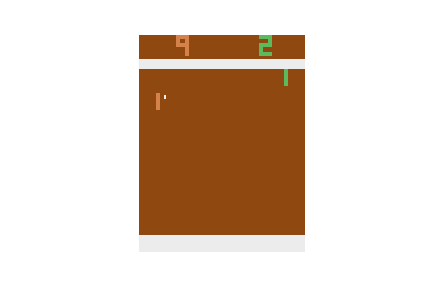
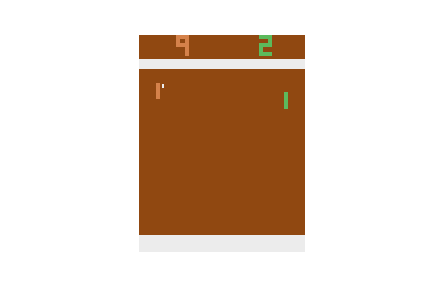
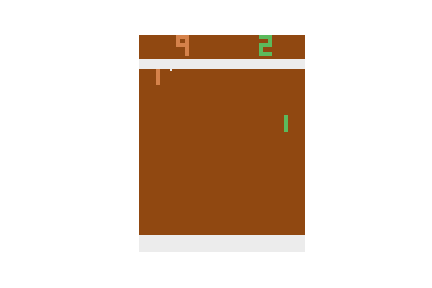
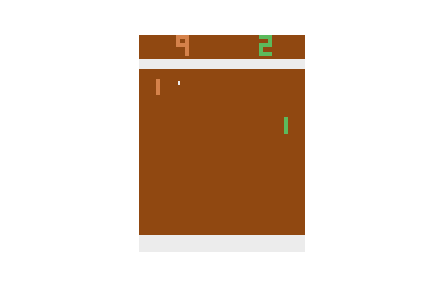
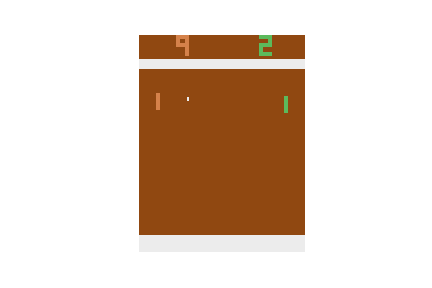
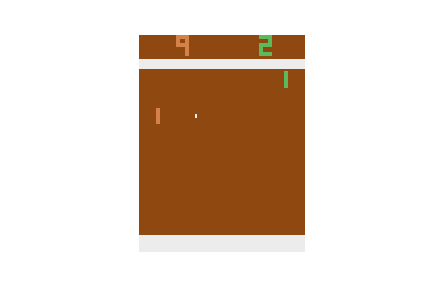
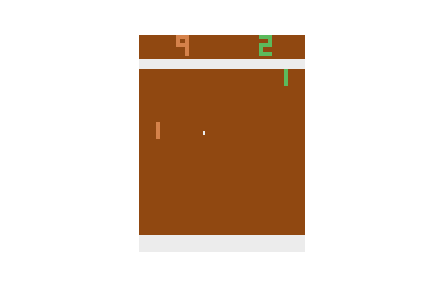
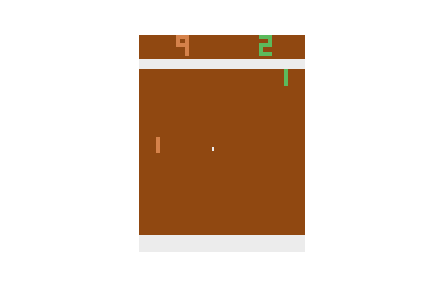
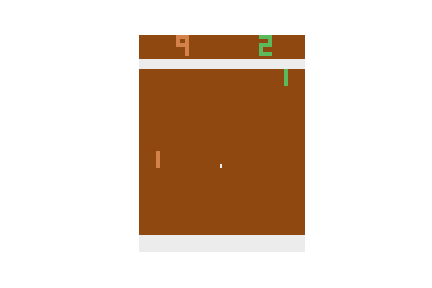
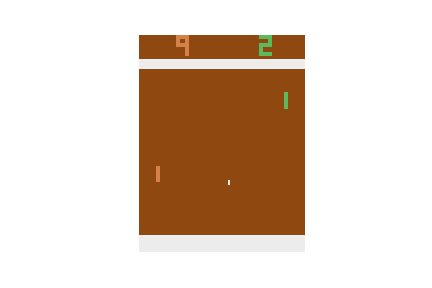
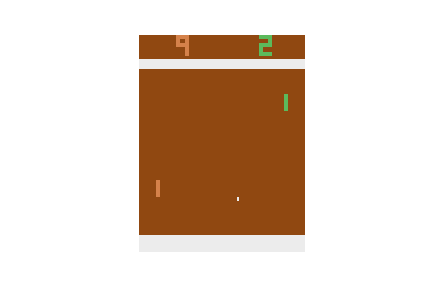
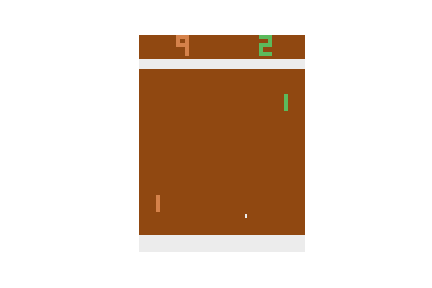
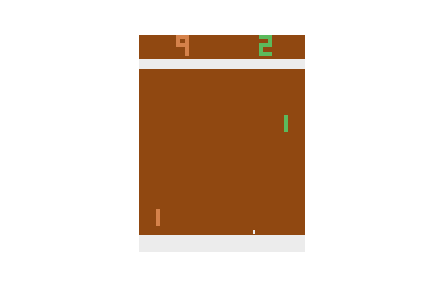
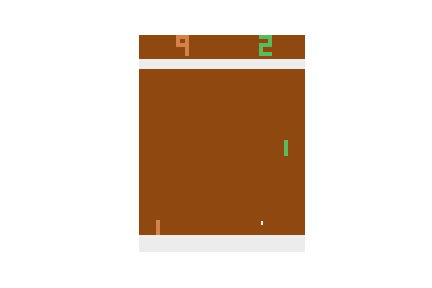
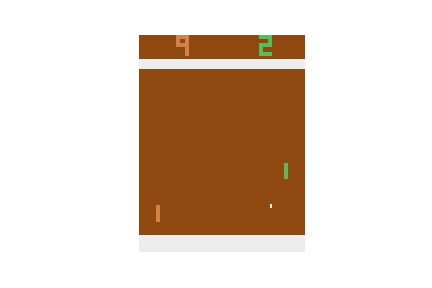
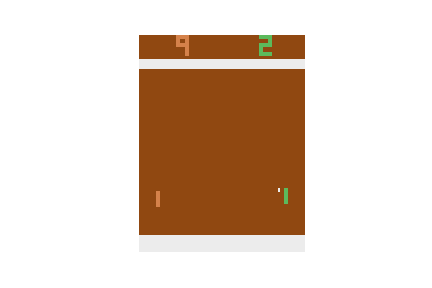
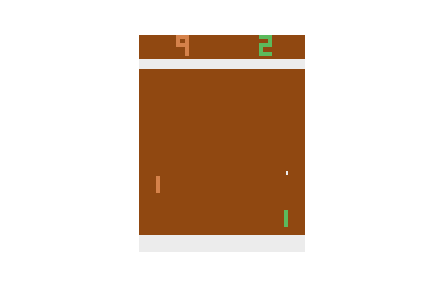
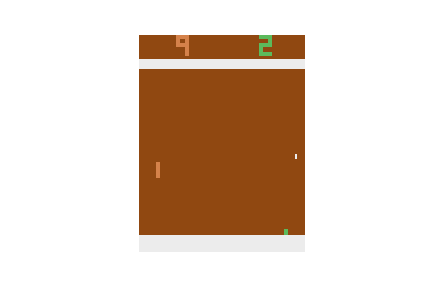
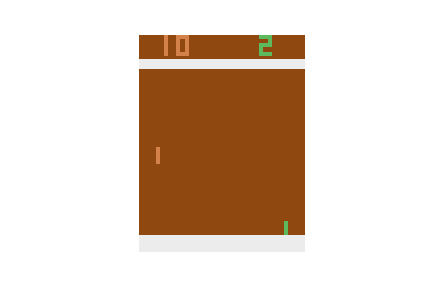
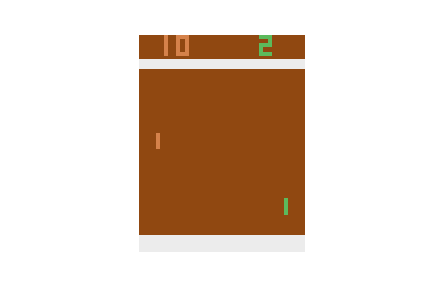
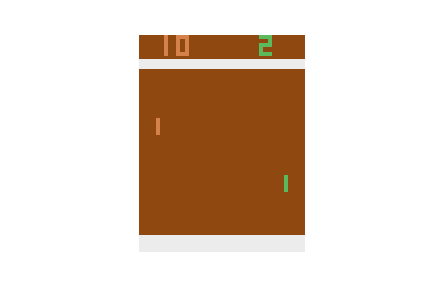
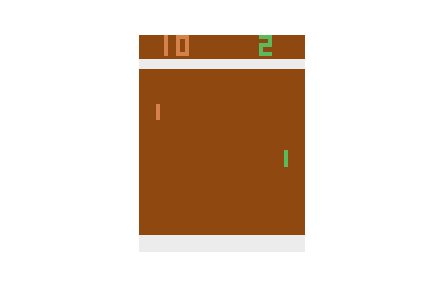
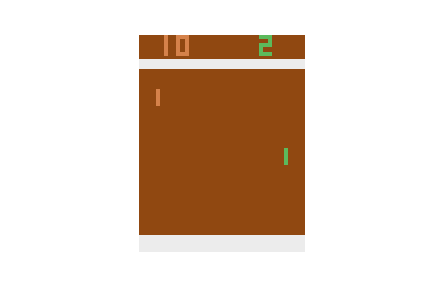
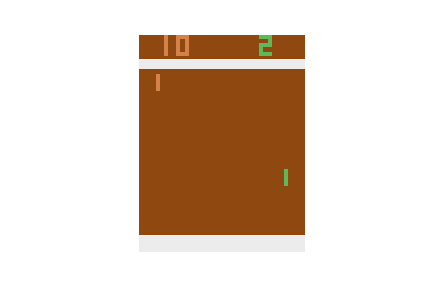
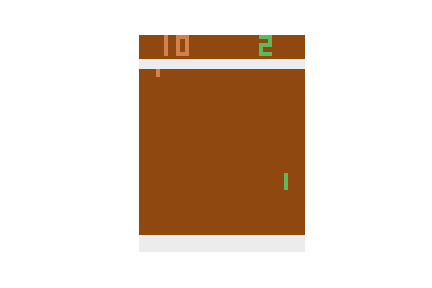
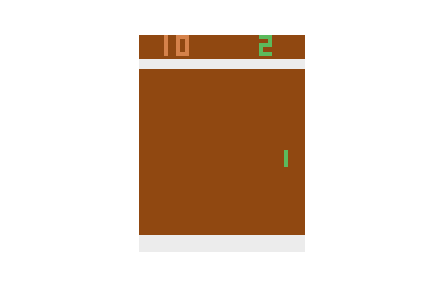
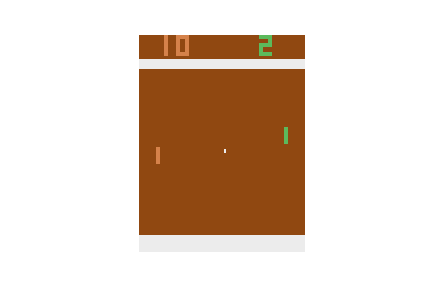
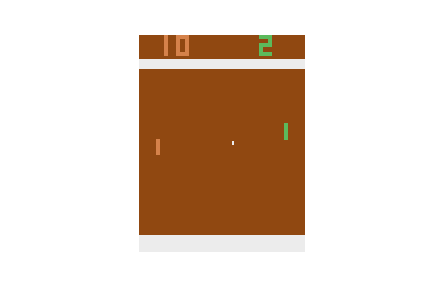
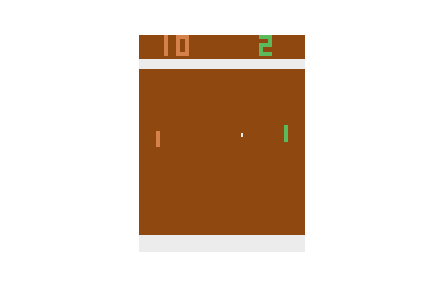
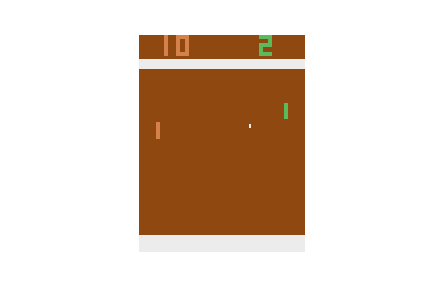
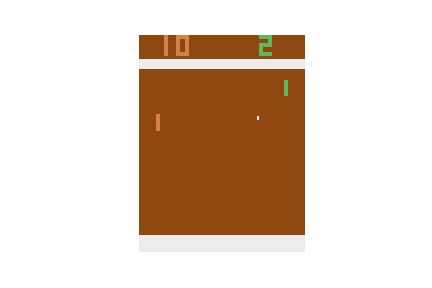
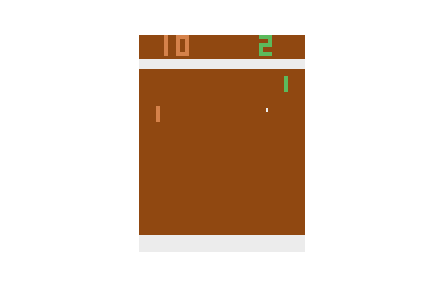
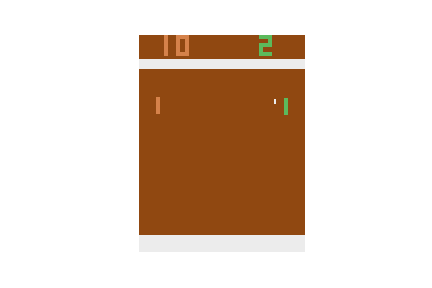
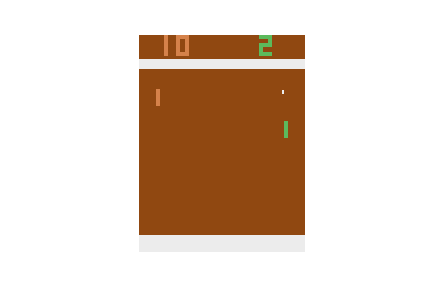
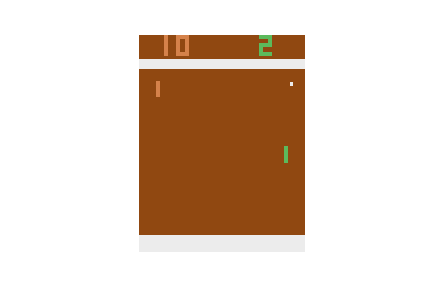
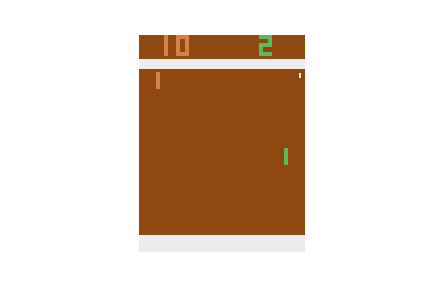
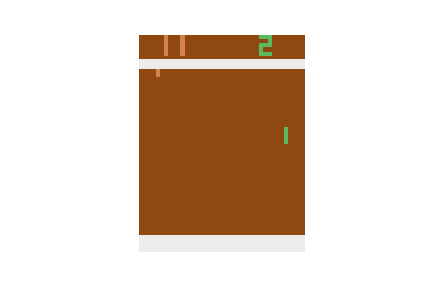
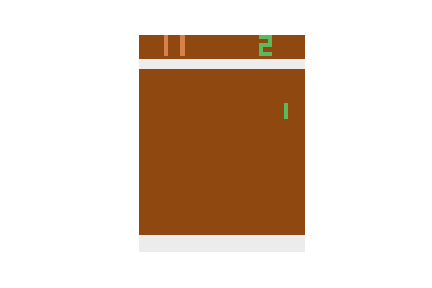
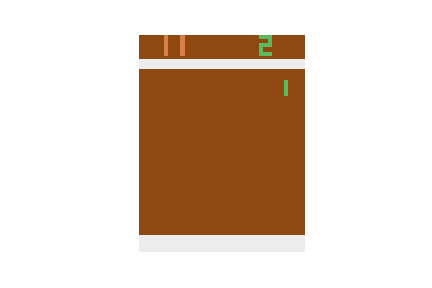
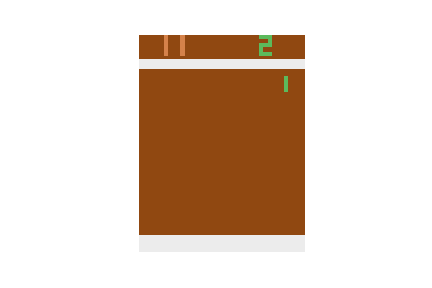
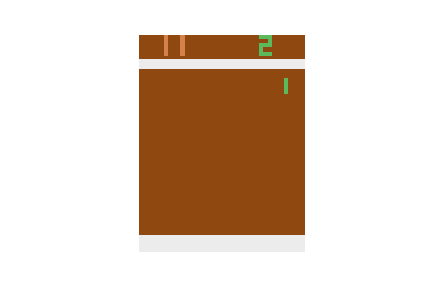
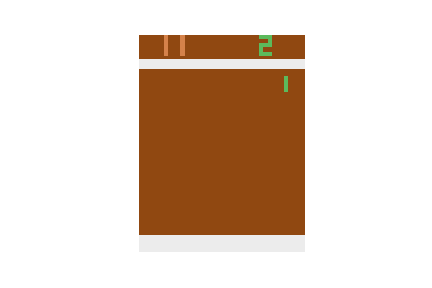
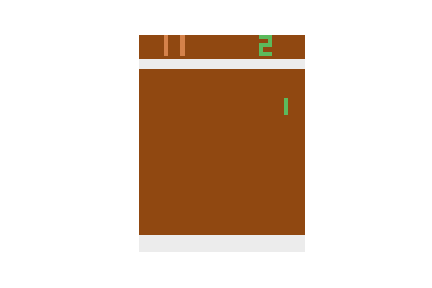
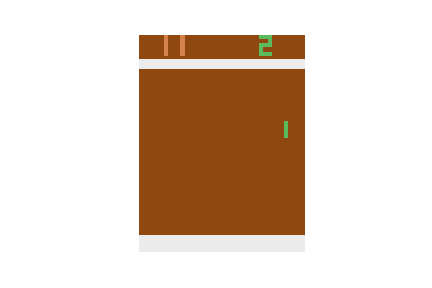
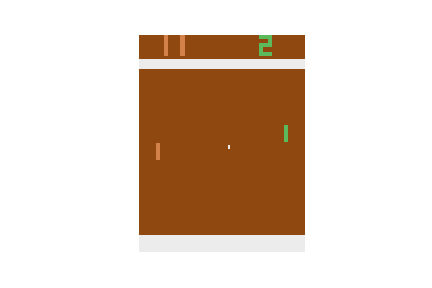
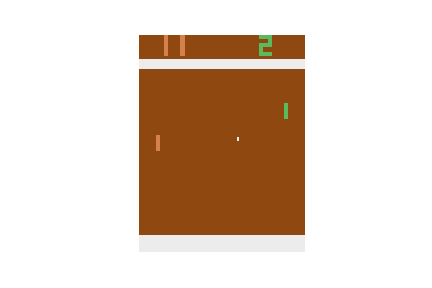
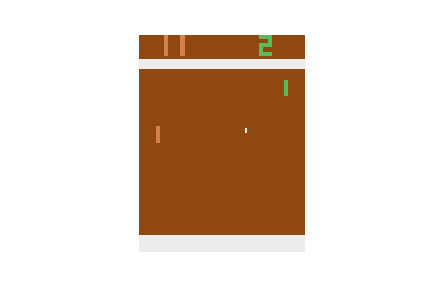
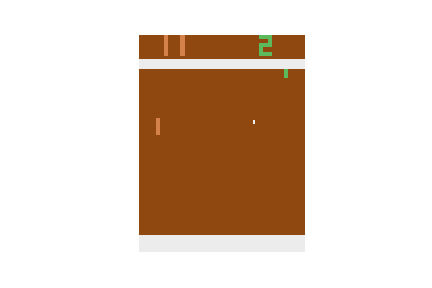
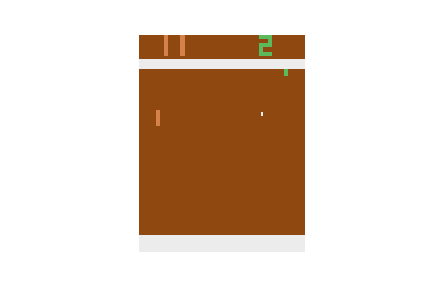
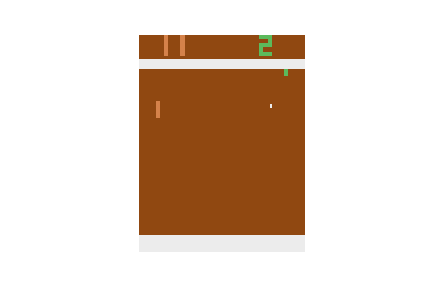
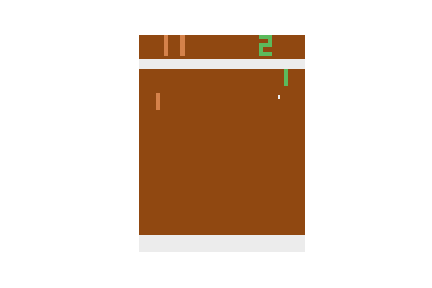
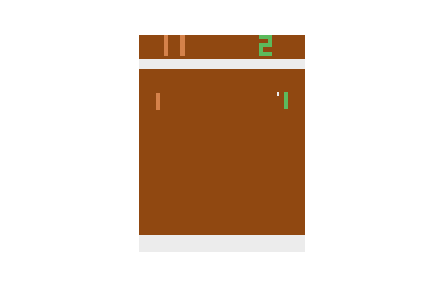
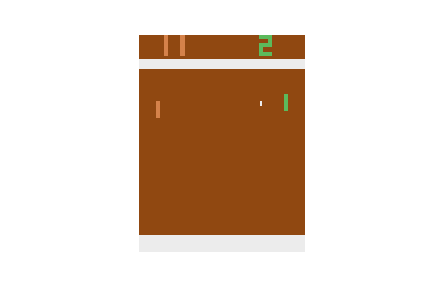
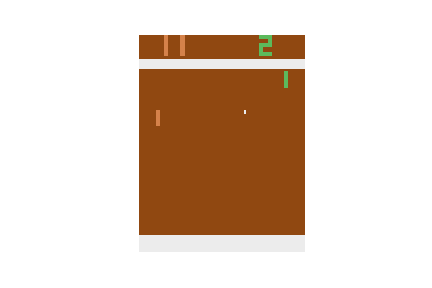
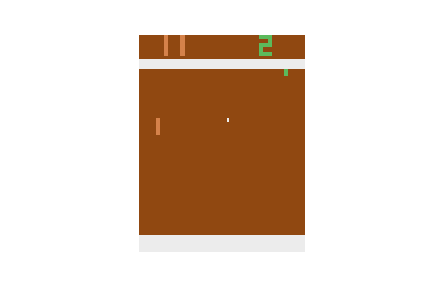
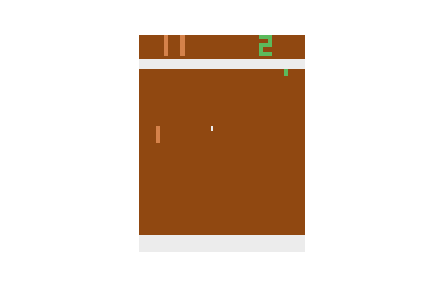
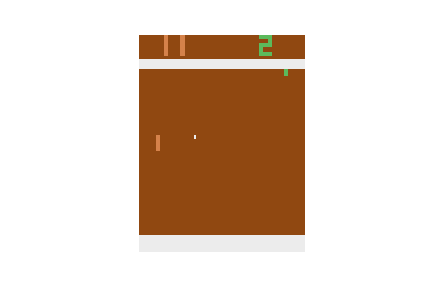
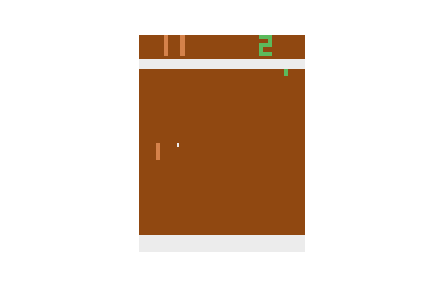
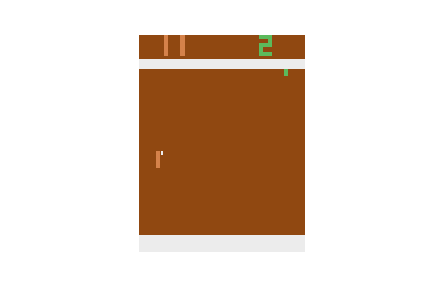
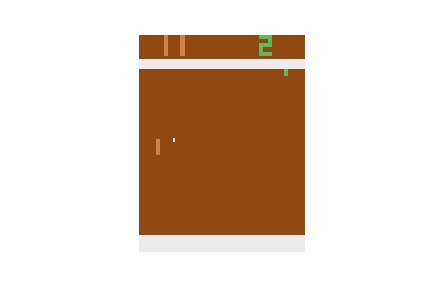
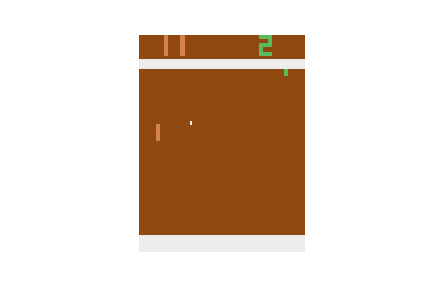
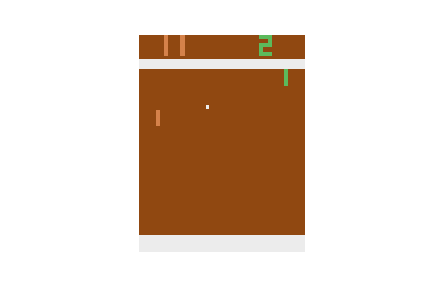
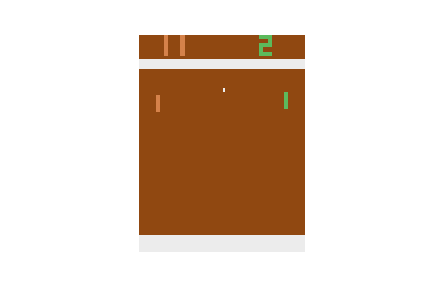
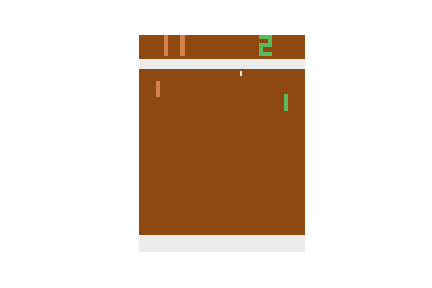
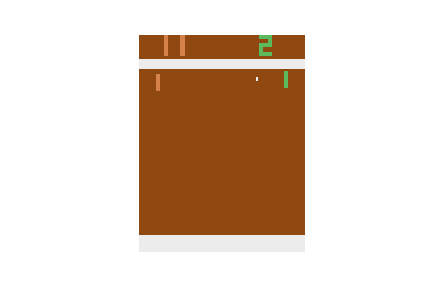
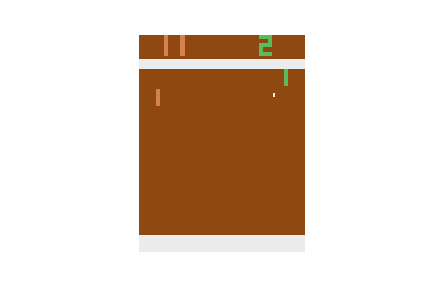
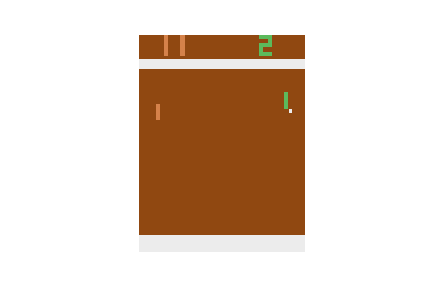
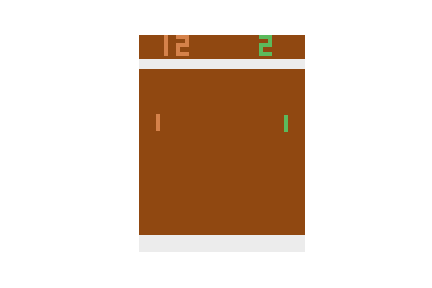
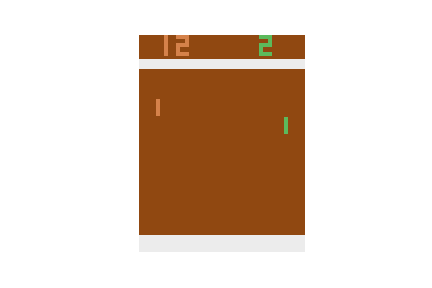
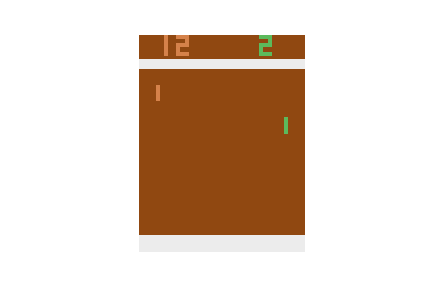
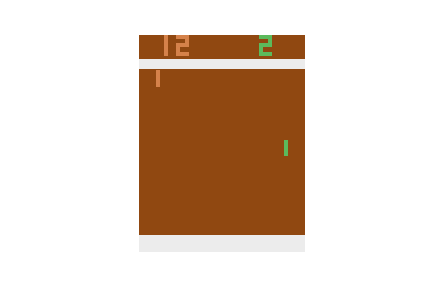
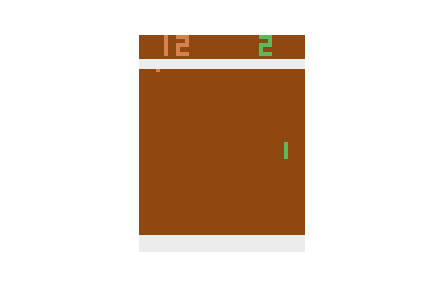
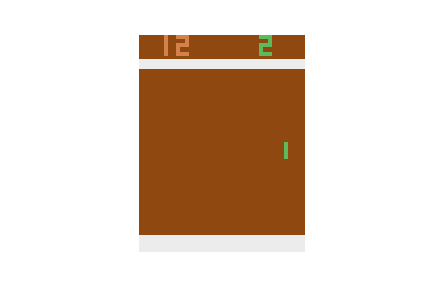
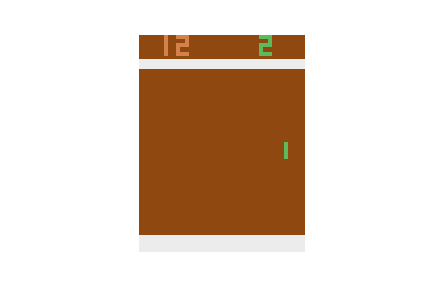
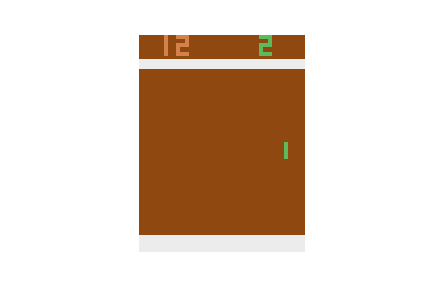
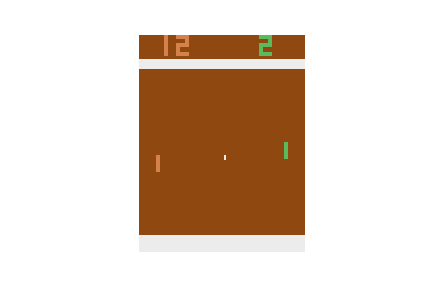
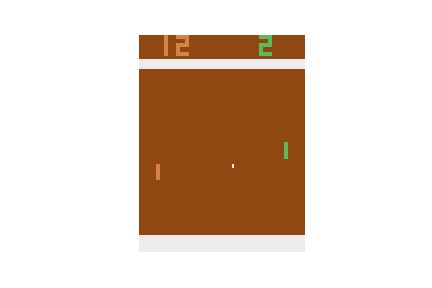
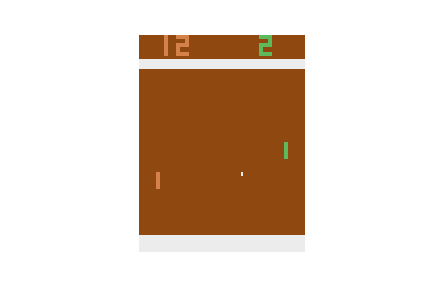
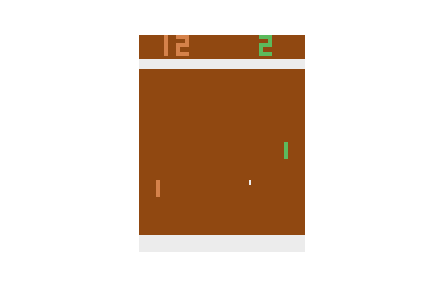
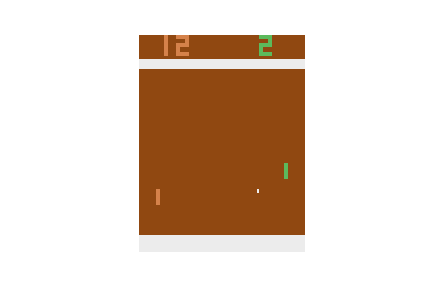
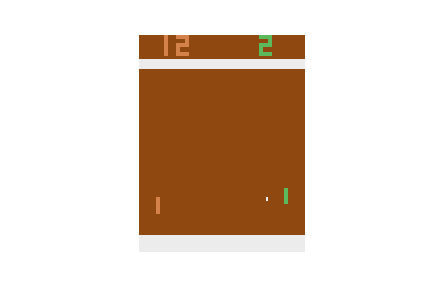
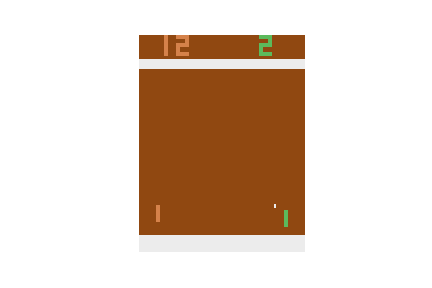
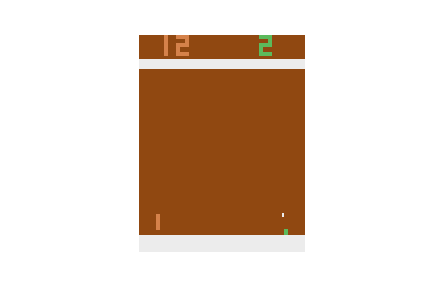
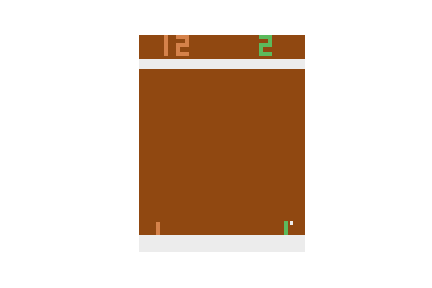
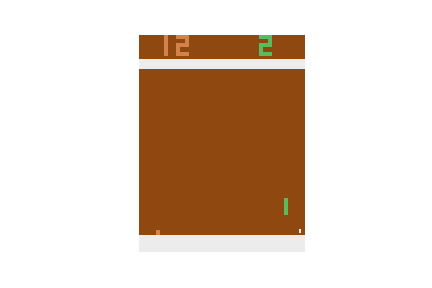
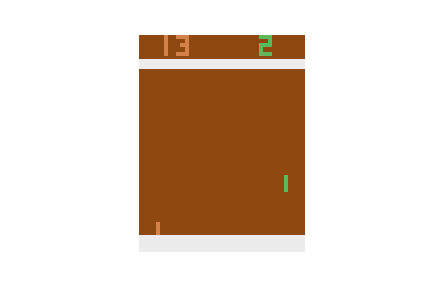
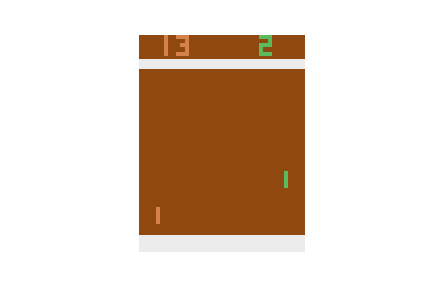
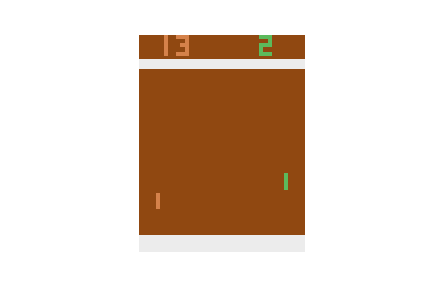
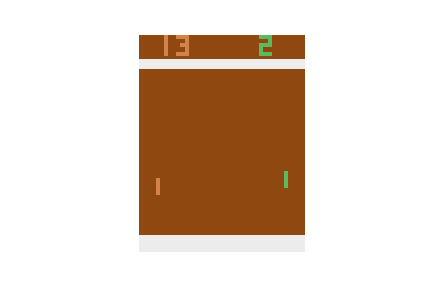
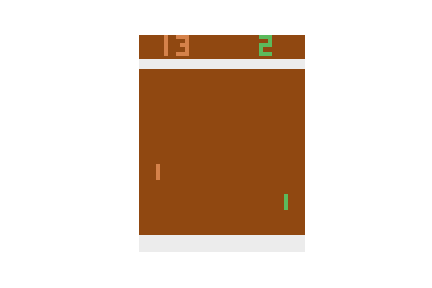
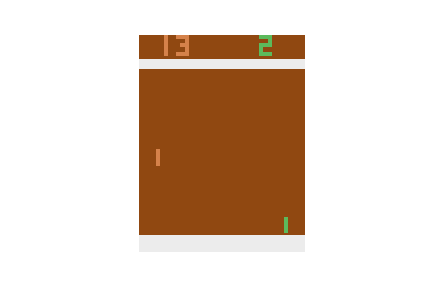
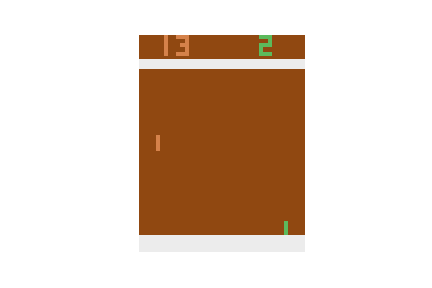
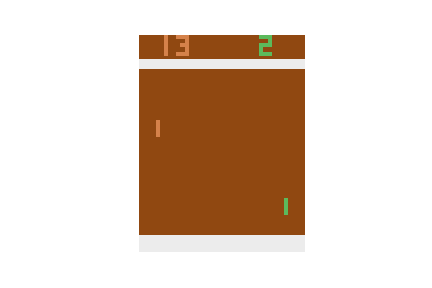
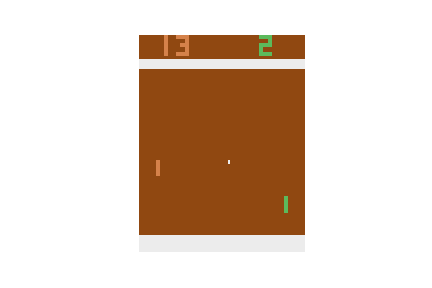
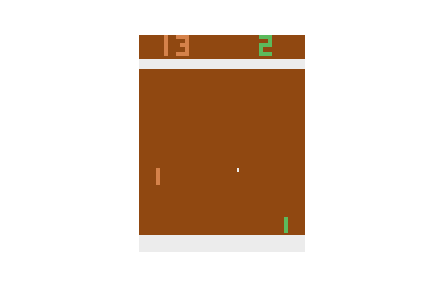
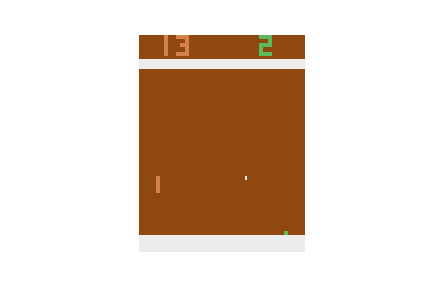
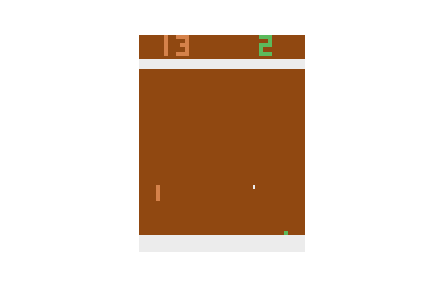
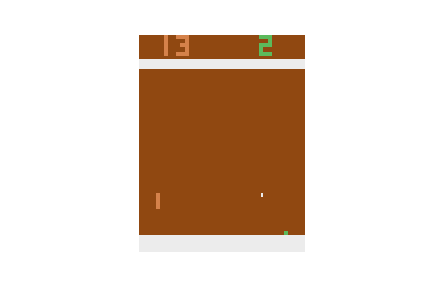
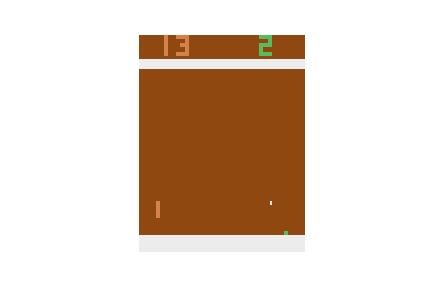
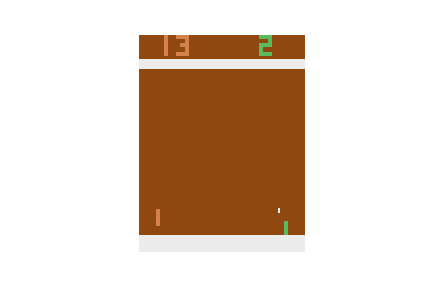
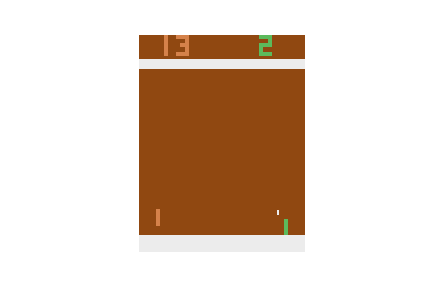
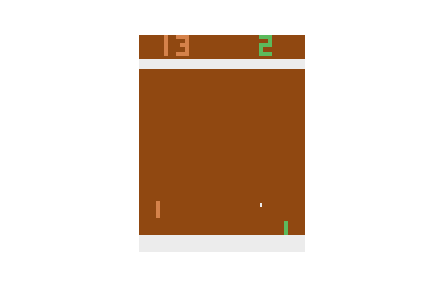
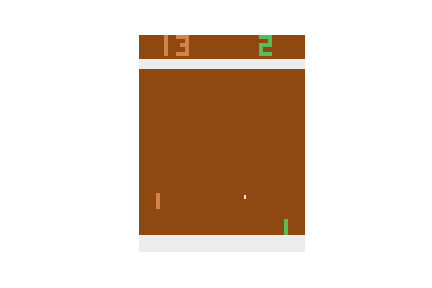
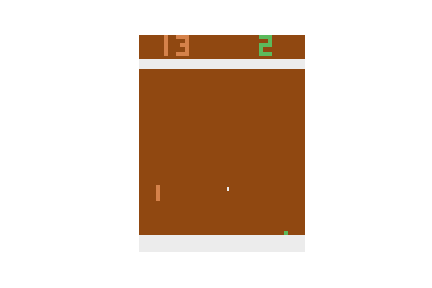
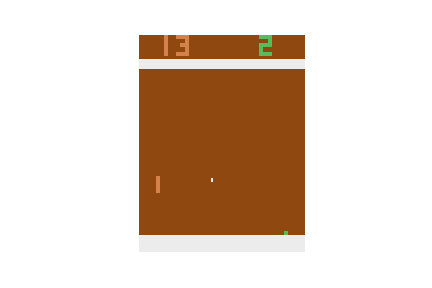
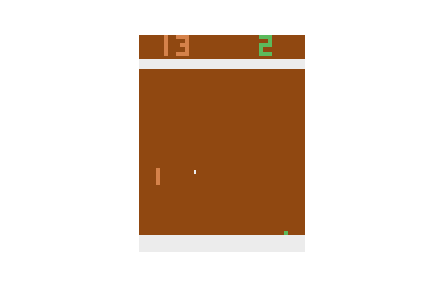
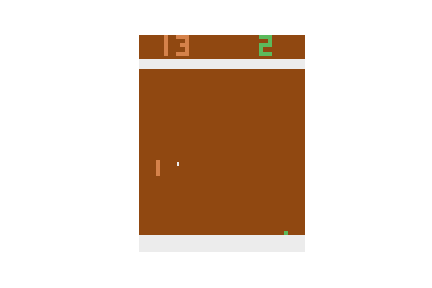
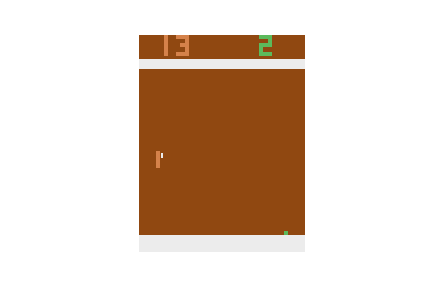
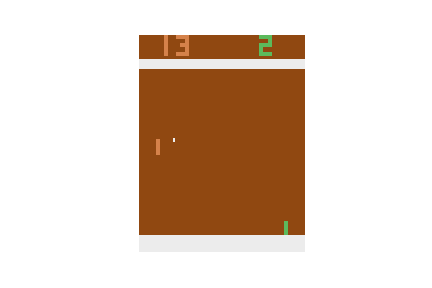
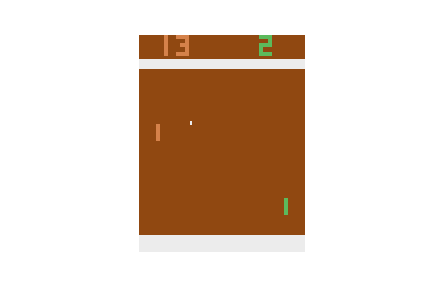
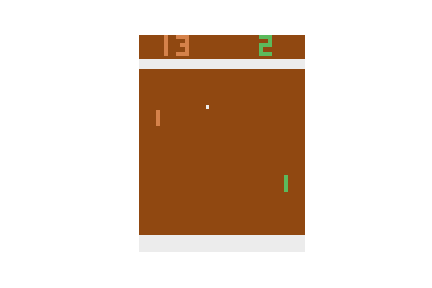
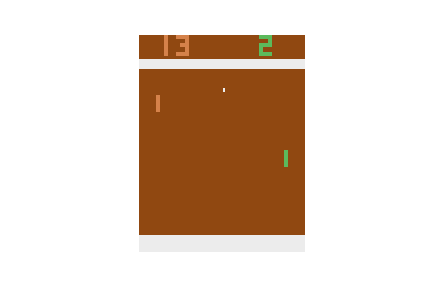
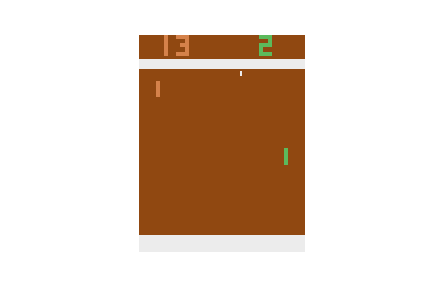
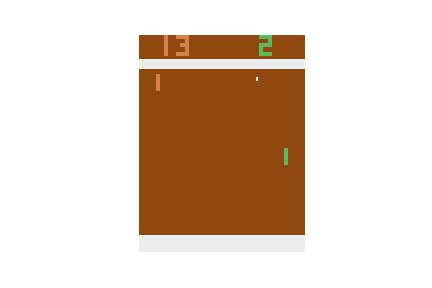
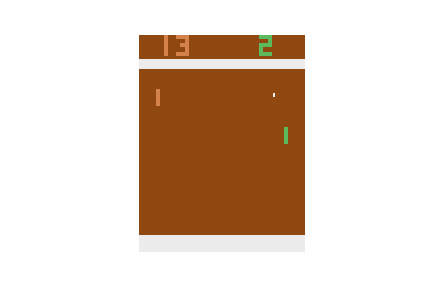
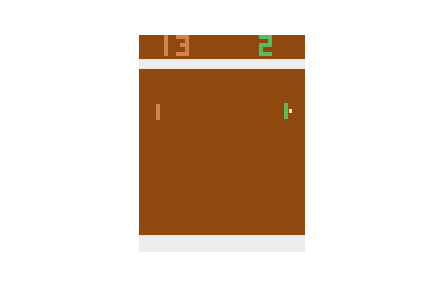
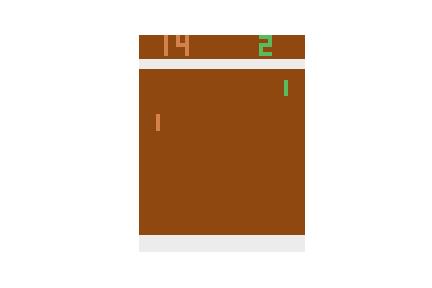
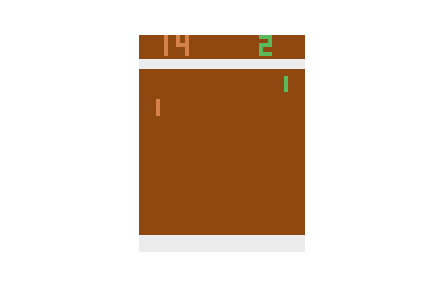
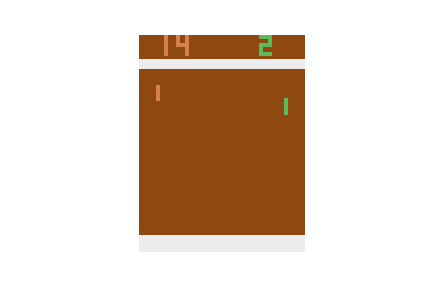
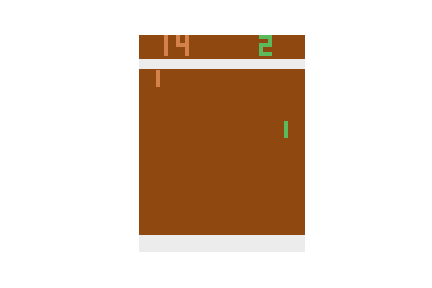
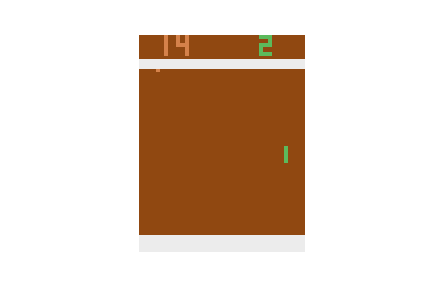
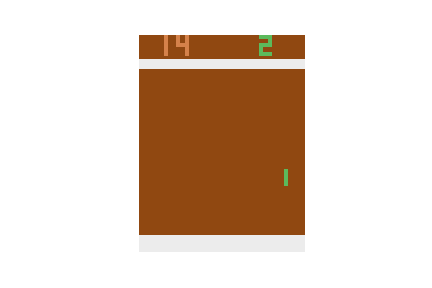
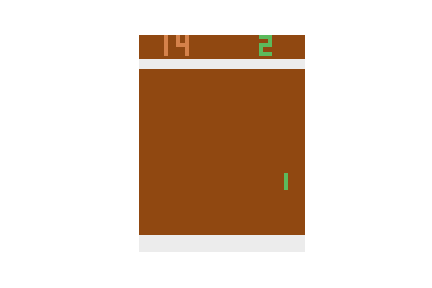
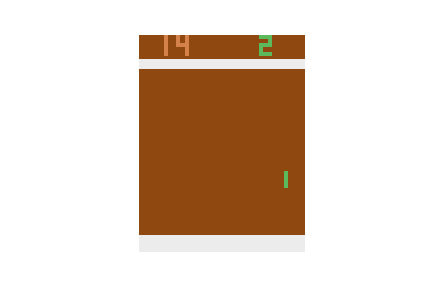
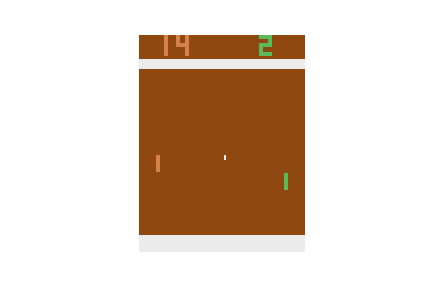
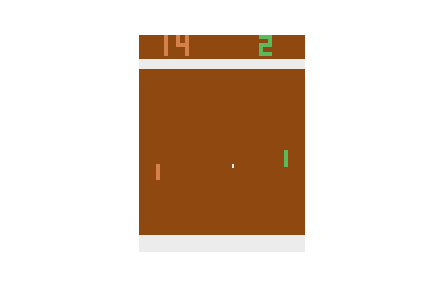
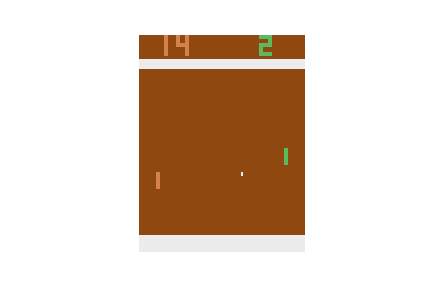
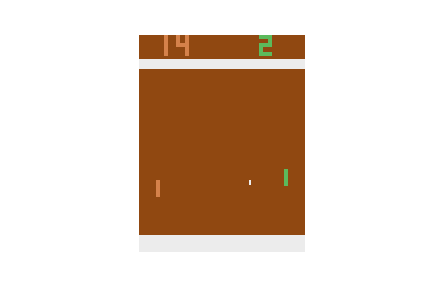
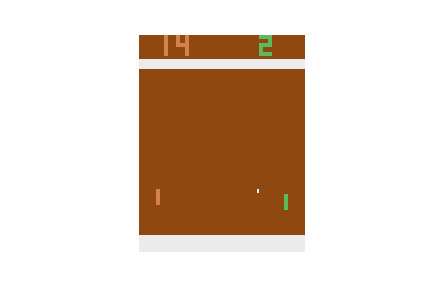
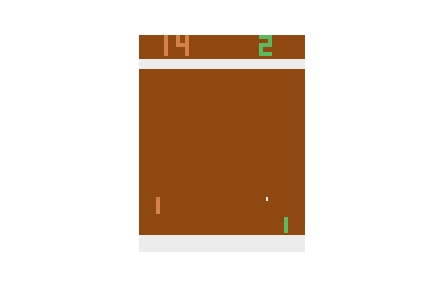
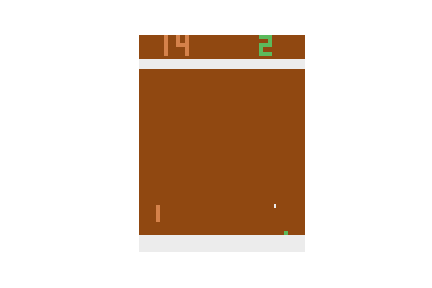
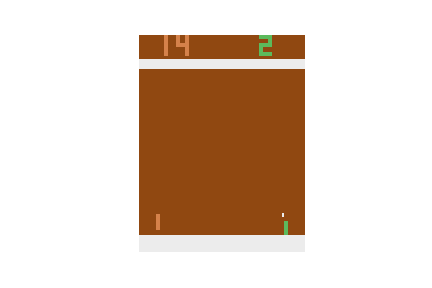
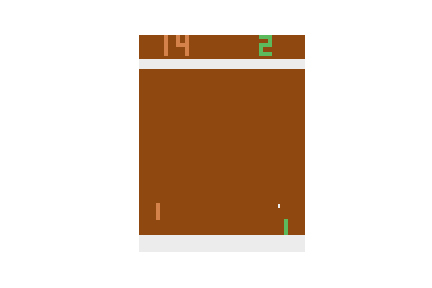
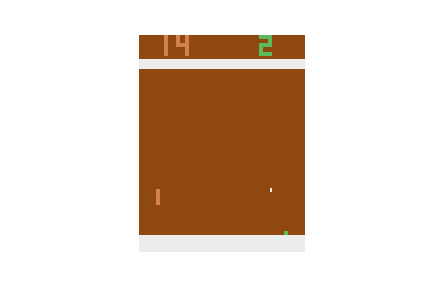
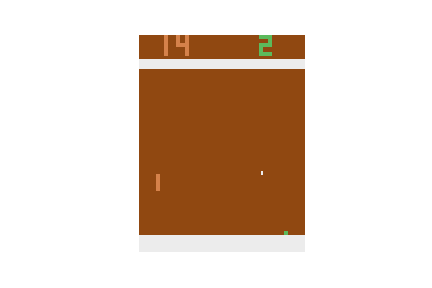
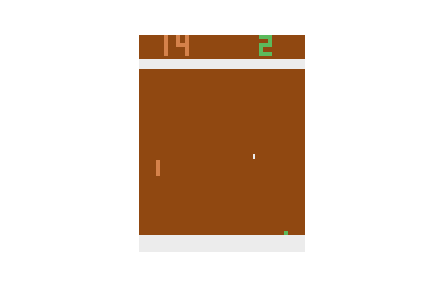
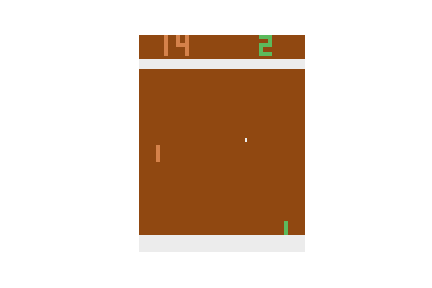
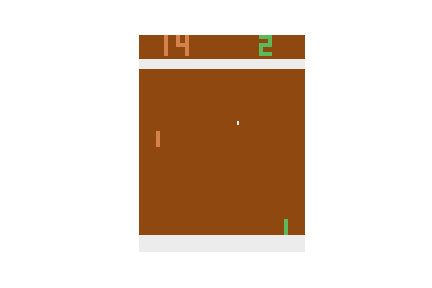
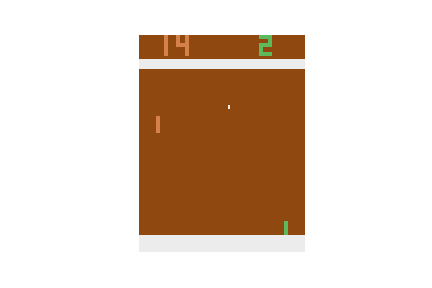
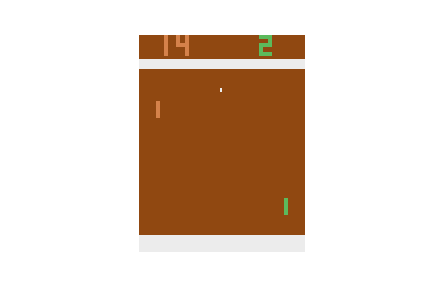
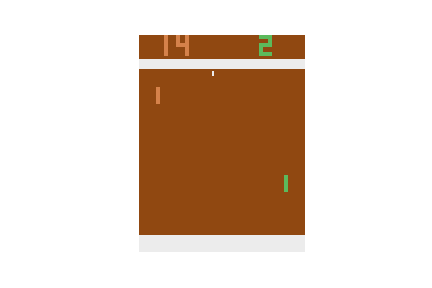
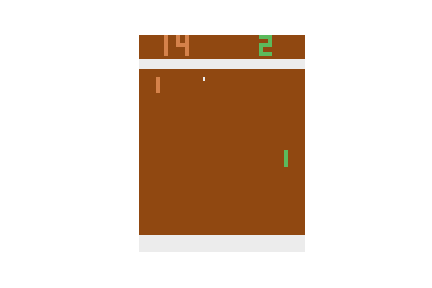
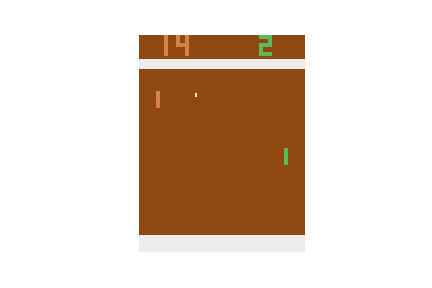
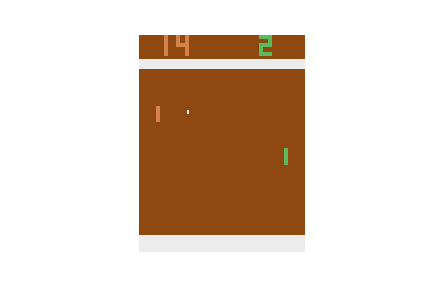
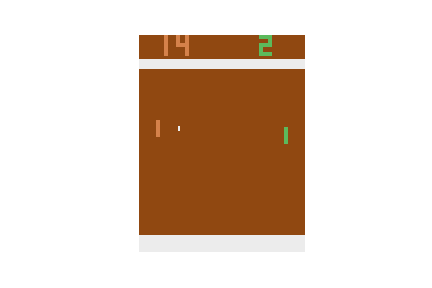
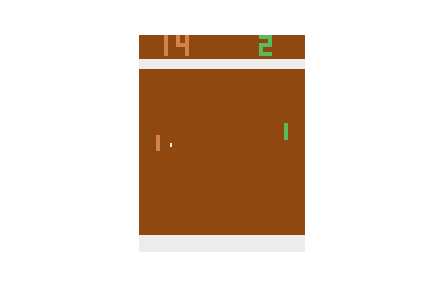
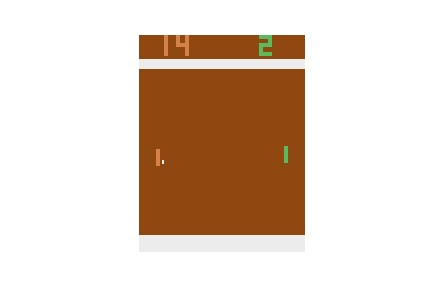
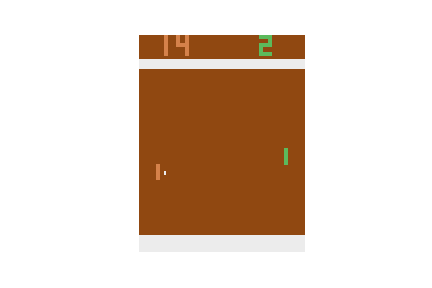
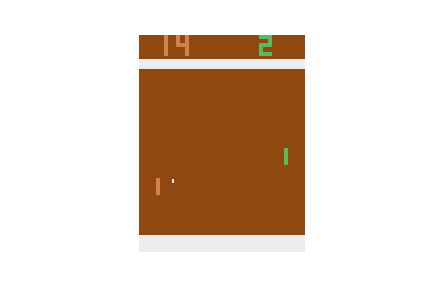
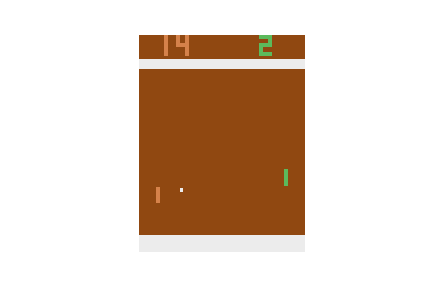
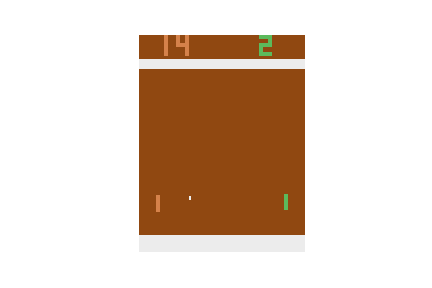
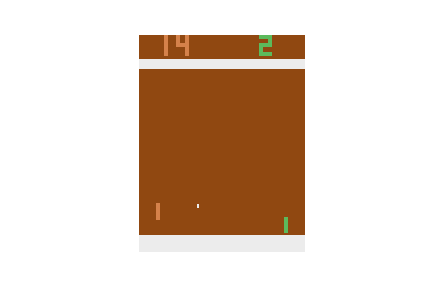
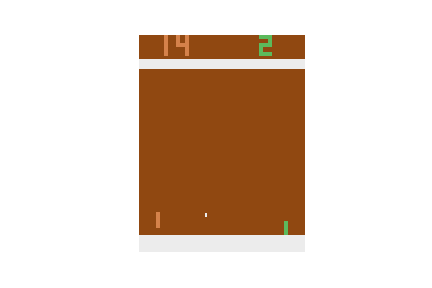
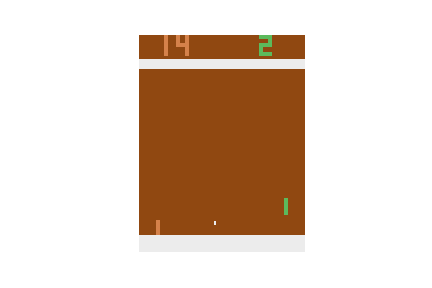
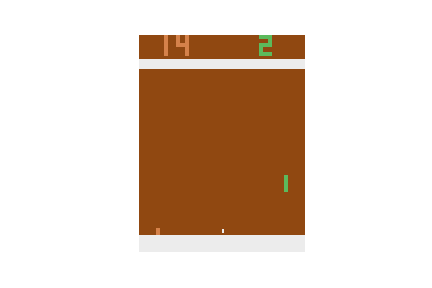
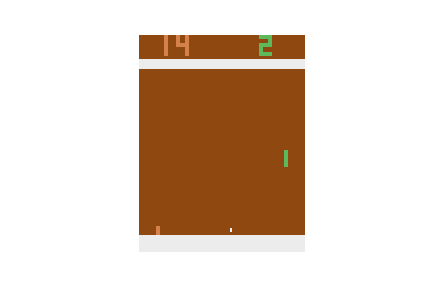
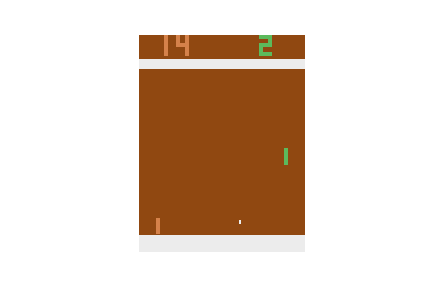
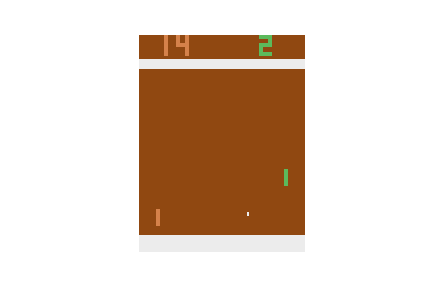
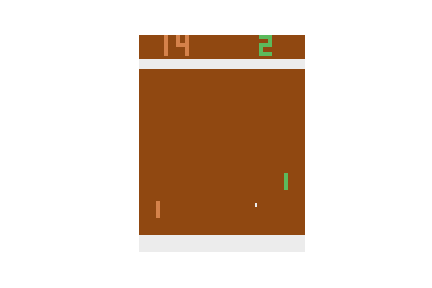
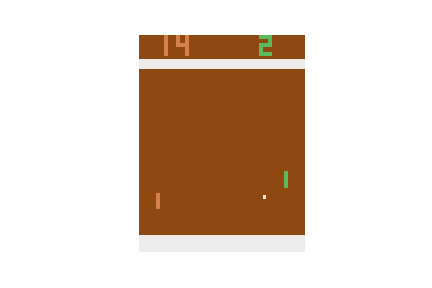
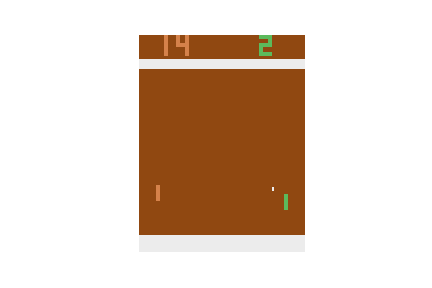
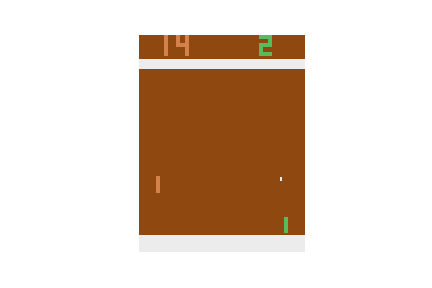
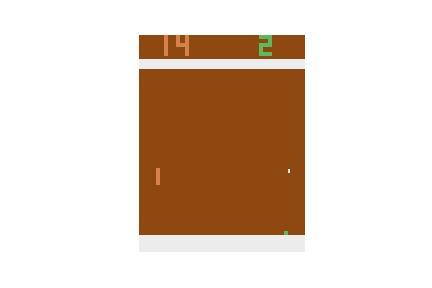
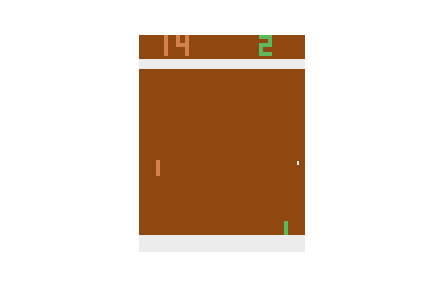
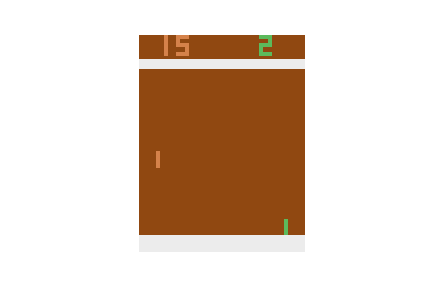
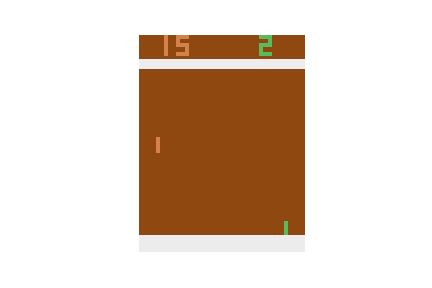
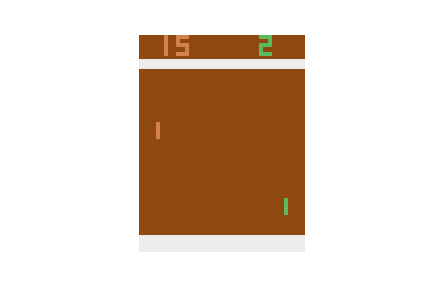
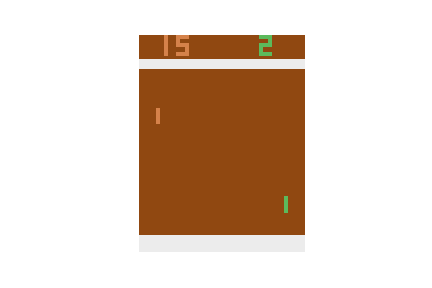
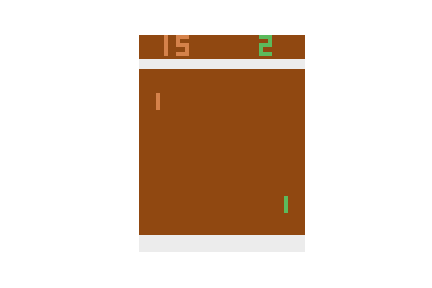
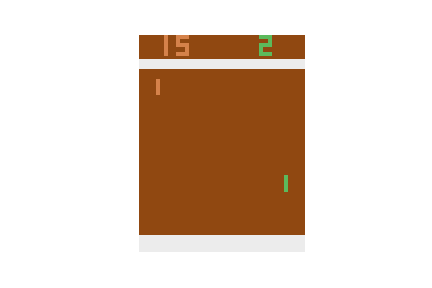
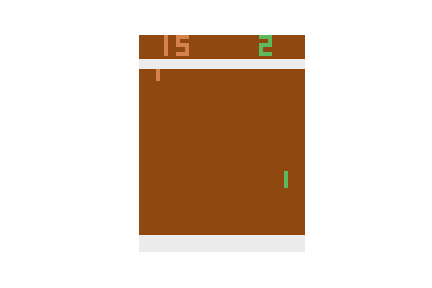
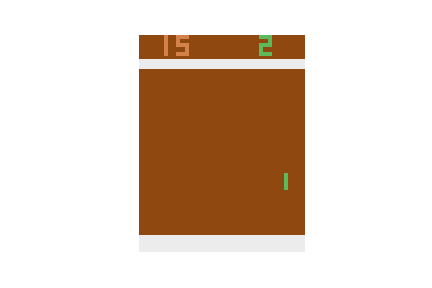
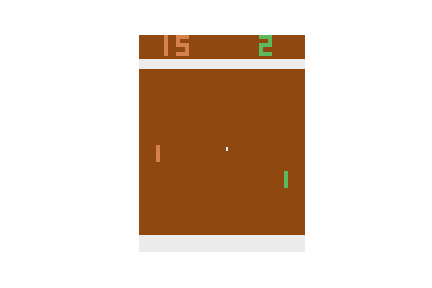
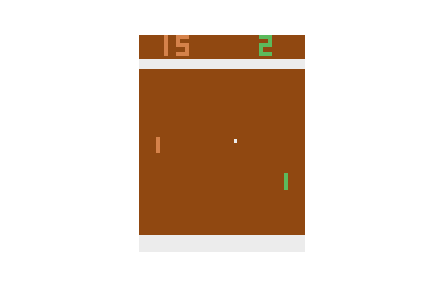
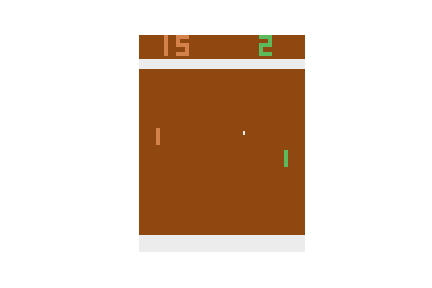
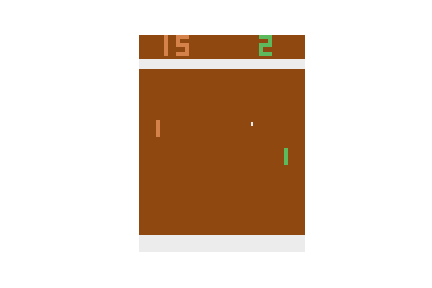
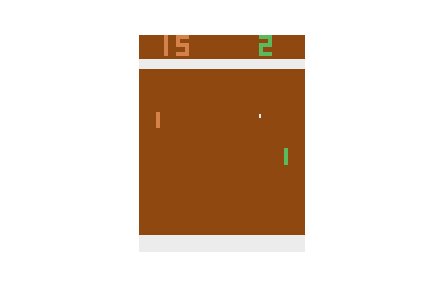
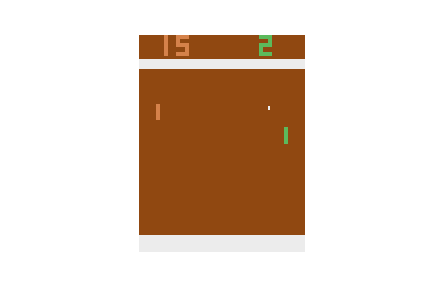
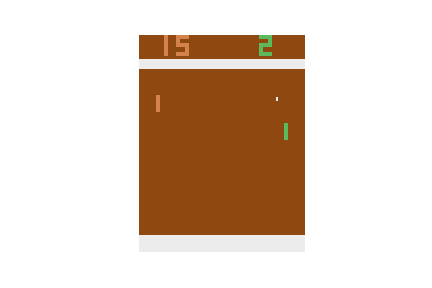
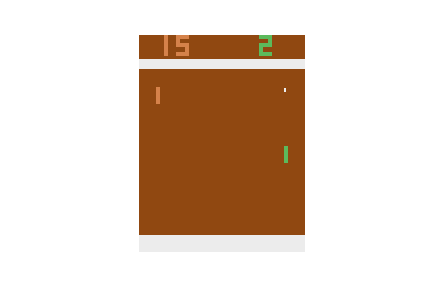
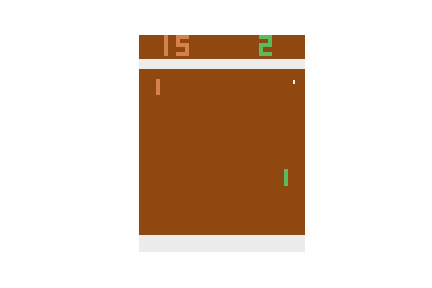
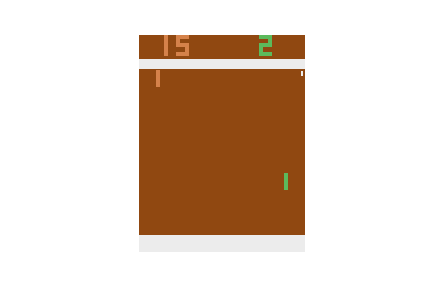
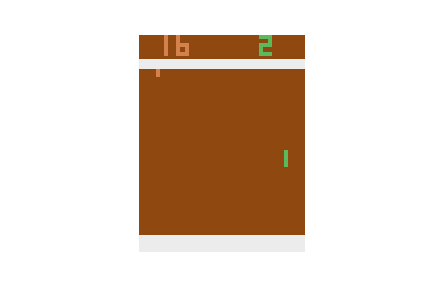
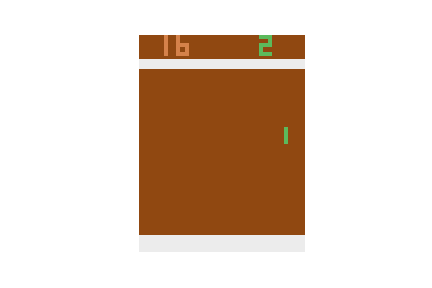
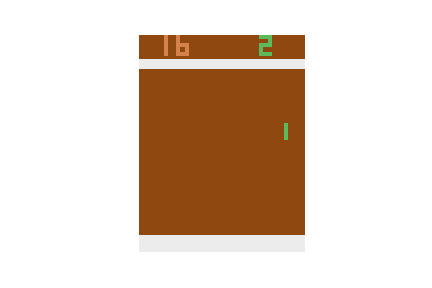
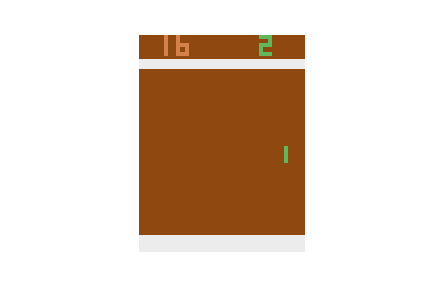
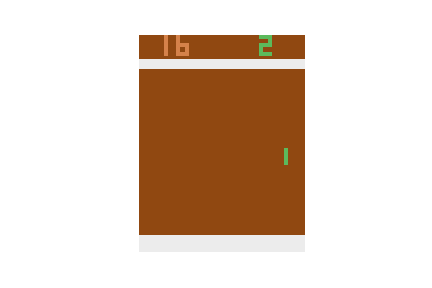
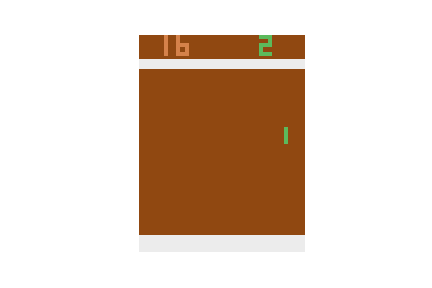
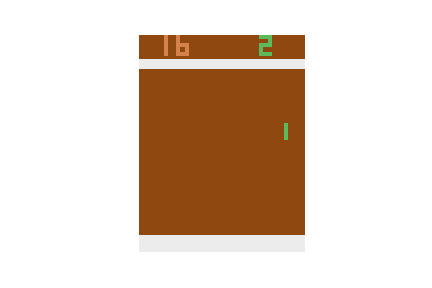
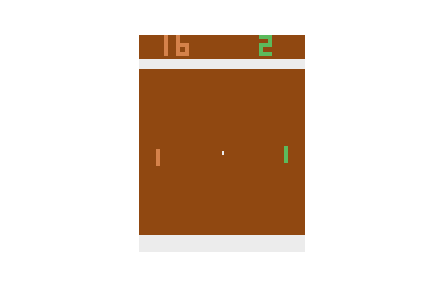
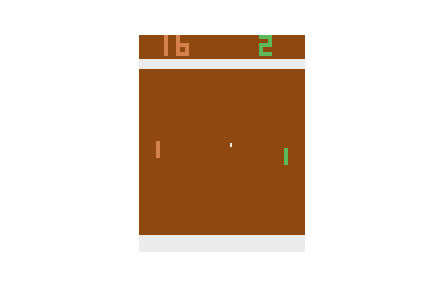
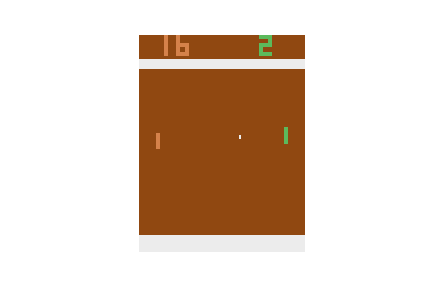
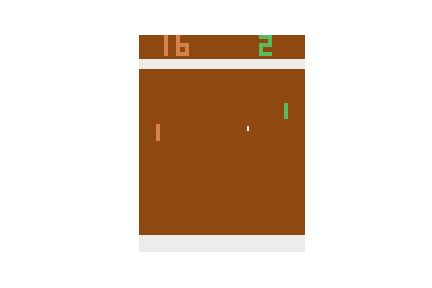
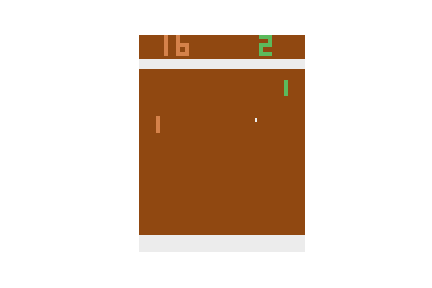
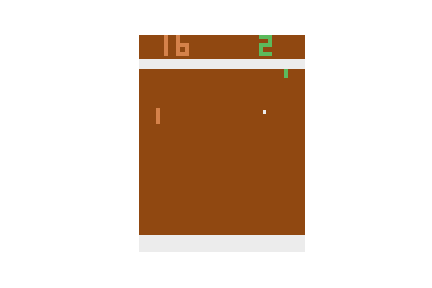
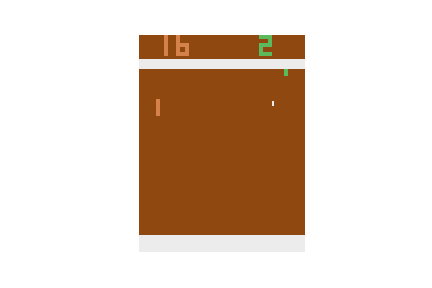
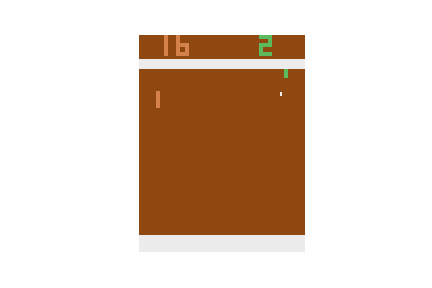
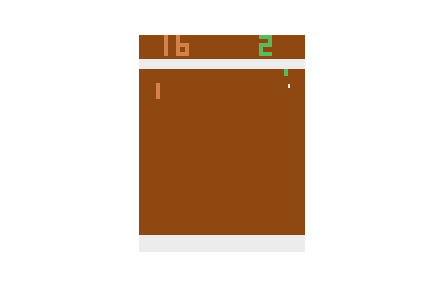
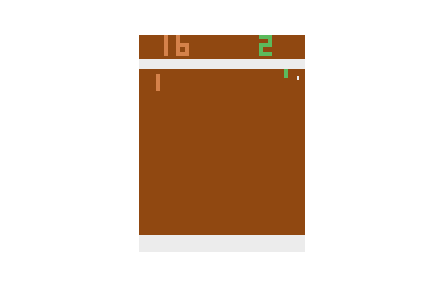
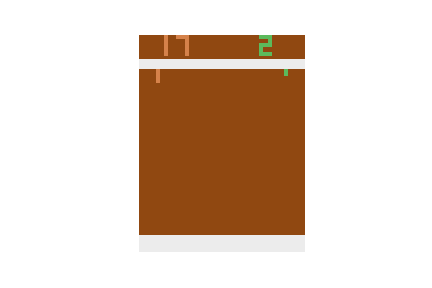
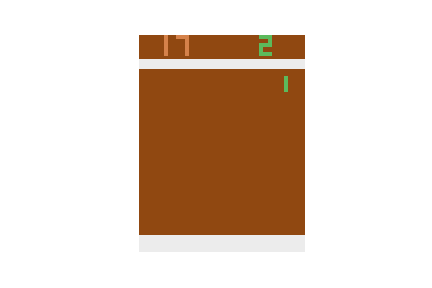
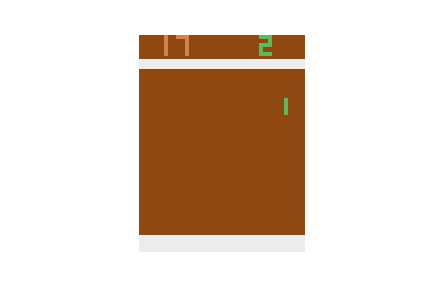
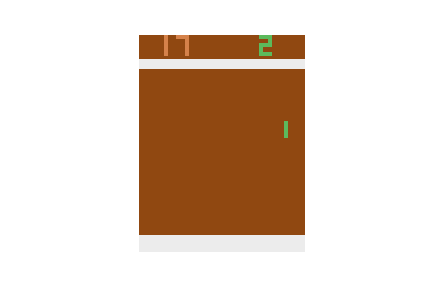
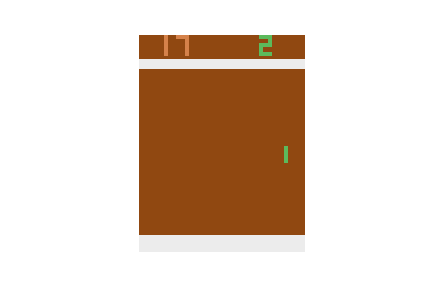
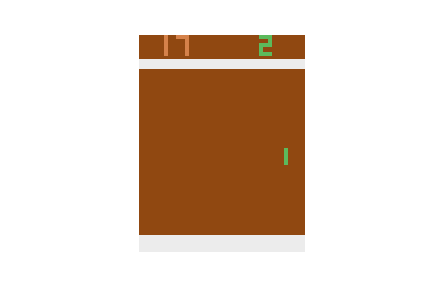
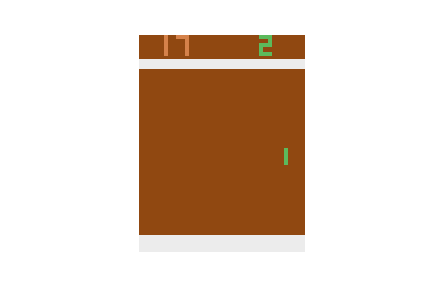
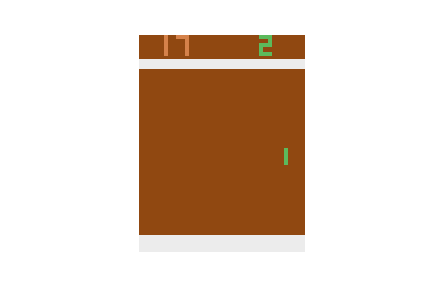
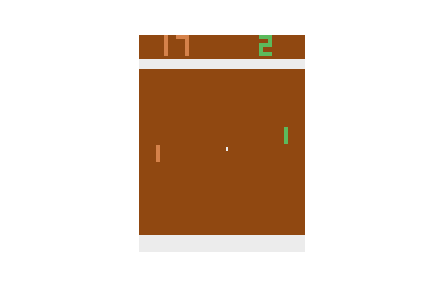
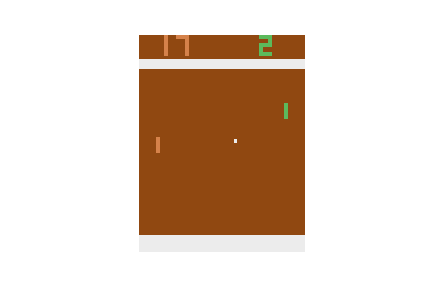
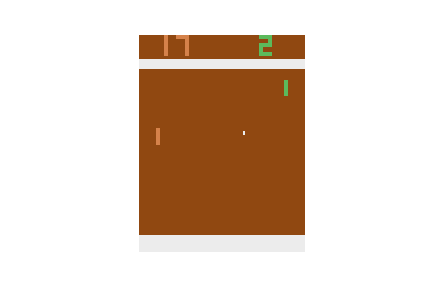
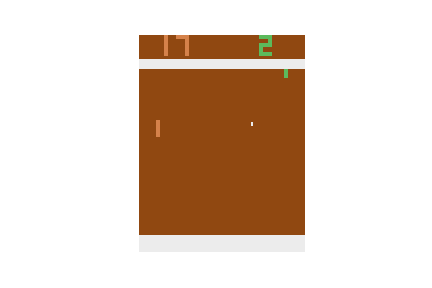
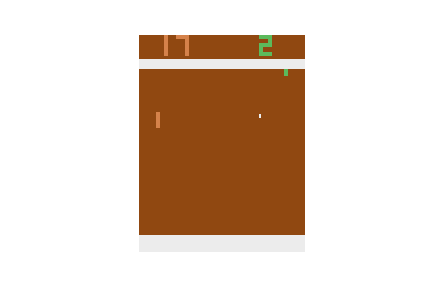
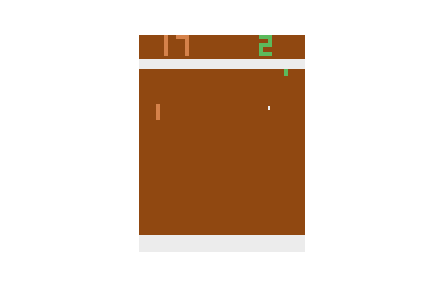
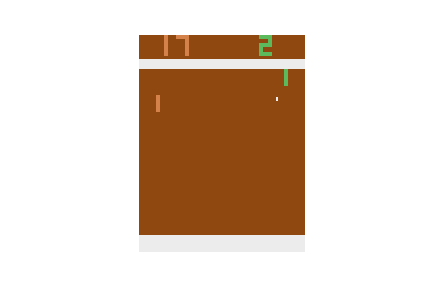
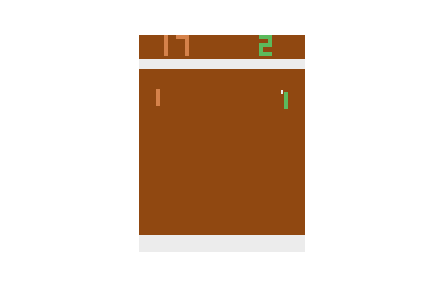
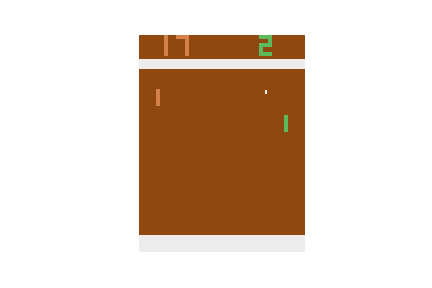
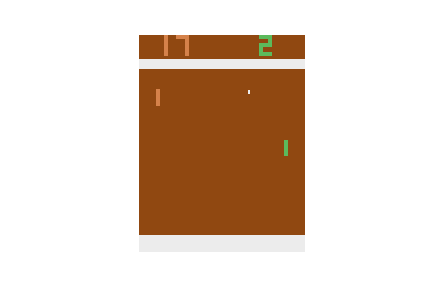
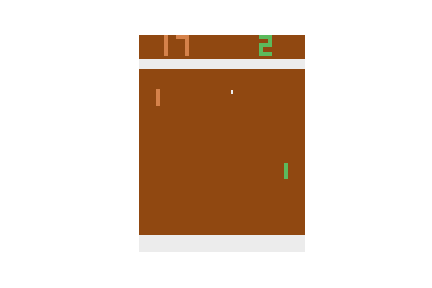
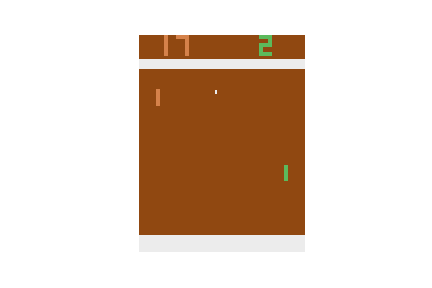
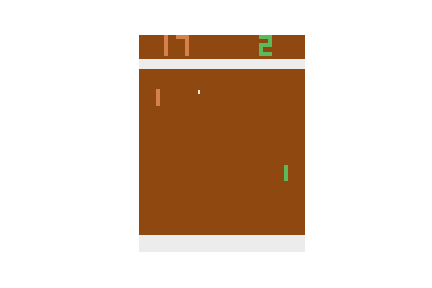
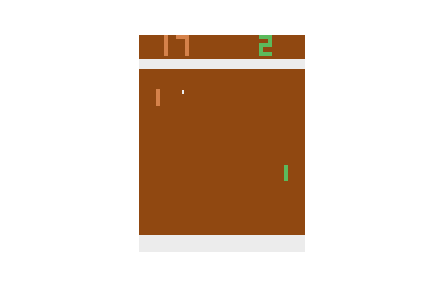
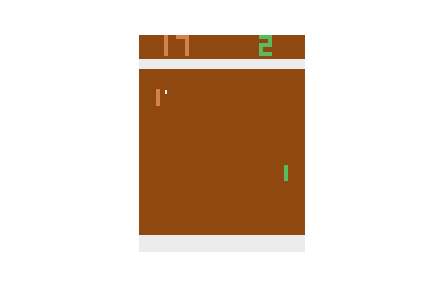
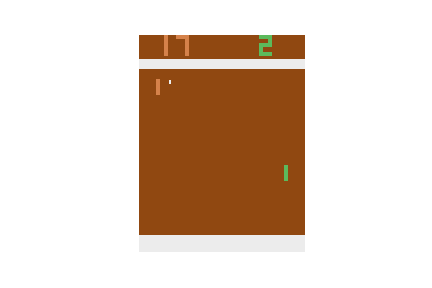
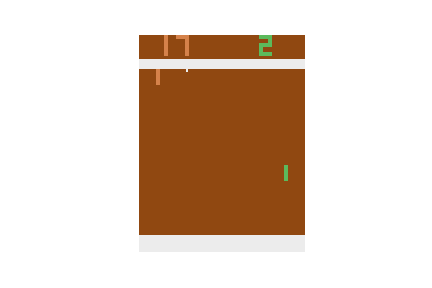
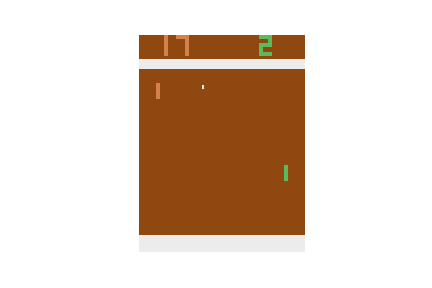
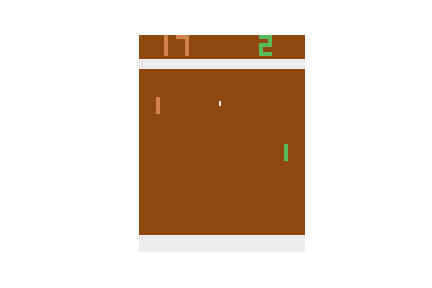
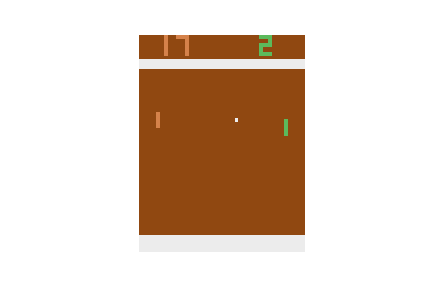
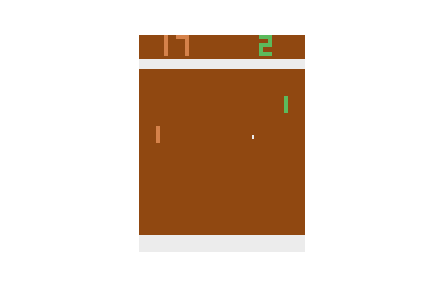
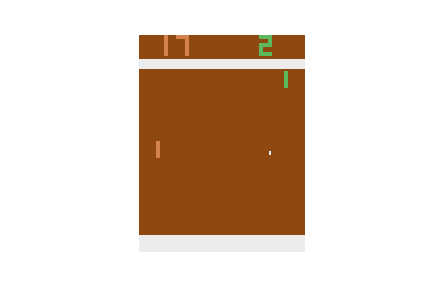
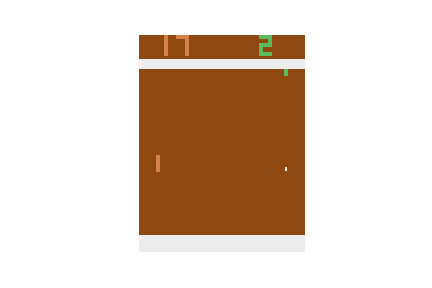
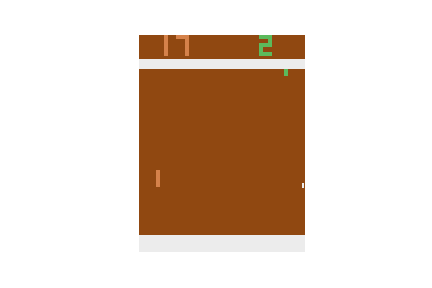
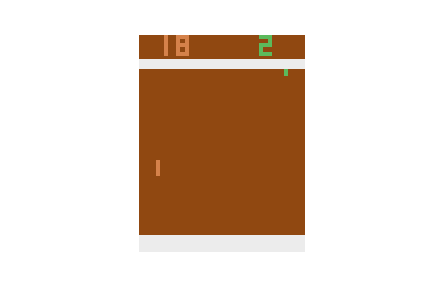
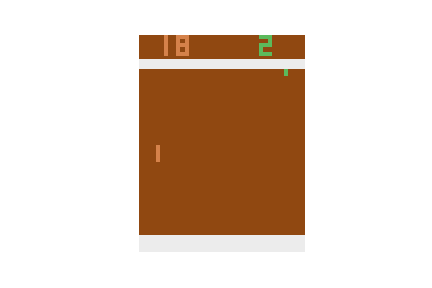
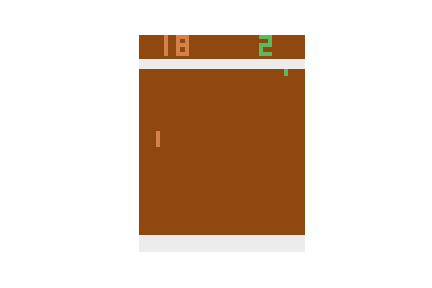
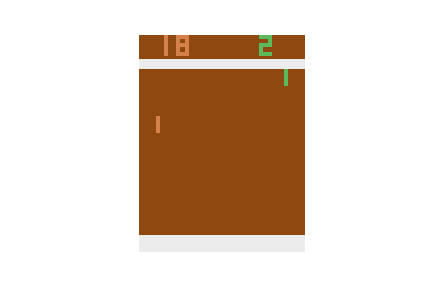
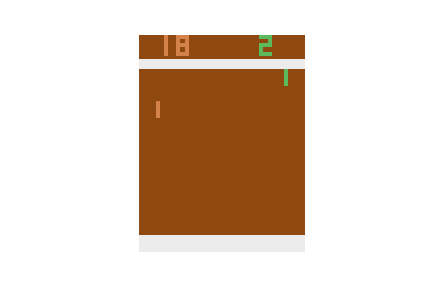
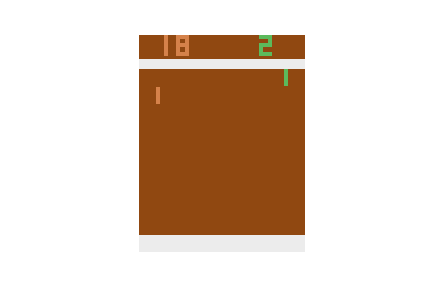
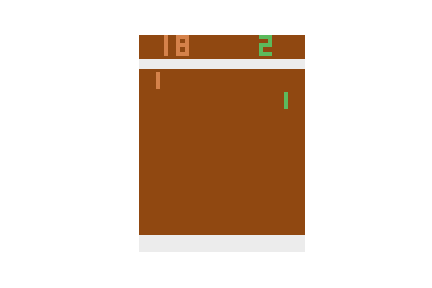
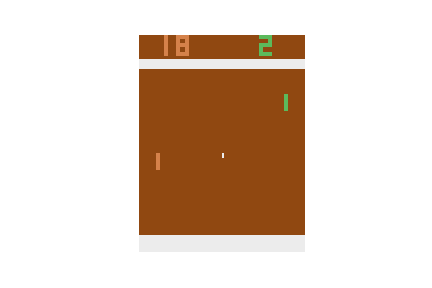
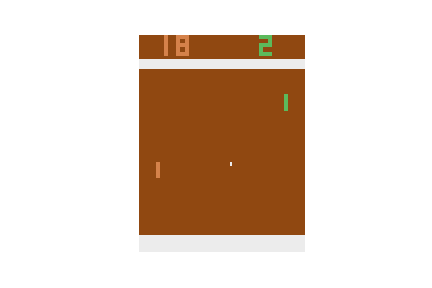
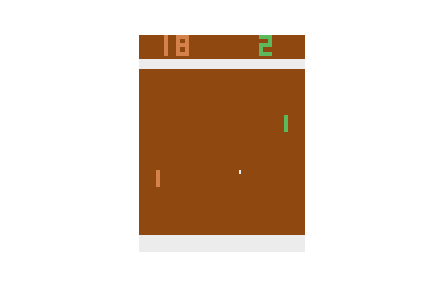
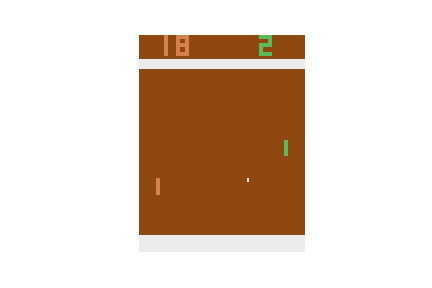
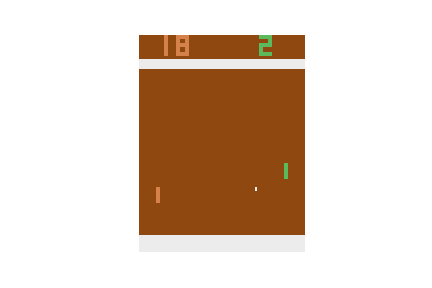
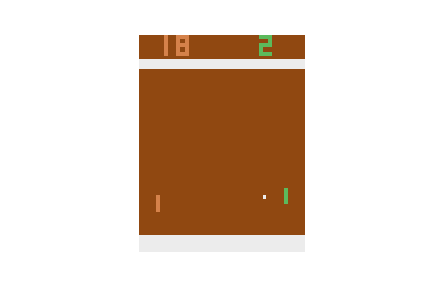
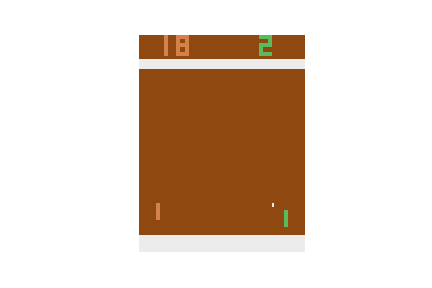
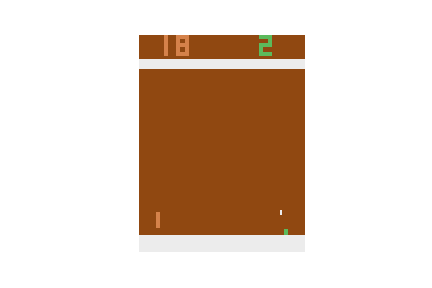
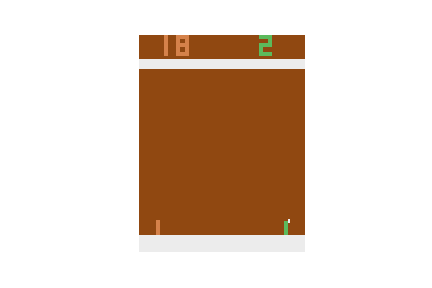
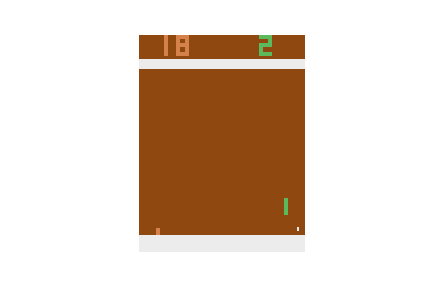
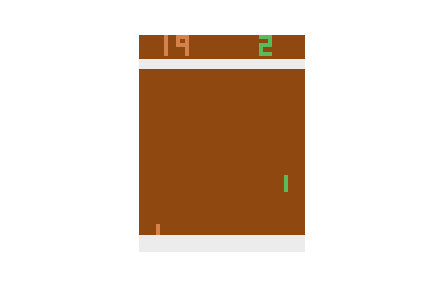
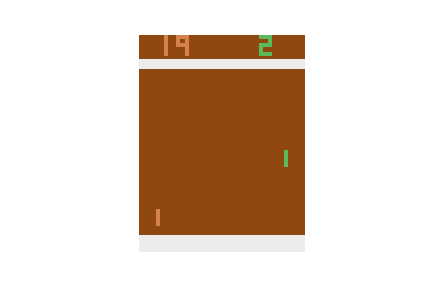
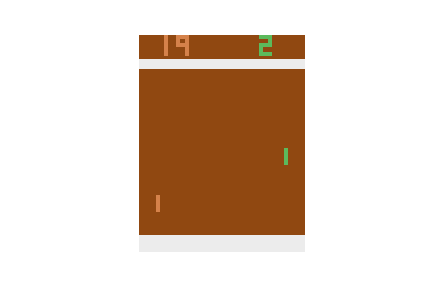
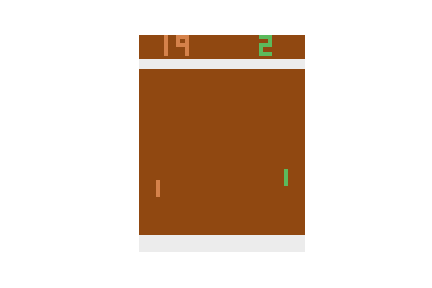
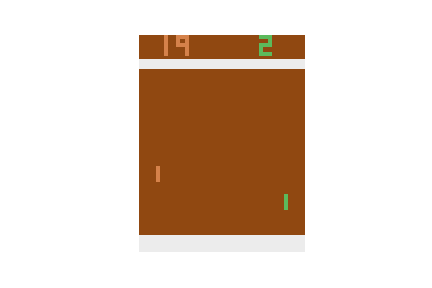
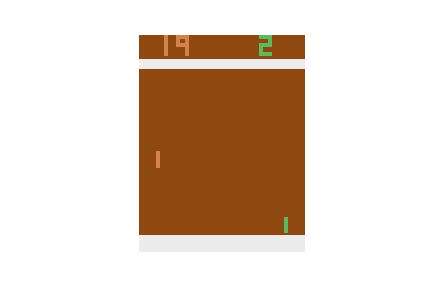
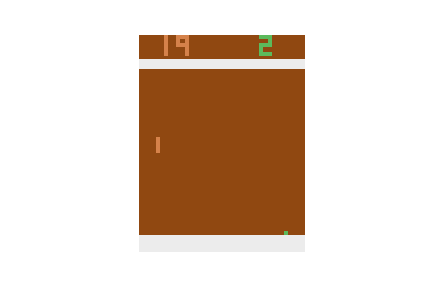
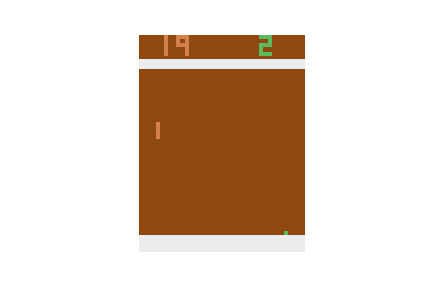
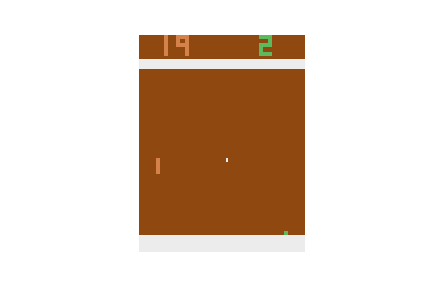
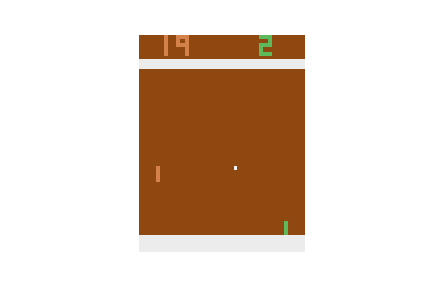
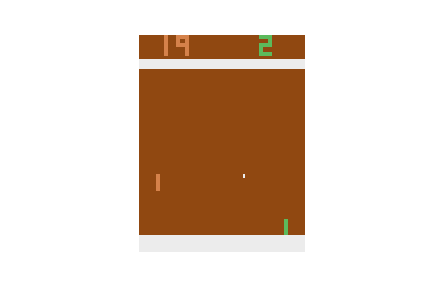
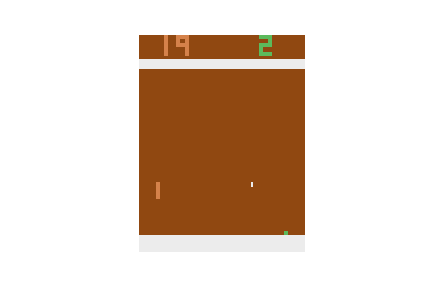
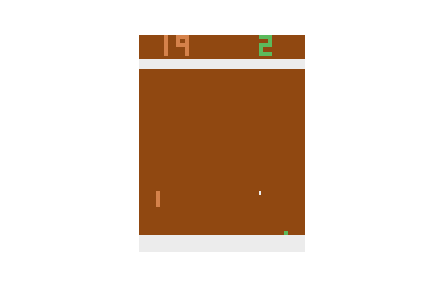
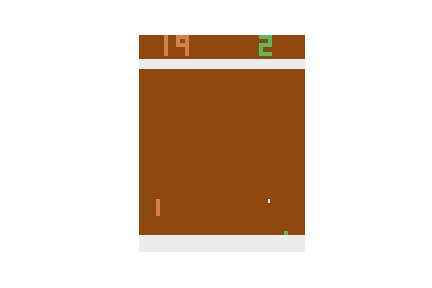
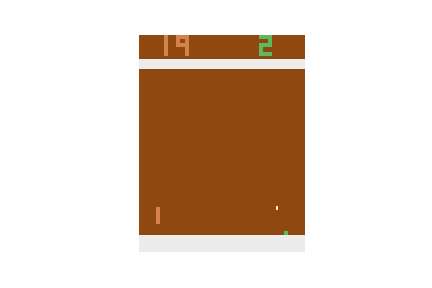
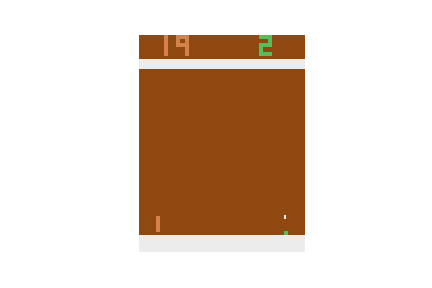
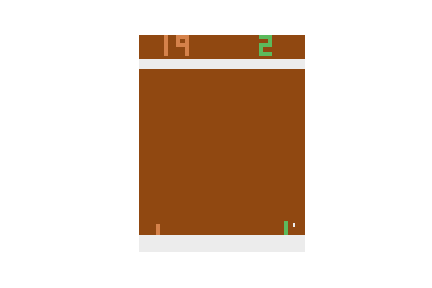
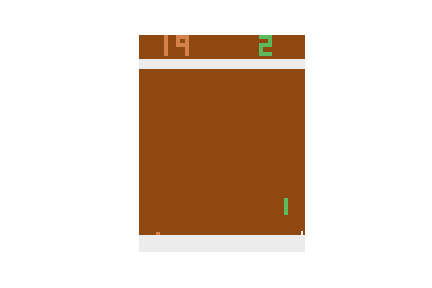
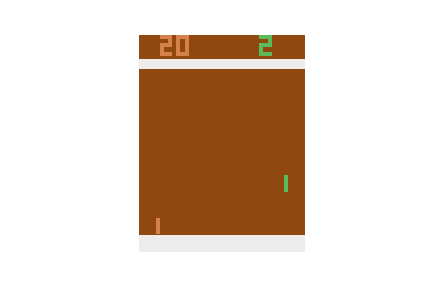
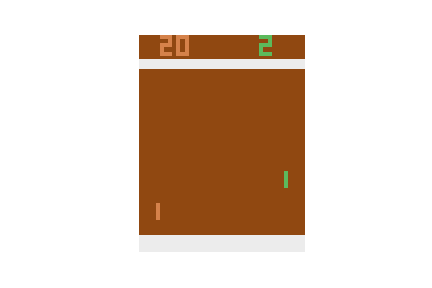
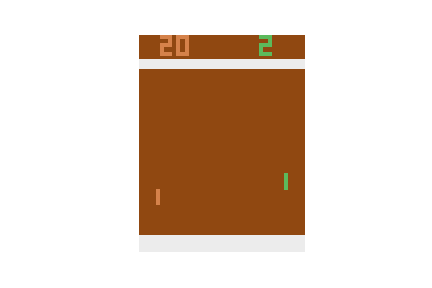
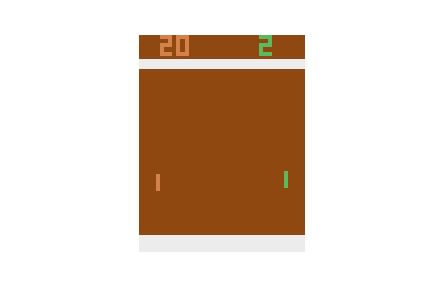
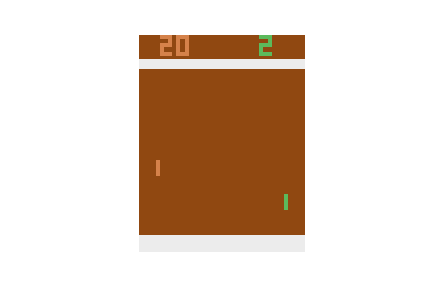
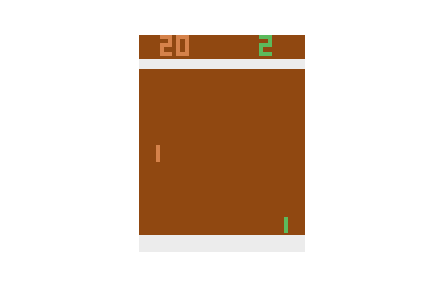
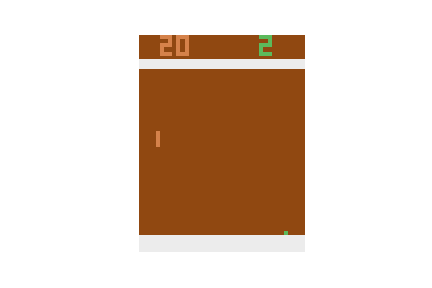
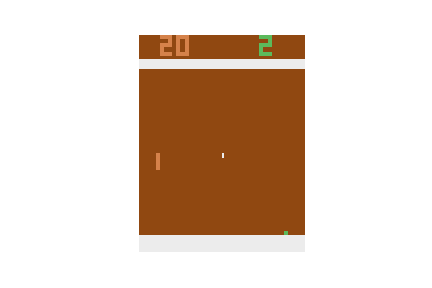
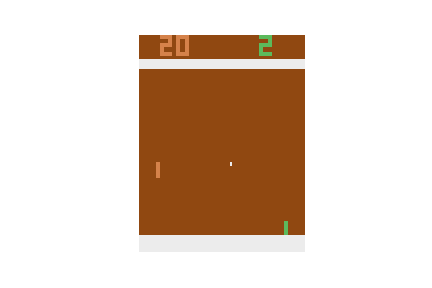
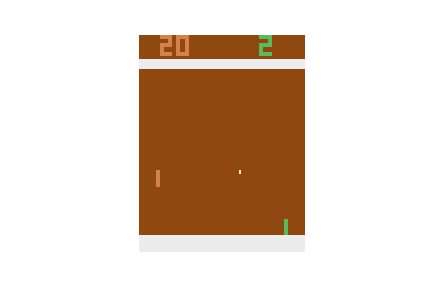
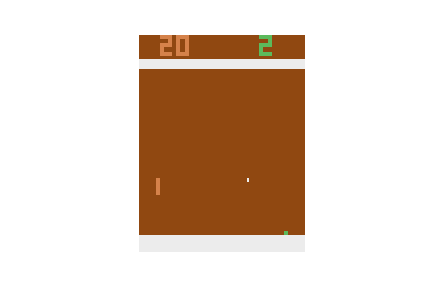
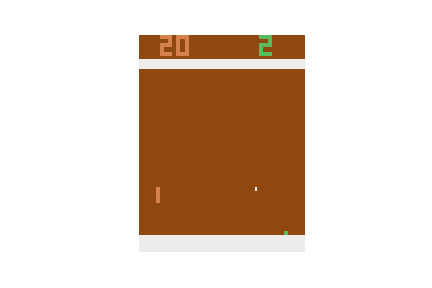
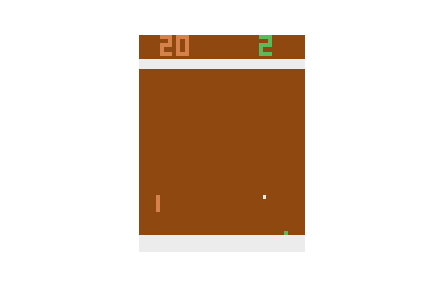
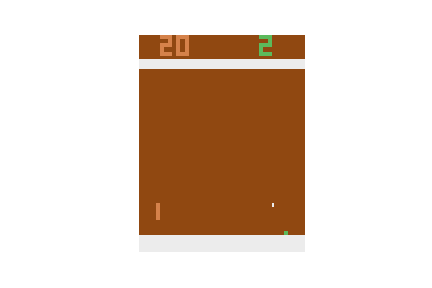
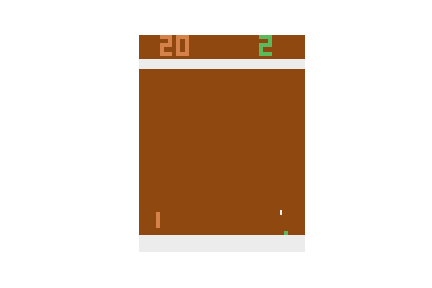
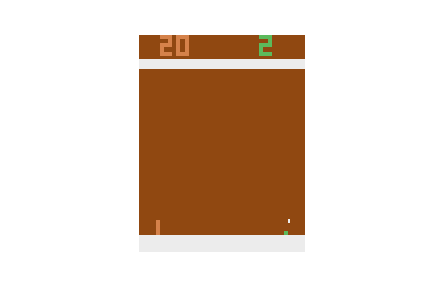
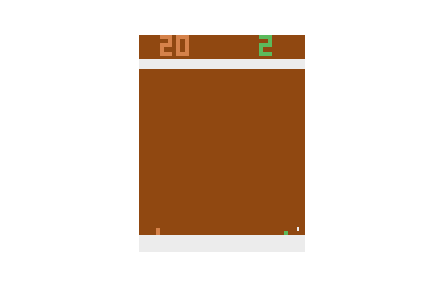
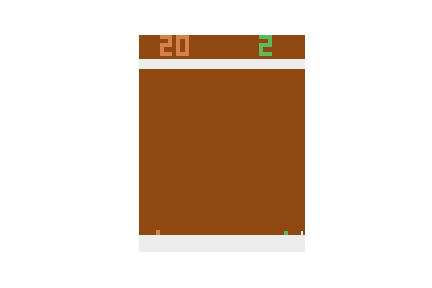

In [10]:
# View performace of the trained agent!
pong_utils.play(env, policy, time=2000) 